In [6]:
# Some tunable parameters
import numpy as np

K = 5 # 'dimension' of the parameters (nb of coefficients to estimate)
functions = [1]+[np.cos,np.sin]*(K//2) # 
wavenumbers = [0]+[1+k//2 for k in range(K-1)] # wavenumbers inside the sinus function[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]


# Physical model 
rho = 0.917 # ice density
gx,gy =5, -10 # x and y components for the gravity


def build_beta(coeffs):
    """
    Auxiliary function to build a function beta based on the theta coefficients in the arguments.
    We exponentiate because beta must be a positive function.

    Keyword arguments:
    coeffs -- float list of size K, the coefficients weigthing the truncated Fourier expansion functions

    Returns:
    beta -- one-dimensional function representing the basal drag factor
    """

    beta = lambda x: np.exp((coeffs[0] + sum([coeffs[k]*functions[k](wavenumbers[k]*2*np.pi*x[0]) for k in range(1,K)]))/K)

    return beta



# PDE Solver

In this section, we build our forward map, i.e. the solver for the Stokes flow.

It takes as argument the list of coefficients \theta that we will use to build the function β (basal drag factor on the lower boundary of the domain), and outputs the values of the velocity on the boundary.

In this section we also define the geometry of the domain (mesh, function spaces)

### Various imports

In [7]:
import dolfinx

In [8]:
#Other miscellaneous imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time


import ufl
from dolfinx import cpp as _cpp
from dolfinx import fem
from dolfinx import plot
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form, Expression,
                         locate_dofs_geometrical, locate_dofs_topological)
from dolfinx.io import XDMFFile
from dolfinx.mesh import (CellType, GhostMode, create_rectangle, locate_entities,
                          locate_entities_boundary, meshtags)

from dolfinx import geometry

from ufl import div, dx, grad, inner, Measure

from mpi4py import MPI
from petsc4py import PETSc

"""
# Setup environment for interactive plotting
!apt-get install -qq xvfb
!pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')
"""

"\n# Setup environment for interactive plotting\n!apt-get install -qq xvfb\n!pip install pyvista panel -q\n\nimport os\nos.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')\nos.environ['DISPLAY'] = ':99'\n\nimport panel as pn\npn.extension('vtk')\n"

### Study the impact of the mesh size

In [9]:
def solve_mesh(size_msh):
    
    # Create the mesh
    msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([1, 1])],
                       [size_msh, size_msh],
                       CellType.triangle, GhostMode.none)
    
    

    # We define the finite elements function space (Taylor Woods method)
    P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
    P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)
    mixed = ufl.MixedElement([P2, P1])

    V, Q = FunctionSpace(msh, P2), FunctionSpace(msh, P1)
    W = FunctionSpace(msh, mixed) # Defined Mixed Function space - needed for solving divergence at same time
    
    
    #Create the subdomains and space for Robin boundary condition in this problem

    tol = 1E-14 # tolerance (we cannot use strict equalities)

    boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
                  (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


    # We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
    facet_indices, facet_markers = [], []
    fdim = msh.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = locate_entities(msh, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


    # To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
    msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
    #with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
    #    xdmf.write_mesh(msh)
    #    xdmf.write_meshtags(facet_tag)

    # Now we can create a custom integration measure ds, which can be used to restrict integration. 
    #If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

    ds = Measure("ds", domain=msh, subdomain_data=facet_tag)
    
    
    
    
    # Define the class of boundary conditions 

    class BoundaryCondition():
        def __init__(self, type, marker, values):
            self._type = type
            if type == "Dirichlet":
                u_D = Function(V)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = locate_dofs_topological(V, fdim, facets)
                self._bc = dirichletbc(u_D, dofs)

            elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)

            elif type == "Robin":
              #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
              # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
                self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
            else:
                raise TypeError("Unknown boundary condition: {0:s}".format(type))

        @property
        def bc(self):
            return self._bc

        @property
        def type(self):
            return self._type


    version = "sum"

    # We now define the bilinear and linear forms corresponding to the weak
    # mixed formulation of the Stokes equations in a blocked structure:

    # Define variational problem: Trial and test functions
    u, p = ufl.TrialFunctions(W)
    v, q = ufl.TestFunctions(W)

    # Define the source terms (based on tunable parameters at the top)
    f = Constant(msh, (PETSc.ScalarType(rho*gx), PETSc.ScalarType(rho*gy)))


    # Define the bilinear form
    a = inner(grad(u), grad(v)) * dx - inner(p, div(v)) * dx + inner(div(u), q) * dx

    # Define the linear form
    L = inner(f, v) * dx + inner(Constant(msh, PETSc.ScalarType(0)), q) * dx



    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0))) # no stress --> tau = 0

    # Set the values for Robin BC
    beta = build_beta(theta)
    r = Function(Q)
    r.interpolate(beta)
    s = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
      if condition.type == "Dirichlet":
          bcs.append(condition.bc)

      elif condition.type == "Neumann":
          linear_term = condition.bc
          L+= linear_term

      elif condition.type == "Robin":

          bilinear_term, linear_term = condition.bc

          if version == "sum":
              a+= bilinear_term

          else:
              a[0].append(bilinear_term) # add the modification to bilinear form

          L+= linear_term   # add the modification to linear form

      else: 
          print("Unhandled condition type")



    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------
    
    # Assemble LHS matrix and RHS vector
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    U = Function(W)
    
    start_time = time.time()
    ksp.solve(b, U.vector)
    solve_time = time.time()-start_time

    # Split the mixed solution and collapse
    uh = U.sub(0).collapse()
    ph = U.sub(1).collapse()



    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------

    # Gather coordinates of mesh points that are at the surface

    facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

    fdim = msh.topology.dim - 1
    msh.topology.create_connectivity(fdim, 0)

    num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
    geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
    points = msh.geometry.x

    surface_coordinates=[]
    for e, entity in enumerate(geometry_entitites):
        if e in facets_surface:
            coord1, coord2 = points[entity][0], points[entity][1]
            surface_coordinates.append(coord1)
            surface_coordinates.append(coord2)

    surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

    # Prepare the tools to find corresponding cells

    bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

    # Choose one of the cells that contains the point

    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

    for i, point in enumerate(surface_coordinates):

        if len(colliding_cells.links(i))>0:

            cells.append(colliding_cells.links(i)[0])



    u_values = uh.eval(surface_coordinates, cells)
    p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values, solve_time

In [5]:
# Run the analysis

sizes_mesh = [32, 50, 80, 100, 150]#, 200, 250]
theta = [-1, 0, 1, -1]
coords=[]
solutions = []
solve_times=[]

for sm in sizes_mesh:
    print(sm)
    surface_coordinates, u_values,solve_time = solve_mesh(sm)
    coords.append(surface_coordinates)
    solutions.append(u_values)
    solve_times.append(solve_time)

32
50
80
100
150


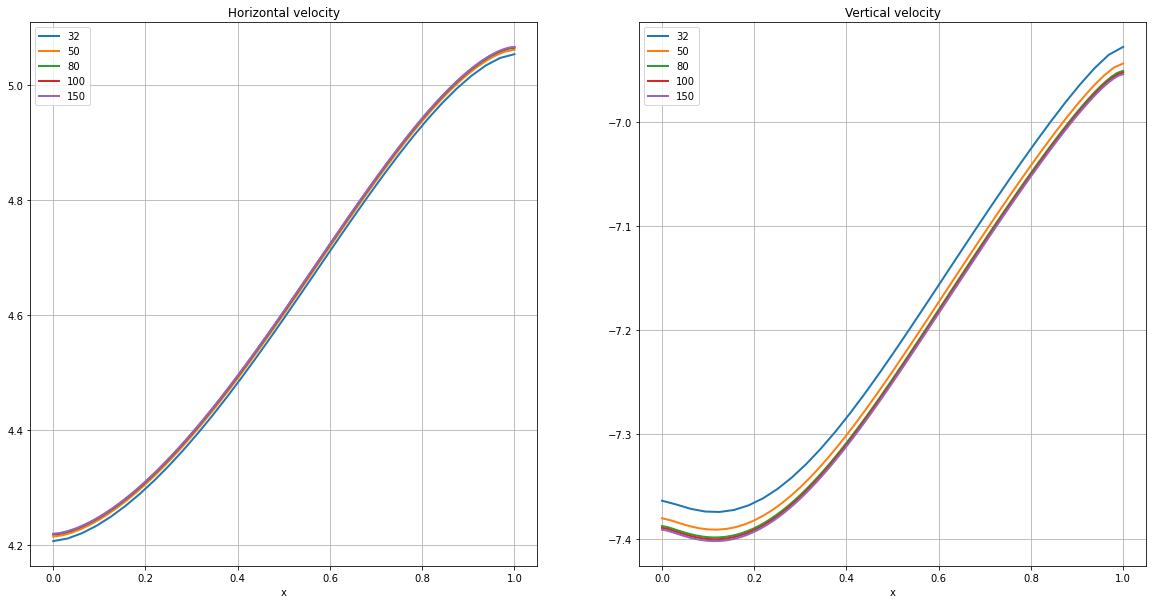

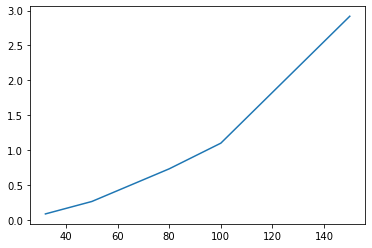

In [6]:
# Plot
fig = plt.figure(figsize=(20,10))

for i in range(len(sizes_mesh)):
    u_values = solutions[i]
    surface_coordinates = coords[i]
    velocity_x = [u_values[i][0] for i in range(len(coords[i]))]
    velocity_y = [u_values[i][1] for i in range(len(coords[i]))]
    x_value = [surface_coordinates[i][0] for i in range(len(coords[i]))]

    plt.subplot(121)
    plt.plot(x_value, velocity_x, linewidth=2, label=f"{sizes_mesh[i]}")

    plt.subplot(122)
    plt.plot(x_value, velocity_y, linewidth = 2, label=f"{sizes_mesh[i]}")

plt.subplot(121)
plt.title('Horizontal velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.subplot(122)
plt.title('Vertical velocity')
plt.grid(True)
plt.xlabel("x")
plt.legend()

plt.figure()
plt.plot(sizes_mesh, solve_times)

# If run in parallel as a python file, we save a plot per processor
#plt.savefig(f"velocity_plots.png")

## One function - Variational form and solving

In [10]:
# Create the mesh

size_msh = 50
msh = create_rectangle(MPI.COMM_WORLD,
                       [np.array([0, 0]), np.array([1, 1])],
                       [size_msh, size_msh],
                       CellType.triangle, GhostMode.none)
    

In [11]:
# We define the finite elements function space (Taylor Woods method)

# We define two {py:class}`FunctionSpace <dolfinx.fem.FunctionSpace>`
# instances with different finite elements. `P2` corresponds to a continuous
# piecewise quadratic basis for the velocity field and `P1` to a continuous
# piecewise linear basis for the pressure field:


P2 = ufl.VectorElement("Lagrange", msh.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", msh.ufl_cell(), 1)
mixed = ufl.MixedElement([P2, P1])

V, Q = FunctionSpace(msh, P2), FunctionSpace(msh, P1)
W = FunctionSpace(msh, mixed) # Defined Mixed Function space - needed for solving divergence at same time

In [12]:
#Create the subdomains and space for Robin boundary condition in this problem

tol = 1E-14 # tolerance (we cannot use strict equalities)

boundaries = [(1, lambda x: abs(x[1])<= tol),   # Robin BC, at the bottom
              (2, lambda x: abs(x[1]-1)<= tol)]   # Neumann BC, at  the surface


# We now loop through all the boundary conditions and create MeshTags identifying the facets for each boundary condition
facet_indices, facet_markers = [], []
fdim = msh.topology.dim - 1

for (marker, locator) in boundaries:
    facets = locate_entities(msh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file
msh.topology.create_connectivity(msh.topology.dim-1, msh.topology.dim)
#with XDMFFile(msh.comm, "facet_tags.xdmf", "w") as xdmf:
#    xdmf.write_mesh(msh)
#    xdmf.write_meshtags(facet_tag)

# Now we can create a custom integration measure ds, which can be used to restrict integration. 
#If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag

ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

In [13]:
def forward_map(theta):
    """
    Forward map for the inverse model. Maps the coefficients

    Keyword arguments:
    theta --
    
    Returns:

    """

    # Define the class of boundary conditions 

    class BoundaryCondition():
        def __init__(self, type, marker, values):
            self._type = type
            if type == "Dirichlet":
                u_D = Function(V)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = locate_dofs_topological(V, fdim, facets)
                self._bc = dirichletbc(u_D, dofs)

            elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)

            elif type == "Robin":
              #self._bc = values[0] * inner(u-values[1], v)* ds(marker)
              # slight modification: returns 2 integrals, one for the bilinear form a and one for the linear form L
                self._bc = values[0] * inner(u,v)* ds(marker), values[0] * inner(values[1], v)* ds(marker)
            else:
                raise TypeError("Unknown boundary condition: {0:s}".format(type))

        @property
        def bc(self):
            return self._bc

        @property
        def type(self):
            return self._type


    version = "sum"

    # We now define the bilinear and linear forms corresponding to the weak
    # mixed formulation of the Stokes equations in a blocked structure:

    # Define variational problem: Trial and test functions
    u, p = ufl.TrialFunctions(W)
    v, q = ufl.TestFunctions(W)

    # Define the source terms (based on tunable parameters at the top)
    f = Constant(msh, (PETSc.ScalarType(rho*gx), PETSc.ScalarType(rho*gy)))


    # Define the bilinear form
    a = inner(grad(u), grad(v)) * dx - inner(p, div(v)) * dx + inner(div(u), q) * dx

    # Define the linear form
    L = inner(f, v) * dx + inner(Constant(msh, PETSc.ScalarType(0)), q) * dx



    #-----------------SET THE BOUNDARY CONDITIONS FOR THE PROBLEM----------------------------------------------

    # Set the values for Neumann BC
    values_boundary_neumann = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0))) # no stress --> tau = 0

    # Set the values for Robin BC
    beta = build_beta(theta)
    r = Function(Q)
    r.interpolate(beta)
    s = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))
    values_boundary_robin = (r,s)

    # Gather the Boundary conditions
    boundary_conditions = [BoundaryCondition("Robin", 1, values_boundary_robin),
                        BoundaryCondition("Neumann", 2, values_boundary_neumann)]

    bcs = []
    for condition in boundary_conditions:
      if condition.type == "Dirichlet":
          bcs.append(condition.bc)

      elif condition.type == "Neumann":
          linear_term = condition.bc
          L+= linear_term

      elif condition.type == "Robin":

          bilinear_term, linear_term = condition.bc

          if version == "sum":
              a+= bilinear_term

          else:
              a[0].append(bilinear_term) # add the modification to bilinear form

          L+= linear_term   # add the modification to linear form

      else: 
          print("Unhandled condition type")



    #-----------------------------ASSEMBLE AND SOLVE-----------------------------------------------

    # Assemble LHS matrix and RHS vector
    a,L = form(a),form(L)

    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")
    ksp.getPC().setFactorSolverType("superlu_dist")

    # Compute the solution
    U = Function(W)
    ksp.solve(b, U.vector)

    # Split the mixed solution and collapse
    uh = U.sub(0).collapse()
    ph = U.sub(1).collapse()



    #-----------------------------EVALUATE ON THE SURFACE AND OUTPUT VALUES-------------------------

    # Gather coordinates of mesh points that are at the surface

    facets_surface = facet_tag.find(2) # points at the surface boundary were marked with marker 2 (see previous cell)

    fdim = msh.topology.dim - 1
    msh.topology.create_connectivity(fdim, 0)

    num_facets_owned_by_proc = msh.topology.index_map(fdim).size_local
    geometry_entitites = dolfinx.cpp.mesh.entities_to_geometry(msh, fdim, np.arange(num_facets_owned_by_proc, dtype=np.int32), False)
    points = msh.geometry.x

    surface_coordinates=[]
    for e, entity in enumerate(geometry_entitites):
        if e in facets_surface:
            coord1, coord2 = points[entity][0], points[entity][1]
            surface_coordinates.append(coord1)
            surface_coordinates.append(coord2)

    surface_coordinates = np.unique(surface_coordinates, axis=0) # remove duplicates    

    # Prepare the tools to find corresponding cells

    bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)
    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, surface_coordinates)

    # Choose one of the cells that contains the point

    colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, surface_coordinates)

    for i, point in enumerate(surface_coordinates):

        if len(colliding_cells.links(i))>0:

            cells.append(colliding_cells.links(i)[0])



    u_values = uh.eval(surface_coordinates, cells)
    p_values = ph.eval(surface_coordinates, cells)

    return surface_coordinates, u_values

# MCMC

## Generating the synthetic data: "true coefficients" and the measurements¶

Values of the true coefficients set to [-0.32299715 -2.33306363 -1.36370042 -1.56091605  1.06943643]


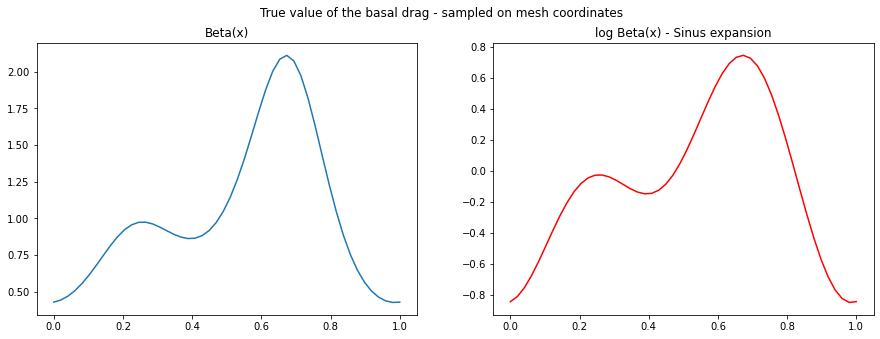

In [19]:
### Generating synthetic data

# Generate K coefficients following prior assumptions
theta_0 = np.random.normal(loc=0.0, scale=1, size=K)
#theta_0 = np.array([0.7, 0, 0, 0])

print(f"Values of the true coefficients set to {theta_0}")

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,1,size_msh)]

# Plot

plt.figure(figsize=(15,5))
plt.suptitle("True value of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval])

plt.subplot(1,2,2)
plt.title("log Beta(x) - Sinus expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval],'r-')

plt.show()

In [20]:
# We repeat N experiments of measurements with the true coefficients and noise

# Retrieve the true values according to the model with true coefficients

surface_coordinates, u_values_true = forward_map(theta_0)
print(u_values_true)


# Simulate noisy observations
N= 10000
scale_noise = 0.01

observations = []

for n_obs in range(N):
    observation = u_values_true.copy()
    added_noise = np.random.normal(loc=0.0, scale=scale_noise, size=np.shape(observation)) # add gaussian noise at every evaluation
    observation+=added_noise

    observations.append(observation)
    
    


[[  6.24355424 -11.06017856]
 [  6.24616417 -11.06306348]
 [  6.25148871 -11.0677013 ]
 [  6.25883232 -11.07282449]
 [  6.26785449 -11.07798973]
 [  6.27835407 -11.08296198]
 [  6.2901825  -11.08760197]
 [  6.30322186 -11.0918225 ]
 [  6.31737422 -11.09556954]
 [  6.33255491 -11.09881116]
 [  6.34868861 -11.10153094]
 [  6.36570667 -11.10372369]
 [  6.38354536 -11.10539247]
 [  6.4021445  -11.10654644]
 [  6.42144654 -11.10719929]
 [  6.44139583 -11.10736793]
 [  6.46193803 -11.10707155]
 [  6.48301969 -11.10633076]
 [  6.50458792 -11.10516694]
 [  6.52659009 -11.10360167]
 [  6.54897367 -11.10165628]
 [  6.571686   -11.09935141]
 [  6.59467421 -11.09670671]
 [  6.61788509 -11.09374054]
 [  6.64126504 -11.09046974]
 [  6.66476    -11.0869095 ]
 [  6.68831541 -11.08307318]
 [  6.71187617 -11.0789723 ]
 [  6.7353866  -11.07461646]
 [  6.75879044 -11.07001339]
 [  6.78203076 -11.06516906]
 [  6.80504997 -11.06008779]
 [  6.82778968 -11.05477245]
 [  6.85019066 -11.04922476]
 [  6.87219268

## Run the MCMC

In [42]:
# Auxiliary functions

def compute_loglikelihood(model_values, observations):
    """
    Keyword arguments:
    observations -- array, list of observations at the surface
    model_values -- array, outputs of the model (forward map) for the velocity at the surface

    Returns:
    loglikelihood -- int, the loglikelihood defined as in Richard Nickl's notes
    """
    loglikelihood = 0

    for i in range(len(observations)):
        observation = observations[i]
        #print(model_values, observation)
        #print(model_values - observation)
        #print(np.sum((model_values - observation)**2))
        loglikelihood+= np.sum((model_values - observation)**2)

    loglikelihood = -1/2 * loglikelihood  / (scale_noise**2)
    return loglikelihood


def compute_proposal_pcn(current_value, gamma):
    """
    Compute the proposal value for the coefficients of beta function for pCN scheme

    Keyword arguments:
    current_value -- array, current value of the Markov chain
    gamma -- float, step size

    Returns:
    proposal -- array, proposal for the next state of the Markov chain
    """
    #print("Current value: ", current_value)

    proposal = np.sqrt(1-2*gamma)*current_value + np.sqrt(2*gamma)*np.random.normal(loc=0.0, scale=scale_coefficients, size=len(current_value))
    
    #print("Proposal: ", proposal)

    return proposal



def metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject):
    """
    Practice the Metropolis-Hastings step for the pCN scheme 
    
    Keyword arguments:
    current_loglikelihood -- int, current loglikelihood
    proposal_loglikelihood -- int, loglikelihood of the proposal

    Returns:
    boolean -- True if we accept the proposal, False otherwise
    """
    acceptance_probability = min(0, proposal_loglikelihood - current_loglikelihood)
    #print(proposal_loglikelihood, current_loglikelihood)
    #print(f"Proposal likelihood: {proposal_loglikelihood}, Current likelihood: {current_loglikelihood}")
    #print("Accept proba:", acceptance_probability)
    # We draw a U([0,1]) r.v and return the proposal with probability acceptance_probability

    draw = np.random.uniform()
    print(np.exp(acceptance_probability))
    return np.log(draw) < acceptance_probability    


In [43]:
# RUN THE MARKOV CHAIN

# Parameters of the MCMC
n_iter = 100000 # number of iterations of the chain
gamma = 0.000001 # step size
scale_coefficients = 0.1 # Gaussian prior for coefficients



# INITIALISATION

theta = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)
theta = theta_0  #initialise at true value

# Compute the model and likelihood of this proposal
surface_coords,model_values = forward_map(theta)
current_loglikelihood = compute_loglikelihood(model_values, observations)

# Useful tables to store values

chain = np.zeros((n_iter,K)) # store the values of the chain
chain[0, :] = theta

accept_reject = np.zeros(n_iter, dtype=bool) # boolean table we use to track whether the proposal was accepted/rejected
accept_reject[0] = True 

likelihoods = np.zeros(n_iter)
likelihoods[0] = current_loglikelihood # store values of likelihoods


#--------------------ITERATE--------------------------------------------------

for iter in range(n_iter):

    if iter % 10 == 0:
        print(f"Iteration nb {iter} done")

    # Get the proposal for new value
    proposal = compute_proposal_pcn(theta, gamma)
    #print('Proposal: ', proposal)

    # Compute the model and likelihood of this proposal
    surface_coords, model_values = forward_map(proposal)
    proposal_loglikelihood = compute_loglikelihood(model_values, observations)

    # Metropolis step
    accept = metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject)

    if accept:
        #print('accepted')
        accept_reject[iter]=True
        theta = proposal.copy()
        current_loglikelihood = proposal_loglikelihood

    else:
        #print("rejected")
        accept_reject[iter]=False


    chain[iter,:] = theta
    likelihoods[iter]= current_loglikelihood


Iteration nb 0 done
0.9631779751610262
0.8007606421479503
1.0
0.01414216955762306
0.27219840354281616
1.0
0.8037484808261999
1.0
0.7856641171406781
0.0005964632864570504
Iteration nb 10 done
0.00030419381439220056
3.5149562852599117e-07
0.8927598089334506
1.0
0.3914956808354739
0.09141567418307237
1.0
0.8226387775877954
0.1742028331132578
0.038371146788517455
Iteration nb 20 done
0.07062561636014866
0.050419930095805525
0.002761955181331781
0.00397779106996019
0.030995538985793453
1.0
0.8762194629601701
0.059571150316937584
0.20774332488720718
0.0016051525961429192
Iteration nb 30 done
0.0038348392017361716
0.0007610502950105463
0.9402885168726088
1.7126063102178954e-05
0.5327811166766717
0.37189954815230536
3.9492794102066514e-05
3.4280410528802306e-06
0.0003821818709327644
1.0
Iteration nb 40 done
0.6644325280247323
0.838538010701312
3.0474071263290495e-06
1.0
8.541788431091825e-05
0.017198203821120587
0.3269393645371573
1.0
0.5793664425162877
0.8945740802553701
Iteration nb 50 done


0.0004460562220862192
1.6775465265854748e-05
0.015790002420534566
0.004916683117581121
4.514660304476892e-06
3.8238536799926696e-05
0.5047812418991569
2.0871383552111815e-05
1.0
1.0
Iteration nb 430 done
8.366683817321316e-05
0.4483597628248489
1.0
0.009896067424863268
0.02277266476921604
0.0023357277699548318
1.8712163919214407e-10
0.09273083738102594
0.0007644353129648087
0.8502839963441885
Iteration nb 440 done
1.0
0.9631209354500858
1.0
0.008525727057502515
1.0
0.4294800101381006
0.008159450842867842
1.0
0.00158492778127372
0.576973299155178
Iteration nb 450 done
0.015550068404252047
0.96962913468694
0.0004362443210870738
0.6404503531745056
0.029470186046729085
0.7159859708601651
1.0
2.1978603395114105e-11
0.9283028937512741
0.17232724528772456
Iteration nb 460 done
1.3214875009719777e-07
0.07931366917925282
0.023327731549697934
0.11589037890360848
0.826599440807091
0.001868218241289628
0.7664422890486917
0.18343663295808518
1.0
0.003544404920579015
Iteration nb 470 done
1.40175914

0.2836492426214005
0.18690040822073994
1.0
1.0
0.006269458017224119
1.0
Iteration nb 840 done
2.2134512605351575e-10
1.0
6.485405049567414e-05
0.0008297606948570926
0.3877974582272951
0.0017474393083634237
0.5795221673333311
0.0002811938057602512
0.8978452384231578
1.0
Iteration nb 850 done
0.6838081856814265
0.018915349608984083
0.03565401873631255
0.41970212567019977
0.00010860818934552438
0.13131005009956542
1.0
0.021271816444754756
1.0
0.21586565615713163
Iteration nb 860 done
2.7718971084919814e-05
1.0
0.29400206133176265
0.0013485287035661345
0.3989597046918406
0.0003284270691768479
0.6554744211198489
0.5053468044142246
7.702469344149724e-07
0.8718469760166055
Iteration nb 870 done
0.4074437216860449
0.5167572593065185
0.0009501142286268149
0.07710421223953175
1.3756793595662187e-10
0.09813521413838265
2.7515089452505935e-13
6.163142097091121e-12
6.405728504076837e-06
1.0
Iteration nb 880 done
0.5723226382659786
0.43529722538370424
1.0
0.9784744732157935
0.5252009893520708
1.0
0.

1.5495438555228286e-13
3.3739206254710614e-05
0.2585510351320102
Iteration nb 1250 done
0.06161110882155752
1.0
0.004186933396981405
4.201806344403881e-07
6.132838320772347e-11
1.0
0.7985331243563748
0.8274912031269133
1.0
0.14297386022543787
Iteration nb 1260 done
0.37746751139472046
0.6865600254319019
4.190978591091517e-08
4.5806719759456487e-10
2.662304914859588e-13
0.0055769831171547995
0.009081256119938257
8.239677434986774e-05
2.786296155228957e-07
1.0
Iteration nb 1270 done
0.6621711591091081
0.726422462101641
0.4759109330692917
0.0005045788384332841
1.385650247324542e-06
2.124817262447085e-05
0.12303014594616254
1.0
0.5443286017328002
1.0
Iteration nb 1280 done
0.8841417701987632
0.9734706868683062
1.0
1.0
1.0
9.896948373382998e-08
0.000978926451985785
5.255634218728618e-15
0.5024407419786463
8.268391362459396e-23
Iteration nb 1290 done
0.04131148369566408
0.3274278113915182
0.0023237115344193608
1.0
1.0
0.8486845256810003
1.0
0.019904638186178155
1.0
6.180318657854093e-06
Iter

0.17383181510635273
0.6056177720030947
0.37133567339948353
0.04978742053424719
Iteration nb 1670 done
0.30828530667323406
0.9430871899071704
0.6631781088169577
0.7677986486284559
1.0
0.665064951636575
0.014308939466266275
1.0
0.05826347157560534
0.5730870063900354
Iteration nb 1680 done
1.0
0.32471824132416394
1.0
0.24446871668477468
0.2588426219644699
1.0
1.0
0.1849696414973288
1.2727296096734796e-05
0.4456796725353645
Iteration nb 1690 done
0.044314320482496505
1.0
1.0
2.300231454195655e-06
0.7647061569545395
1.688214510074118e-05
0.06764078913921388
0.8040308534814679
1.0
0.26000126239977284
Iteration nb 1700 done
1.0220549158966214e-12
0.6735598780642768
1.0
0.012568469660391293
0.4799550561469783
0.02381010096435211
0.0007206212774025766
3.670126264585873e-06
1.0
0.06346955907383506
Iteration nb 1710 done
0.03143731361367202
3.2523768684451824e-11
0.8802733406308094
0.0011085049092944875
0.2585436982547202
0.7336941539217249
0.07483155653103701
0.03382600262301836
1.0
0.4247854904

0.7630051141456068
1.632205339061178e-05
1.0
0.02091712876030479
8.478252787444175e-09
1.0
0.2411825650885281
0.020201709998496083
1.0
Iteration nb 2100 done
1.0
0.5329764276056945
1.0863833203671336e-07
0.009297582128618073
9.318694576957909e-05
0.05452961258376443
0.00150305498550316
0.022594523382105294
3.8987242343610416e-07
0.032773577732674274
Iteration nb 2110 done
1.0
0.004783298571220301
0.6714266995094593
5.468107206746135e-06
1.2513727568255622e-06
1.0
0.5400053747683802
1.0
0.02194930464328566
0.039510559168085026
Iteration nb 2120 done
0.5909926754138611
0.0015265729670702545
0.5205333274000432
0.0040911048700615505
2.6110619333846725e-09
1.0
0.008371809790280413
0.5735619012107457
0.019034506035328934
0.0015920517354096181
Iteration nb 2130 done
1.0
0.482257017427801
1.0
0.0022593905389236162
0.09789074952455934
1.0
0.0005156124188619342
0.0009277937411260819
0.5175815196088721
0.1769651700600844
Iteration nb 2140 done
0.0034878295642407618
0.06307272903965455
1.0
0.94477

0.2879841521751575
0.001317000426990101
1.0
Iteration nb 2510 done
1.0
1.255404462519879e-06
0.004476570677606051
1.0
0.05729073949003019
1.005839077950898e-05
0.478642857640088
1.0
6.284295795561127e-05
0.6329492351580833
Iteration nb 2520 done
0.05464619540971208
0.20515982331216517
1.0
1.0
1.0
1.0
0.10460816391702177
0.3452927755734947
0.9933238336474489
0.3994119490082815
Iteration nb 2530 done
0.27027414645493547
1.0
0.06415795316563781
0.23124886259312094
1.21682476063482e-05
0.05414453129626101
7.321293568409714e-08
4.214807529170609e-06
0.21370100314335272
0.0003670430194774083
Iteration nb 2540 done
1.0
9.51733072512269e-07
6.817501546707383e-06
1.9072188116517057e-07
1.0
5.661066687896785e-06
0.9932322751499347
0.000234870387884533
0.4498592012649219
0.0034803702875158245
Iteration nb 2550 done
0.9208408188688119
0.014185637803500802
2.8725384986536184e-05
0.0005695408103726392
1.8858750525803977e-07
1.0
0.9336392660417443
1.0
0.6690361117263424
3.5618262082768055e-07
Iterati

1.0
0.856034234849921
1.0
0.8712809745886204
1.0
0.6087441465539826
0.15818450286686034
0.1022893803079797
0.12080475207669196
1.0
Iteration nb 2940 done
0.4229741022942066
0.8493017238023309
0.017937791078983262
0.00016286062391680434
0.025360688775560133
4.0536036873219607e-07
0.17445654666267293
0.7008925432282306
0.018824971487981575
0.0012406303241278942
Iteration nb 2950 done
0.23265883601617812
0.00026664536374638076
3.942043142012804e-05
0.22672860345169019
1.2913672967638306e-06
0.05293267751361318
1.0
0.9053629627879851
0.25698119223868016
1.0
Iteration nb 2960 done
0.2209197017228469
0.0011834496203694952
0.0004703626640718959
0.18753448986007545
0.12811596350689486
0.2577889034827617
1.0
0.2088234835000775
2.0952115588686184e-06
0.034418717361559555
Iteration nb 2970 done
1.0
0.13389973732911262
0.17583486556067343
0.09294578061671588
0.9062841320036256
0.06288997999432551
0.40536049593114326
0.0014397956217693912
0.010937883840504073
0.1678476752344002
Iteration nb 2980 do

1.0
0.7792232423810064
1.0
0.6243128240519877
Iteration nb 3350 done
0.00033164092303864136
0.2728445185325562
4.1909294482241665e-06
1.0
0.7900427111183749
0.0005092786187816286
1.0
2.7702879086449383e-05
0.17604065341885655
0.0030172513711616395
Iteration nb 3360 done
0.10258651025025073
0.02750307770945903
1.0
1.0
2.9533391449483905e-05
1.0
0.9944695908414815
0.0001164198763888842
0.20408032956822958
7.417073598296795e-08
Iteration nb 3370 done
2.0916087889161214e-05
1.0
1.0
0.24960350093455091
1.0
0.1593582050329817
1.4483964532471942e-05
5.8314714426853266e-05
0.0008990166499590137
8.917153667868727e-09
Iteration nb 3380 done
0.00528493069065125
1.0282467428960592e-07
0.16236436825863612
0.0005722903698625716
0.6404626422007099
1.0
1.0
0.00478901295587477
0.32134981428856546
1.8381600297070421e-06
Iteration nb 3390 done
1.0
0.005134525422383453
0.09483237773594237
0.2499898449279378
0.011053696827533079
0.7548958274624172
0.0005359229309077253
3.3247477331912795e-05
1.0
0.23528042

0.44764005295301357
0.21146570466874248
0.8258110297982516
0.0038489533193810906
0.3841130062893334
0.055054398038436106
0.3586856987949714
0.48024189050673655
Iteration nb 3780 done
0.8243441904481987
1.0
0.031061739153244963
1.0
1.0
0.01318417694915046
1.0
0.005030788653538035
0.5846414484656197
0.0068573156509449075
Iteration nb 3790 done
1.0
0.06556169834820075
0.11430614864660213
0.003936915314264596
3.303734098946726e-07
0.004817390976175683
0.21229095642335452
0.00010975338112794896
0.03413655458280637
0.08264251478996856
Iteration nb 3800 done
0.9567200440350637
0.0315540256009358
0.8849153371445881
0.007006035892911098
0.7159557668268354
0.00713438946677764
0.024738715483661206
0.0038265596482228684
1.0
0.01938089815744907
Iteration nb 3810 done
1.0
1.0
0.2611751852158885
0.0009415265708535127
5.349506562185266e-06
0.057469804248608425
1.0
0.022134617418301795
0.7415094008303502
0.22884125988119844
Iteration nb 3820 done
1.0
0.2739616446703927
0.11239548156326612
5.37785668208

1.0
0.19395941253925708
0.2833978654154012
0.00955011003329491
1.3384012874622255e-06
1.0
0.00010050286964284528
1.0
1.1217387826091106e-14
Iteration nb 4200 done
0.07460405125377169
0.01269464162048093
1.0
0.05535653397512786
0.23283567512887893
1.581151487362707e-05
0.7159442909848597
2.896779402385175e-07
0.9641487034973968
1.0
Iteration nb 4210 done
0.7480073462296171
0.027091708670231005
0.4982044943244593
1.0
1.0
0.001290230084506152
0.010352890513703267
0.0002509537012599211
0.44798155189151223
0.035952606481798405
Iteration nb 4220 done
4.2472932628852465e-05
0.001019052481464394
0.00013080510570098695
0.04169229672204445
1.0
8.364303077413119e-10
1.0
0.0957742124285285
0.03311704724791345
0.005968223748736237
Iteration nb 4230 done
4.693855850310841e-06
1.5302989116181624e-07
0.21097554623754947
1.0
0.05079736623387261
3.3750591089477773e-06
0.014772233905139336
1.0
0.816529843532412
1.0
Iteration nb 4240 done
0.13091687138028404
7.935779812204719e-05
1.0
0.6814436006501934
2.

0.0008090172912861558
8.650776723378674e-06
Iteration nb 4610 done
0.0010989013211874447
0.9866964571540346
0.6073512720691052
0.9498021227285367
0.22948255805519915
1.0
0.00023404810318878764
0.9767109021886959
0.05554374023054311
0.7172764524122012
Iteration nb 4620 done
0.5750586979367406
1.0
0.08222192335797254
3.687481326258921e-13
0.0004164106166554673
0.1348659243033812
1.0
0.5954684486263127
0.0035472192915959374
1.0
Iteration nb 4630 done
0.019996383215042466
3.2557539696140846e-05
0.16255626629974682
0.04397948028930068
2.4207000926394296e-08
0.012150084283154278
0.012317821273861246
7.726306422288876e-05
0.23681935645484808
0.2025893165758779
Iteration nb 4640 done
0.09011082731462396
1.0
0.09701637080617134
4.35507143042972e-06
0.21857435718475351
0.001084928184129459
0.13618811968755057
0.06468933998133944
0.016734583863862434
1.0
Iteration nb 4650 done
0.5043187052077002
2.780159567237028e-06
0.039797940143842664
0.984534272928113
1.0
0.01358604612136446
0.420555613547646

1.0
3.870357433476298e-09
0.2507139045536801
1.0
0.00017169538041497846
Iteration nb 5030 done
0.03810275327514672
4.006868003928504e-13
1.300536883050065e-09
0.9404038888395845
1.0
0.005344240020866281
1.302680922285936e-05
0.004375725587929426
0.21329695401697985
1.0
Iteration nb 5040 done
0.39789984348039037
0.007143845210396004
7.096168231209819e-08
0.18671410394686402
1.0
0.004325699144853585
0.0016443063397951093
0.9825043820819654
0.011981103414076376
0.0012695229166042976
Iteration nb 5050 done
3.788694309687077e-06
0.2471010397597327
1.0
0.00011959330566831065
0.01916014313793821
4.671029948151825e-06
1.395742315511822e-05
0.0005970811497003967
0.44699878642266294
1.4066634456113475e-15
Iteration nb 5060 done
0.2425712732464098
0.03790810466647376
6.180056701158242e-06
1.0
1.0
0.00026705767730927807
0.7603117144712057
8.084053200306157e-06
1.0839529573320868e-09
0.24283204607095923
Iteration nb 5070 done
2.4481087603624223e-14
0.5209398753991631
1.0
1.0
0.19847928553839136
1.0

1.0
Iteration nb 5450 done
0.6856106965546762
1.0
2.7741660229938535e-14
7.020946621517312e-17
0.3690426048761642
0.7473253236840286
0.000559542733313604
0.15811925131600507
1.0
0.02724974407855711
Iteration nb 5460 done
0.06360803636311534
0.07263423899209286
1.0
0.8125931283900284
0.19381698429310204
1.0
0.00030578433149332213
0.0038275222794188026
1.0
6.068181805006284e-08
Iteration nb 5470 done
1.0
2.3841896920372015e-06
0.018300634443257153
0.029688054107037554
0.19790185484043535
0.8426787342334346
1.0
0.7406631640496947
0.0022880504280296085
0.1665151641808385
Iteration nb 5480 done
0.0006107850834138899
0.3784696703754391
0.46747266903279744
0.581012595498432
0.0003322829360865298
1.0
1.740899585035299e-05
5.292243304794828e-05
0.108725368257942
0.6070119509907924
Iteration nb 5490 done
0.429431895530843
1.403465071726584e-10
0.15475715620980823
1.074092208207731e-05
0.9017433851265398
0.9289899943138832
0.9262339306128177
0.11721076734355936
1.0
0.01438592821240525
Iteration n

0.5666988331797927
0.24568204703188865
0.045670810858306564
8.866379210824074e-08
1.0
1.0
Iteration nb 5870 done
0.01739458682722587
1.0
0.625825827426567
8.451229894029306e-05
0.23079887573619914
0.00909127948228008
1.0
0.05853302181974076
0.0070867495112283355
0.5147071271173562
Iteration nb 5880 done
0.15031160587049397
1.0
0.9910394963735807
2.011432902722922e-08
0.9307351683809296
0.0004256130287561905
0.0279767823487679
0.47100317935588865
0.22163965396041208
4.510214053026812e-08
Iteration nb 5890 done
0.009659322474353508
0.9017549805158701
0.02121423116695302
1.0
0.0002271535470520576
1.0
0.8844087578896753
0.7390216766535779
0.4536571228625451
0.07513554692108107
Iteration nb 5900 done
0.35543823675081615
2.445045166965335e-05
0.0008227843588023222
0.6771887706566346
0.0013203464928419207
1.0
0.30414889650420257
0.007279870404596787
0.8342824940738108
0.011878389115907688
Iteration nb 5910 done
0.054980098611057626
0.1052484293321533
0.1727850199984646
1.0
0.08725421132322128

0.5543951451321357
0.0014261113101385558
0.048182507754688374
0.3165163829185725
1.0
0.0032180910761087722
0.07480617234971854
0.59852918857106
0.023585744215293143
0.20384065254860806
Iteration nb 6290 done
0.0035825100665664274
0.008626191713028955
1.0
0.012669771693027477
0.7811724381854953
2.2918097904973968e-06
1.0
2.6652513472835633e-05
1.0
0.1148241094061488
Iteration nb 6300 done
1.0
1.3142134212841262e-07
0.12008645438816254
3.649266344361465e-06
0.20249717345647847
0.17875359790518783
6.093454960388105e-12
2.9428526114563573e-05
0.02530426682000583
0.01780639048959161
Iteration nb 6310 done
8.000333095493743e-07
0.0237814262375885
0.017068292424840013
0.17335776576518427
1.0
0.6774912035177924
1.0
0.5908918859235782
1.0
0.7919941254674447
Iteration nb 6320 done
0.004399085660205196
0.09362575217208814
0.0005556108674007649
1.1936895572916277e-12
1.9669715783747744e-06
1.0
0.03952189428542446
0.2794327024524429
1.19881319351741e-05
0.11540789482653765
Iteration nb 6330 done
0.

0.10263597860595829
1.0
0.016716598887013424
1.0
0.003438716759727186
0.0349006851831396
2.2470402119727908e-06
1.0
0.8292369692678737
0.11380482294406394
Iteration nb 6710 done
0.5106204618136361
0.13775842292749496
1.0
4.465403378847785e-06
0.3453700039052296
1.0
0.857424122251029
1.0
1.920052886168358e-06
0.84302540859742
Iteration nb 6720 done
0.48393933793090177
0.007570468929773876
1.0
0.8550914919696319
0.6798885032727296
0.9468653396607195
0.06361637138798919
5.318211576208728e-10
0.000867320327860277
0.7395029821818023
Iteration nb 6730 done
0.7107409321538593
0.755531118103514
0.943637132754875
0.6329571844816131
0.020975419245182998
0.0017940625730932522
5.6698014898758874e-05
0.29066553220356683
0.03427500774127626
1.0
Iteration nb 6740 done
0.9878303395007897
0.7002465736968522
0.23139072581580483
0.8591536024030308
3.289074047321455e-06
0.029016552770318588
0.07658179231281526
1.0
0.9370432350465242
1.737961932364015e-06
Iteration nb 6750 done
0.06633712862483603
1.0
2.44

5.5219906402686544e-05
0.9291169394199238
0.922943756683642
0.00022998128715356488
0.02022489554531787
Iteration nb 7120 done
1.0
0.9202033822786437
0.8159622281910358
0.8964003967282845
0.026773265604586722
0.00012855154663060582
0.03622947684062681
1.0
0.4018270821099356
0.32117657550713236
Iteration nb 7130 done
0.27357491554923846
0.9968695686992198
0.405243333134968
0.12098319040865775
0.0051125225985403045
0.00010943471276382307
0.1463750335395804
0.011825150120700508
1.0
1.0
Iteration nb 7140 done
0.7934699175320263
0.6006324375445571
0.5667653983270696
0.24679241866922164
0.3614289549905067
0.3040448897407769
0.00025734462505611706
1.0
0.10362255906796969
0.031350264092625646
Iteration nb 7150 done
1.0
0.5855003754491735
0.00017669060292938528
1.0
0.16655208060866025
1.0
1.0
0.8580228967079059
0.027913290695790433
0.5786537876248757
Iteration nb 7160 done
6.951885573434399e-11
0.9403418465402751
6.26661546707092e-05
1.2443321865678473e-13
1.0
0.02401651549243154
0.0584545284662

0.16412469136007313
0.01288156777354792
Iteration nb 7540 done
0.14906308309146032
1.0
0.0532441004719819
0.047656951371106725
0.918302100017787
0.8118199744446721
0.004984322998354459
0.5767847709223156
0.40118474018093025
0.004513549948774345
Iteration nb 7550 done
1.0
0.06873186635477269
1.465568167195304e-08
0.39010239257596974
0.2299285606741013
1.0
0.03427527431276638
0.08862014051190496
0.016859502276330998
1.272242276251623e-10
Iteration nb 7560 done
0.05838568847652721
0.041317230837426874
3.255659658741683e-06
0.0008245031136724146
0.08121463464248982
0.7657265633380772
0.12424785624558601
0.0076369110433484625
0.9381733619412425
2.3057854698034765e-06
Iteration nb 7570 done
1.0
0.7448626254626382
1.0
0.9356042876709577
0.41535544373491906
8.53843593349371e-05
0.0032233294830136166
0.05898925021483393
1.0
5.239169168784228e-24
Iteration nb 7580 done
8.093525694021238e-06
0.037487421566811154
1.0
0.6234835699547833
1.0
0.37133871816004527
0.7382533236926724
1.0
0.8452260560563

4.998370887671388e-13
1.0
Iteration nb 7950 done
0.0005684441382620534
0.02398983604696323
0.01535496254986757
0.9188405303077192
0.9682305838898566
0.9178416310325394
0.0036990851715854546
0.03125414647476922
0.22208336310002727
1.0
Iteration nb 7960 done
0.004179386177313223
1.0
0.00020052391020765749
0.12785526204969191
0.948749693042424
1.0
1.0
0.47649775101426134
0.12812145206594372
1.0
Iteration nb 7970 done
3.0678190365359544e-05
0.004468201136438471
1.0
0.7159630126616531
0.09077052987817763
1.0
0.2897805473419374
0.005745922598988448
0.7626784065140977
0.04132484423671436
Iteration nb 7980 done
0.00015664796226030962
0.013842945036300227
0.09759232134916959
0.0007758472910160438
0.018240297559980297
0.5647582572131855
0.06351435221547524
0.05069301551771044
0.5833152564516542
0.0018043006538686207
Iteration nb 7990 done
0.9181299852552539
0.44208845536294555
2.198874216997185e-06
1.0
0.1195496420048205
0.3968888002315294
0.1466586977766711
3.76212528793498e-07
0.00016246466229

0.29870382205083323
5.797346701157184e-06
0.017330969670494897
3.1479054403866773e-07
0.13757552291938555
0.001174799758628442
Iteration nb 8370 done
1.0
1.0
9.333107480774396e-09
0.10865799303266052
1.0
0.20634476494734025
0.6783794803188754
1.0
0.4892217466259455
1.0
Iteration nb 8380 done
0.0014326665796751156
0.018416841660499905
0.5077673292531361
0.006301996354298834
0.023202741505435925
0.0780093891431203
0.0007252077188646228
1.0
0.8580919863409822
0.9507283057798915
Iteration nb 8390 done
0.006536478261162699
1.0
0.20004035482487084
0.11948724857142361
0.3667103078806638
1.0
0.0006697847623959052
0.06314709045545211
1.0
0.12871621632945246
Iteration nb 8400 done
1.0
0.9687359457538947
5.602270467527073e-09
1.0
0.0046062136827432045
0.11151917531680276
0.4457836593566611
1.0
0.35214655948143314
0.5239338680654859
Iteration nb 8410 done
0.6105894622657217
0.08198638776508049
1.0
1.0
0.048905572844021535
4.651434933592138e-08
1.0
0.10243826960721833
1.8117458266948673e-08
0.07414

0.0006026548827159962
0.72766158480599
0.19277264907991654
0.4707020829191953
1.0
0.34453521729368086
1.0
0.43652504847066775
0.5675116161530094
0.00010392563120187411
Iteration nb 8800 done
0.7931631017639283
0.012155816083825313
0.044286319756668385
0.5513871821236194
0.021096620995767992
0.5322506429910038
1.0
0.438330810255587
0.7003667094094106
0.12886883215697356
Iteration nb 8810 done
1.0
0.00018454733732153113
0.898434267341233
9.255083341925353e-06
1.0
0.9972924113240899
0.022509400628019583
0.014633692156850953
1.0
0.19537670063134804
Iteration nb 8820 done
1.0
0.2587481348203846
6.60517153279988e-06
0.8538295286747462
1.0
0.9934097151937603
0.007684866937665843
0.013987316191219333
0.15807938030489269
0.000422432859050672
Iteration nb 8830 done
1.5187735714006644e-05
0.7714408623254524
0.0056270805677914254
0.32660757269181095
1.0
0.8550646773746607
0.26667424132973555
4.898663626988053e-10
0.13313358688066812
1.0
Iteration nb 8840 done
0.554978079993968
0.000243659340407853

2.929451089316532e-06
Iteration nb 9220 done
0.30325776827017037
1.0
3.559011965306828e-16
0.00011600024780555083
8.573039254153998e-07
6.411492886006878e-05
0.1765817842455818
0.0008569781420839786
0.00112959980343912
6.61911111603974e-05
Iteration nb 9230 done
0.5762709754960483
0.4951512626286245
1.0
0.19068901310940317
5.6998996630797246e-08
1.0
0.7554785564556049
0.796586040517165
0.6071252870206616
7.509086610286814e-09
Iteration nb 9240 done
0.04177684739135436
0.0020361197572782326
0.8720372398273126
0.018492645112847542
1.0
0.0011177940458995082
1.0
0.44919754113121685
0.9219764899783256
0.8691606424038403
Iteration nb 9250 done
0.6282915987771645
0.05951517212504209
0.1669485103186286
0.3876814692329021
1.0
0.0009297578132118439
4.5611034338497445e-10
0.9090926630864347
0.3086580995621002
0.4078830934757029
Iteration nb 9260 done
0.5195553959959097
0.9707778422142493
0.20130416205445467
0.5671559198188052
1.0
4.328247755288922e-07
0.0026246393133576977
0.015309454055354468
0.

0.5240678506765397
0.00021981579202711368
Iteration nb 9630 done
4.1594508933579705e-09
0.4498974342131397
0.17500649877404628
1.0
0.0007347772636989196
0.01364927281647644
0.01003928185986266
0.5432886985754076
0.0038185889694706664
0.6784860332037993
Iteration nb 9640 done
0.030216260904008155
1.520669505125366e-10
1.9613388544642991e-07
0.01149501367874377
0.03399830793316247
0.0004448617255036162
0.3767687682751331
0.004404137480246705
1.0
1.0
Iteration nb 9650 done
0.4599584731919888
1.0
0.03992818493882491
0.404670045143588
0.01754845975848635
1.0
0.928099492578255
0.02184229416613805
0.08475640525868419
0.8481107051572856
Iteration nb 9660 done
1.0
7.939280837520941e-08
0.015577810000994567
0.39278917700868365
0.031972455157216584
0.021587168595827926
0.6942982212824976
0.026112545663627126
0.00345828652314667
0.0003550927166701283
Iteration nb 9670 done
0.003725207050957345
1.0
6.300408812327121e-06
0.5736578537416379
0.0327551375652924
1.0
0.5254081559808567
0.0006962695209200

0.5746731349913766
1.75414225507198e-08
Iteration nb 10040 done
0.07870617445475207
1.0
0.8342296896679324
0.28433206162287794
1.0
0.0793894970433158
0.00017080441626958606
1.0
1.361683830034451e-12
0.4043296597911423
Iteration nb 10050 done
0.4689451784612751
1.0
0.9910878535572193
0.9455289139556725
0.8175776846305332
0.00010322966609246551
6.693022721876943e-07
3.298350540381902e-05
0.001476268526281653
0.5433729640561173
Iteration nb 10060 done
1.0
0.7077238359961762
6.5597836307468175e-06
0.8899721689979863
0.33601126417488797
1.0
0.06973058875541081
1.0
0.00020067765271170805
1.377885276758925e-07
Iteration nb 10070 done
6.47069787657981e-08
5.146095006859804e-15
0.1249127618764761
0.22407495133092073
8.749705118567915e-10
0.0005017209587900015
4.213799537137508e-10
1.1071592515384606e-05
1.0
0.00016068910473103335
Iteration nb 10080 done
0.9620651694398907
0.7618603002745736
0.0028778259963560334
1.0
1.936110152490877e-05
0.014378137912357184
1.1988464987277805e-05
0.85292047773

1.0
0.9011584928624585
0.00791177927195696
0.0040806655810217245
2.1762773432735998e-10
0.00041638308474445704
Iteration nb 10460 done
0.4355599791027552
1.2483724221387383e-08
1.0
1.0
9.863392280640672e-05
0.4295635152991644
1.6019496996821853e-15
0.5332768781915849
1.0
0.39258091121602895
Iteration nb 10470 done
0.8683463490920179
0.00012940474001341048
5.513452999176202e-05
0.06893539601956732
0.0009130156043878562
1.637633811992055e-07
0.017817694814527538
6.195059506965395e-06
0.011618513508002243
1.0
Iteration nb 10480 done
3.5441991503865274e-10
4.115367838600945e-07
2.6145385848469024e-06
1.0
0.9536661994219271
1.0
0.5984684376082168
1.0
0.28116954378998626
0.3343965278306683
Iteration nb 10490 done
0.30777297292813655
1.0
1.0
0.9726705165174975
0.26781550883275324
0.058958582135609186
1.0
1.0
0.6079005619571529
0.0030137604095258706
Iteration nb 10500 done
0.5423842625989391
0.4521508182915957
1.0
0.0014310110069614352
1.0
0.9993779291639322
0.9144260592725151
0.85208604774672

0.24631039530539886
0.0003802990089104433
1.0
0.07787128467795452
0.00013774068594498865
0.00011850303769854305
Iteration nb 10870 done
0.002895171847057878
0.010563007949580146
0.020406039377380045
0.07829627350359077
0.6234921883555894
1.0
4.762731309044771e-10
0.4365156093882962
0.000986659469474936
0.2580864725763412
Iteration nb 10880 done
0.797310235255173
0.002128202196004119
0.0012183993290360265
0.6822486827344436
0.7540744880852485
0.07251835379563956
1.0
1.0
1.0
0.014192506366702948
Iteration nb 10890 done
0.0009343959474137791
0.005218206653545445
1.0
1.0638491930483522e-06
1.5372104259621605e-05
0.3303637916939802
0.03574459372493062
9.049442814610803e-13
0.08045105372943921
0.3875569537147192
Iteration nb 10900 done
0.42597990379432893
0.0006490694313175033
0.24650610297436776
1.0
4.594460339468174e-06
1.0
0.24379002350334406
8.247679805560155e-13
0.44026983550351256
4.628461964321404e-07
Iteration nb 10910 done
1.0
0.5242906671083647
1.0
0.24551335601851265
0.40717969248

0.0009356783360906672
0.1684993071129492
0.10264047182917849
0.3937428918949746
0.05482347684710836
Iteration nb 11290 done
0.0036146804025775094
0.022594396014280527
0.0385672787352189
0.6390023228872357
1.0
0.011403637237235037
0.02405571338459768
6.699727594335854e-14
9.288332115986264e-10
0.30772320199877906
Iteration nb 11300 done
0.0001453523405570846
0.7239561573919195
1.0
0.7596752934550517
0.06369514628952212
0.9547719177615157
0.6904630952571605
1.0
0.7696806794933833
0.030145734803135375
Iteration nb 11310 done
0.6133646953065395
1.0
1.0
0.08813311325935778
2.0835174230017416e-07
0.4431267510403031
0.0005655541332676954
0.8552200102686561
0.002219074449254192
0.9983564532347593
Iteration nb 11320 done
0.6113046824519122
1.4047724789620865e-06
1.0
0.004236841637169237
0.7120358564562309
0.793704682075899
1.0
0.0008366230871237304
1.0
0.942460908070789
Iteration nb 11330 done
0.4384753092542473
0.0007502863877821297
0.030501153354743047
0.47613349958361545
0.06986194046452913


0.7973130671761373
1.0
0.022900868290808854
0.6541295126404872
1.0
1.0
1.0
0.3836574313359585
4.3679622460642504e-07
Iteration nb 11700 done
5.3800325164142465e-05
1.0
0.008382221733612052
0.04571144694046284
0.7182358217242736
0.25585697181328276
1.0
0.8760637763401486
0.35335102368279087
0.00018856775754051849
Iteration nb 11710 done
0.02148097416175404
0.08549035558383393
0.6150570530379896
0.814302733784979
1.4908800282346734e-09
0.08723358589088276
1.0
0.00024067877098499707
4.3736859506917124e-07
0.48868359774156317
Iteration nb 11720 done
1.242060139192913e-06
0.7993669484161694
1.0
0.005921282114481935
5.641179158674404e-05
0.48504773451548117
0.6316840704771441
6.877741751107607e-06
0.10189959932662238
5.383497816226367e-13
Iteration nb 11730 done
0.4110679740651189
1.0
0.3062808486226858
1.0
0.1776074646781539
1.2733076861662002e-07
1.0
1.0
0.008654162819948437
0.1971244061820181
Iteration nb 11740 done
1.0
1.0
0.0034643383248927234
0.3613722430359051
0.1487638988406784
0.504

0.7274845392197042
1.8381509996134473e-07
1.0
2.6855870468445116e-13
1.0
0.8716404148078107
0.18776282693530094
0.6321736397970508
0.849411371722411
0.06213709684129382
Iteration nb 12130 done
0.0020745109502766567
1.0040892612616281e-11
0.20570035169227954
0.3274620135047161
0.4509022840897576
0.2659503280904658
2.4068585537369507e-07
1.0
0.4760482413607906
1.0
Iteration nb 12140 done
0.8238519812581264
1.0
1.0
0.005812774922376135
0.5433035158493119
0.0015975180757052906
6.714758393310896e-05
1.0
0.19631960956892977
0.725527177665615
Iteration nb 12150 done
1.0
0.3604906673722481
1.0
0.4349847297753431
0.6171646254653768
0.2480200888837857
0.9183218111637321
0.0005692583171981675
1.0
0.6366407796951771
Iteration nb 12160 done
0.11544459667314573
1.1230140439259374e-09
1.0
6.985771076361008e-05
1.6338989032264512e-09
0.020659451738877378
0.10391173133240406
0.0034622205279149715
1.0
0.10117802911347847
Iteration nb 12170 done
0.8723551559944914
0.8298723404071919
0.07755005900589644
0

0.00026558489242232844
1.0
1.0
0.5572391573045691
5.333954461924561e-07
0.0010337663407014776
0.5426371893975034
6.963517002837481e-05
0.19637625465072625
0.0006895064654219618
Iteration nb 12550 done
0.003813843784894709
0.0010987639084245097
0.024548977965500096
0.9498308222765158
0.7078074364558588
0.5491730490628645
0.001180208242081916
1.0
0.4927226545994084
1.0
Iteration nb 12560 done
0.7722311827806705
3.9732504208853145e-06
0.06938531539302115
1.0
0.0038380672660486017
1.0
0.05290325966597472
1.0
1.0
5.962610398575688e-06
Iteration nb 12570 done
9.376853092117575e-06
0.9588459914235155
0.7648303959006583
0.6904153489981666
1.0
0.09105369710063003
0.46653243574853803
1.0
4.129474408734707e-05
1.0
Iteration nb 12580 done
1.0
0.32549371465627547
0.000196083048178832
1.0
1.2564854086314041e-05
0.9826893281517884
0.923412038966898
0.3887357890307546
0.9541908563291016
1.0
Iteration nb 12590 done
1.0
0.2423340405238407
0.05150207710502672
0.10394803739910961
7.112886419130904e-09
0.2

0.1136763010421219
1.0
0.10341451933863893
2.7084270941814637e-06
0.6647212870320816
Iteration nb 12970 done
1.0
0.050099474257620374
0.3775706442894461
2.699020261862978e-07
0.903185968563493
0.0003207304723568995
1.0
0.05418895321405816
0.559247693525852
0.4167750746884873
Iteration nb 12980 done
0.7010374654440598
0.03288073276733758
1.0
0.9467170861025477
0.071305829620214
0.0017480134658644263
0.8729064824051549
0.01809373853895894
1.2768680311957865e-13
0.005092435957438577
Iteration nb 12990 done
7.264602910688935e-05
0.19508763327811596
0.022017839617845463
0.015496325627538516
0.0002249222855452961
0.02467401285958697
0.3889360844775835
1.0
0.32205396517306617
0.20068274073885037
Iteration nb 13000 done
0.00515813828064955
0.9841063387241521
0.015107457794028625
0.5637500205328209
1.0
0.0004109983027897461
0.012436710792777896
0.2193658103180473
1.643128246279558e-08
1.4489333126958356e-06
Iteration nb 13010 done
2.4887616008968553e-06
1.2626434235443862e-06
0.1420644422938507

0.9925359222949197
0.6418324282756261
0.000438859373337203
0.032047576448382784
8.55360687598825e-05
0.9515076186741868
1.0
1.0
1.0
Iteration nb 13400 done
6.278223279982684e-05
0.9772287302543785
9.820944191153796e-05
0.21101622355900373
0.9580982451938291
4.066959273754561e-05
1.0
0.0022773789589098713
0.647167019362308
0.7914786755034966
Iteration nb 13410 done
0.9330681724522547
5.48534210323904e-06
1.0
0.05907679358959772
0.4693961508658689
0.9808585745784225
0.25880701853342725
0.0008693782578206694
0.004769195706537646
0.20557794399561508
Iteration nb 13420 done
2.2079709244140634e-09
1.0
1.0
0.13052076726104125
9.198161079496878e-15
0.02919357809966221
3.5805044289146515e-05
3.969732967508239e-05
0.002971575760693748
0.8247941876482033
Iteration nb 13430 done
1.0
0.8576352219613957
0.5107597627971081
6.12760654521471e-08
0.0009469507819719616
0.8827477374864596
1.634704792120489e-07
1.0
0.4212351127687774
0.39455316134981694
Iteration nb 13440 done
0.1466528787243383
0.00080539

1.9057810924850136e-07
0.0010561633175307033
0.31446606624005946
0.0003927930025790718
1.0
Iteration nb 13810 done
0.12725643767014674
1.0
0.20019418225260144
0.7689178995535867
0.08062453566101076
0.46608049023662906
1.0
0.48646993896671503
1.0
1.0
Iteration nb 13820 done
0.35811014851417605
0.11430651483447307
0.0012409259182269688
1.0
0.018862546560004266
0.3540968352907991
0.4910950936262536
0.15494171120152758
1.0
7.366109243518655e-10
Iteration nb 13830 done
0.8583066550030807
4.5224096454881454e-08
1.0
0.03496918356362663
5.867917072647312e-06
0.8719432781898636
0.9870651657173033
0.5624607694563531
0.002004588155898452
0.5912613478161446
Iteration nb 13840 done
1.8793741338523674e-06
0.7944988881212789
0.1939279392281848
0.0009179493122928174
0.019027538763410096
1.0
0.6799342615780217
1.0
0.8396529742844192
9.946154491825328e-06
Iteration nb 13850 done
0.03287062887610205
0.09054344192480511
1.0
0.1410515526243104
0.0003392145295512034
0.0005722798345940661
0.00030337145029855

6.087281676909164e-05
Iteration nb 14230 done
0.017757572918658097
0.00010195212504002346
0.5677552376682558
1.0
1.0
1.0
0.7744148831196048
0.48292535334364634
1.0
0.7176863078844272
Iteration nb 14240 done
0.009123867825122629
0.28208794069572307
0.003643656535539982
0.00015978397126273702
0.7825691388522992
2.7975805768320043e-05
3.315398798905601e-11
0.3208520832989631
0.005911033789882322
1.0
Iteration nb 14250 done
0.22176112472766327
3.323455091918661e-08
1.0
1.0
0.002914290976966836
1.0
0.0026180001078654853
1.0
0.5542384941220876
0.056945944229354506
Iteration nb 14260 done
0.10571553552957802
0.007066713360530789
0.547416335222151
1.0
1.0
0.059029254356787055
0.014131980630559423
0.9532194804585957
0.0007545439595843601
0.0757575104724266
Iteration nb 14270 done
0.005047173426180387
4.6140999414150505e-08
0.33551052099309997
0.16374855504349306
1.0658938812366424e-11
1.318694456586689e-06
1.0
1.0
0.17096964990954314
0.0001211782597714962
Iteration nb 14280 done
1.0
0.026711960

0.00015685526796586774
0.6847468251533736
Iteration nb 14650 done
0.036683467120046775
1.0
1.0
1.0
0.645662806512491
0.02747270698993209
1.0
0.5557337245047737
1.0
0.38099639800528445
Iteration nb 14660 done
0.541868908352458
1.0
0.9040241491389007
1.012706817047739e-05
0.9051637649633206
0.013620310015267756
4.254904520819907e-11
1.0
1.0
0.00016814287679566903
Iteration nb 14670 done
0.06453595366756676
0.0007548400208873117
0.12750627944348072
9.197769953683388e-06
0.006738397077510096
0.007862426343229366
0.000521540516848059
0.44245306826008896
0.2568065390976161
1.0
Iteration nb 14680 done
0.9598060847698209
0.007412706105398446
5.9119181407804246e-05
1.0236154440174233e-05
0.07637389695635931
0.8954159789293201
0.66177777513229
0.9559665800350339
1.0
0.0033908770160141896
Iteration nb 14690 done
0.4048594181369656
0.6860114899307512
1.0
0.00044159649049335957
1.718669008221674e-08
6.748606281756382e-05
0.0001671576108460105
1.0
0.4132407023655161
1.0
Iteration nb 14700 done
0.054

0.37783463752852414
0.22003779236600535
0.09776371023525281
0.6048474119634867
Iteration nb 15070 done
1.0
9.6353820381013e-15
0.007196642804473587
0.40410135300567895
1.0
1.0
4.088083789716981e-11
0.08864930891468134
0.4922313092619714
0.9307158225042121
Iteration nb 15080 done
1.0
0.08017343747382678
2.3101680227728458e-07
0.006408828855399505
0.30735378526271684
6.373067157310209e-05
0.6649075559774998
1.0592607388537754e-06
0.9211591173956741
0.8730908609420738
Iteration nb 15090 done
0.11194984694661436
1.0
2.3120082335412958e-15
0.1208428427694174
0.18826096229657607
0.5071602982200745
0.22652787579784392
1.0
1.0
0.001364827374911078
Iteration nb 15100 done
0.7769345195264412
0.06985871695790268
0.028762430938842967
0.01090112249704579
1.0
1.18680415571105e-09
6.040312438161121e-07
0.0234255590319722
1.0
0.24825613124206244
Iteration nb 15110 done
1.0
0.28332568009256265
0.0005157775275553058
0.047651643349987255
1.0
0.14783195074442035
1.0
0.352617006171445
0.03864222117942482
0

4.5482801284579205e-06
0.6725751990082472
1.0
0.7858252406830828
1.0
4.185879899068673e-07
1.0
0.00033094009486664926
0.24323996834514727
0.0019563488378012434
Iteration nb 15490 done
0.0034091528156545998
0.0005027189261663707
1.0
0.008592863664323021
0.7279017938375473
0.004428603508573935
0.6246033948867769
0.0006291785278438487
0.7494199358413252
1.0
Iteration nb 15500 done
0.9870258694494249
0.15153500854521232
1.0
0.6353348297930214
0.40904405657085935
0.1471897008148475
0.0008193475827988275
0.2230842884937769
1.0
0.00010406580646327073
Iteration nb 15510 done
4.1343146003580123e-05
0.0011584236505576748
0.014780092549966246
0.9546645256776369
0.061370165057177135
0.6009823518989197
2.256051996482466e-10
0.5648166743726118
1.0
0.9627771120181615
Iteration nb 15520 done
0.007009274719968512
0.1411432306885098
0.17430052894388307
0.08483533682948621
0.1695815950543426
0.34244693465815046
0.8680415459868147
0.7666722462322582
0.037654340790239146
9.163427056511286e-11
Iteration nb 

0.0007376020189229775
0.17874199454228576
1.0
0.3504455056115084
1.0
0.03826566583445803
0.6909723411210187
0.9573645031847036
Iteration nb 15900 done
1.0
0.3870948712356839
0.22653736181511464
1.0
1.0
0.01907357647442058
1.0
0.37826949045957414
0.0763701641074146
1.0
Iteration nb 15910 done
1.0
0.1021152426579028
0.015302485811599625
0.3485882066436643
1.0
1.0
0.16343065829962694
1.0
2.240621815053557e-06
0.3283513949784431
Iteration nb 15920 done
0.3468543705246278
0.8998300196439621
0.25457721784383014
3.7164190865162912e-06
0.14263887099054923
0.9866674182029264
0.001217284898412694
0.6077451843934032
0.2947529576332148
1.0
Iteration nb 15930 done
0.9235458780395481
0.19846322461463048
0.018625877348007646
0.8665123511067979
0.12011466271228259
0.00144075069447556
0.6826067738520618
0.02967739663372551
7.282380870054906e-07
0.00045642842537571885
Iteration nb 15940 done
0.8155033654864337
0.20141119717645417
7.870092272104379e-11
0.08806410137473808
4.4303526072208e-05
0.0001460970

0.014909828272851105
4.621788773680058e-07
1.0
9.479592540076816e-11
Iteration nb 16310 done
1.0
0.018481519643596896
0.04926021099063604
1.3882979378911198e-12
0.7310651259739961
9.402013257728423e-07
1.0
8.788070400915912e-09
0.004395466129854919
0.004696080569219116
Iteration nb 16320 done
1.0
1.0
8.429038006039981e-05
0.008669965170529847
0.001686339937925378
0.0009260737569235426
0.41751485778323555
1.0
1.0
0.03378119490890465
Iteration nb 16330 done
1.0
0.271035304426399
7.876339252189226e-05
0.8213529198570796
1.0
0.0010745018528041247
8.265011790471181e-05
0.4208633345231545
0.4532648129744567
3.6667031598938964e-06
Iteration nb 16340 done
0.45304889332391746
0.8155731610658921
0.39352584828048104
1.0
1.0
0.4852248650253763
1.0
0.4295766627303407
0.05149925722230593
1.0
Iteration nb 16350 done
0.43162247715790547
1.0
0.04489102510811108
0.0007065537733071162
0.00023636967137791363
0.12656289869242934
0.02548107526580372
0.9136605521672837
0.17038545186256063
0.14243216829525476

1.0
0.029519316662598237
2.905167792181453e-05
1.8928324729010272e-05
0.8602199261571042
0.290803885097636
0.44323643872959506
1.0
4.9213433299065706e-05
0.709345449752182
Iteration nb 16750 done
0.4131900421021528
2.2910714966070736e-09
2.2990676361797815e-05
1.001026839504228e-08
0.0030515873682769082
0.14095348892902215
0.0002926461859613667
0.007454779726880961
0.32518296018354104
4.045009834455453e-07
Iteration nb 16760 done
0.0009672321642664775
2.1285438712581471e-10
0.0028454085311207613
0.07469382897081168
1.0
1.0
1.0
1.0
3.7132734781600336e-06
0.6353509819804367
Iteration nb 16770 done
6.252948854093127e-08
0.7010725215466482
1.802680426960144e-14
0.0016484423112438267
0.7680775683216943
0.0010530910339683346
0.07168326955596327
1.0
1.0458334466495233e-07
4.377360650041384e-06
Iteration nb 16780 done
1.0
0.002815647106414697
0.11304733496865735
0.10534755279187101
0.09130403219024148
0.00047650855542065305
0.4716426441693703
0.14517147777023806
3.4536002389660777e-07
0.272552

0.3989075046275843
1.0
0.05066962495050055
0.43559022656714536
0.9412662672015241
1.071593338070486e-06
0.12113921838141287
4.664989844721028e-18
1.0
0.013494253453686744
Iteration nb 17160 done
0.0007944670428233528
4.17119993073117e-05
0.48289591948171035
1.0
0.5188867058487769
0.8421098476372675
1.0
4.577332816839821e-09
3.7616566494659356e-09
1.0
Iteration nb 17170 done
0.006877746475202073
0.0001025216872918292
0.396828609530404
0.05777662156910641
1.0
0.025067802205151608
0.45928281201373633
1.0
9.601064692047216e-09
0.8320614121714491
Iteration nb 17180 done
1.0
0.2670091795452383
1.0
0.6915512874234202
0.00036390945984315757
0.010764780672400245
0.001605430373751273
0.21308060438904622
1.7221852003129851e-06
0.0819698651058567
Iteration nb 17190 done
0.22369843345669618
3.289107380505916e-05
0.045542268486544635
0.3902838597116181
1.0
3.979745996143822e-06
0.03091665608561765
1.0
0.5000825113108339
6.67616802941466e-08
Iteration nb 17200 done
0.010188771951164445
1.0
0.00285307

1.6724092729862539e-06
0.7886623349793842
0.7133900019408078
0.001627125719790211
0.8562171428173413
0.00010762400738816988
Iteration nb 17570 done
1.0
0.013933508710778818
0.8793058973840878
0.9978280957980166
0.8572510925344966
0.47669025081689903
0.22701650331038628
0.23646021970859946
0.028230738925116614
0.6985846743209059
Iteration nb 17580 done
1.0
0.3500755094178063
0.062172183474253025
0.4270467364553231
0.9784723365639474
1.1769064211136933e-08
0.894734830576841
1.0
0.6090036393742797
0.02709643641907577
Iteration nb 17590 done
0.8405328804082166
0.006487633126379621
1.1145676565534402e-09
3.5930112335421495e-14
1.0
0.1723963141218185
0.279554777540973
1.0
0.012276895480846923
4.896484872000945e-12
Iteration nb 17600 done
0.03527291053245075
2.1342272397163977e-07
1.0
0.3228452544995087
0.4302559810481758
1.0
0.808084514465957
0.6352239183082153
1.0
0.7242005373021172
Iteration nb 17610 done
0.10203755770901915
1.0
0.002258251939868872
0.026841729257538804
0.00025206873073816

0.0676101572653368
0.5327765449709512
1.0
0.559950098296613
3.3156238319372845e-13
0.0059725333063938785
0.11143841678300573
0.029477080656849154
Iteration nb 17990 done
0.16577070209615402
4.798879227417571e-11
1.0104481597184475e-05
0.0010079733794974828
0.004193483336399684
1.7896440316098807e-19
1.0
0.20460942549516442
0.9235303564888114
2.083572352055748e-08
Iteration nb 18000 done
1.9354679898387595e-07
0.0042326576064018115
1.0
7.546334010976634e-07
1.0
0.0010864205097251534
0.5945689295883775
0.00019964799551717627
0.3760598602107263
0.062485310071696526
Iteration nb 18010 done
0.910163139981627
0.02294520445793559
0.019121459380938795
0.30083036422861237
1.0
0.9258419619038064
1.0
1.0
0.9105226604904318
0.1808334684725971
Iteration nb 18020 done
0.02069587600027578
0.881179466104758
0.006386633336956559
0.14863109697330892
0.2843664373094443
1.641927261168065e-10
0.38057543052810394
0.1107789882405144
0.9492012219119262
0.8314539559412985
Iteration nb 18030 done
1.752179725763

0.3310465054185956
0.003615613330395435
Iteration nb 18390 done
0.523361404814994
0.27745799423516243
0.423220210558057
2.375119211934652e-11
1.0
0.008228183205254766
0.1626341577310627
0.11149373577238055
1.0
0.41025039240021544
Iteration nb 18400 done
1.0
1.0
0.030035729401639774
0.0445651067778593
0.3494960587293372
1.0308350407700168e-16
7.070506465573967e-09
3.669010855265405e-24
1.0
0.3485056529648637
Iteration nb 18410 done
1.0
0.633368259234714
0.6467794994433209
1.690404448442124e-05
0.7831682584274615
1.0
1.0
0.3503833848652553
1.0
0.6545959218402556
Iteration nb 18420 done
0.002294918912399646
0.00010457619884629622
0.0354322840387028
4.966722666771849e-07
0.026078988760820248
0.01904030359562649
0.5051543130973337
0.9252106947057791
0.014453940676783942
0.34149336581405193
Iteration nb 18430 done
1.0
0.005995325297601017
1.0
0.12571146713524253
0.9603704078062982
1.0
0.35519094969509113
0.0010361507805322207
0.005844174262465789
0.0031009434648635917
Iteration nb 18440 done

0.000803654210490052
1.3370890684345391e-07
0.9505577805671739
0.6117426908247225
0.1113819635085599
1.0
1.0
9.600228712508485e-08
0.07209111166183517
0.21206634971021124
Iteration nb 18810 done
0.0017345666450565963
0.5560465731362978
0.015323862626137824
1.0
1.0
0.00013005636440257902
2.2750808198275942e-07
0.009296085960304632
0.86703961691671
1.0
Iteration nb 18820 done
0.0010848147116617481
0.512508023533703
1.0
0.15106374676403495
0.048293906050427125
1.0
0.00015468412148885867
0.043351816974490504
0.43457837140268374
0.19609387107979673
Iteration nb 18830 done
0.05234679430813267
0.009496157347354693
0.05036604195146685
0.0004103970468661826
0.7965398196243973
0.0035067451931218795
1.0
0.9726663499543113
0.05474011294540508
0.7896677915636577
Iteration nb 18840 done
0.014786424756499555
0.028185240097269162
0.24396008906791192
0.0003711127291412642
1.0
1.0
1.0
0.973023747308942
0.21594537005142492
0.20092558854157064
Iteration nb 18850 done
0.06485364758736677
0.0651133300991809

1.0
Iteration nb 19220 done
6.572372439567635e-05
0.49683279832681876
1.0
0.0005037063419685238
0.00039543756889326925
0.976086701076582
0.9537272894649532
0.031571044410026235
0.35718195164060573
0.0006709629017772028
Iteration nb 19230 done
0.05890957887910469
1.0
0.24109473024155775
0.0001523865202482407
0.13683269961505035
0.05334015896174779
0.004686493336129904
1.859990117812939e-05
3.1657943349475934e-06
4.560153165869997e-06
Iteration nb 19240 done
2.2205476751269934e-05
1.0
1.0
0.03515682339759645
0.621669252931518
1.0
0.5483172894183878
0.5749581227394246
1.0
0.01567841307685796
Iteration nb 19250 done
0.0008337547412128405
1.0
0.1184142960539356
0.7023520130409495
0.2612086142061296
0.09567707913259867
0.024468860039394823
1.0
0.13005588659717016
1.3296728444421617e-05
Iteration nb 19260 done
1.0
0.8594133314422822
0.048046483995467563
0.09769507855586368
9.470428613969937e-05
1.0
0.5127784976091063
0.0003683425095324633
1.0
0.17434353600178837
Iteration nb 19270 done
0.0808

0.009284649178245985
Iteration nb 19640 done
0.1379348253998627
1.960745591037056e-05
0.022312187861084992
0.5025772816956934
0.7385821914757591
0.6253591803324677
0.0798368497079045
0.45683480035642926
0.000555631525796915
0.23133506576145685
Iteration nb 19650 done
2.6550171295625893e-06
1.0
6.097897660757362e-05
0.0009776458431993566
0.011631525057184131
0.19476285835082638
0.0027861863860238778
1.0
0.006421671630485544
5.060920092222047e-05
Iteration nb 19660 done
0.0015497389458131972
0.010751539725244274
0.35422088766712384
0.4222773141028498
0.972783294004002
1.0
0.5522363707940485
0.10665408847926297
0.930459405838535
0.0013704744455133573
Iteration nb 19670 done
0.2532758539859846
0.7325175257825989
1.520932615710146e-05
0.07376629784852863
1.4906148705385522e-05
0.6053858764311351
1.0
1.0
0.00012230984561105115
0.0033290800497582014
Iteration nb 19680 done
0.6215143502470931
0.2574812490237615
1.0
0.3070522312890539
0.023791492988300817
0.0003660734551967051
0.021406770041041

0.3263604845588427
0.0010370166049057993
1.0
1.0
Iteration nb 20060 done
0.9153012425571446
0.8874008334540023
1.0
0.09204666830432533
1.0
0.2699541356898321
0.9811510152281687
2.7529785483660764e-05
0.47901078386287066
0.7304296256417103
Iteration nb 20070 done
0.003444552871331337
0.6522720565468351
2.3149620061677924e-10
0.3276575711011238
0.00947164289347187
1.0
0.04344061860984518
4.6314620328273835e-19
1.0140474294366638e-23
0.003304759321571629
Iteration nb 20080 done
0.09831162548288133
0.14466147010214586
4.7312578436155105e-08
1.0
0.8101688592251276
0.002822989491059095
6.854086753671892e-14
0.5222646049086437
0.001578668235270287
6.261794545090355e-12
Iteration nb 20090 done
0.665515083591604
3.8068407445372135e-07
1.0
5.3700895337732856e-08
6.25922902153744e-07
0.4936881289862409
0.000563622496253867
0.0819042713588802
0.052958936673173015
0.0025154102346083445
Iteration nb 20100 done
1.0
0.4578625525735842
0.059971770903243724
0.6004247416034881
0.0007806031747401721
1.0
0

1.6278517848372564e-07
0.025270160030581093
7.451942233956855e-10
1.0
Iteration nb 20480 done
0.0013512221980490704
0.002630675171468837
0.9218590028769471
1.0
0.8130739733614112
1.0
0.01227237542997349
0.525835348695948
1.0
1.852936491628122e-08
Iteration nb 20490 done
0.008456622071799038
0.314824464996274
0.33000997787855235
0.07069800379536613
0.00999418331858231
2.192040265809128e-05
0.4345462589057229
1.0
1.0
0.5512118854385553
Iteration nb 20500 done
0.849187300805422
0.0008917655240934404
1.0
0.012450937290480623
0.008226048528398115
0.03014563537639693
0.11489145133593433
0.9112180733619639
1.0
0.2862716671942816
Iteration nb 20510 done
0.002064725968542771
1.0
0.0007027922758341972
0.002901979046428269
0.0008269805081316386
0.0030042090705022255
9.235615981660986e-08
0.04826438836855397
0.0003425185869004677
2.861210474593505e-06
Iteration nb 20520 done
1.0
7.83218749238635e-05
0.17640729126992602
0.7008583258161731
1.0
0.49210396788331723
0.843330376999819
0.0541579064957635

0.6243278691103933
1.0
0.0022259927240683864
0.06502779803689591
0.015891536953398438
3.9707919545015176e-05
0.7779104445114925
1.0
3.009662005044382e-06
0.0017112308378906815
Iteration nb 20900 done
1.0
0.714096716647478
1.0
0.06560136899655697
0.2797609006896839
0.002379939809943885
6.546057351837781e-05
2.7834692408852687e-10
0.7716824970858017
0.19304686814127447
Iteration nb 20910 done
0.1723167241332858
0.7915630975099135
0.2899028632546929
0.04295169225836826
1.2519629378341817e-12
1.0
0.3203167473512115
0.00822459313448906
0.007127269294504937
8.807291754236928e-07
Iteration nb 20920 done
1.1634302981463067e-06
0.014391181155071679
0.015540535827669268
0.3112246071813589
0.1196984030568901
0.04639489804232961
0.20721872833154145
1.0
1.0
6.79266551980257e-05
Iteration nb 20930 done
0.8684516483601594
0.5046990831238382
0.927284857763953
0.9300919154146047
0.13060200018421714
0.32660851705168237
4.669030816284499e-08
2.8870982173619296e-06
0.014162714589248233
0.993338166901729
I

0.7403758350423377
0.3570290799135929
0.0018401504316575695
0.026520585569346673
0.004224677529129838
1.0
1.0
0.35370861182025815
0.024256745723904186
1.0
Iteration nb 21310 done
1.0
0.4249958992249409
0.4925994451213067
3.533048540968486e-07
0.0013752234705304409
1.0
0.09206347705860786
1.6566289511479009e-06
2.989584750042176e-13
4.58908479315472e-07
Iteration nb 21320 done
0.12334262541213852
1.0
0.1950547372025019
0.14006315703911137
1.0
0.254536030977841
0.14818254868312103
1.0
0.006813345675987925
0.891130599365103
Iteration nb 21330 done
0.4455597943674338
2.6508241817685267e-07
0.8202327391813137
0.2794477737303603
0.0031894448643013684
0.8825458641043139
0.6862208813698748
1.1137506711457209e-07
0.000618016949322207
0.9917103233043051
Iteration nb 21340 done
0.0008507725180735829
1.0
8.872645733718078e-13
0.013470103646097732
0.09504652213556718
0.22739031617991326
1.0
1.0
0.16924720040513813
0.014278520352317381
Iteration nb 21350 done
1.0
0.9779194597517145
0.110340905084344

0.0066412556695909855
1.0
6.641640271203788e-13
8.290995309225906e-05
1.0
Iteration nb 21720 done
0.8888850268068094
0.7872657020194607
1.0
0.790128618297223
0.9600811549944821
0.059153515539898865
7.123634893721785e-05
1.0
1.0
0.030476985056993783
Iteration nb 21730 done
0.10605176286202103
0.010961942293304884
1.0
1.494412114199889e-08
3.5909198616576853e-09
0.7385036176799806
1.382564730096061e-07
0.972605308212323
0.9015281799742733
1.0
Iteration nb 21740 done
1.0
0.09250662213136379
0.02103328339725399
1.0
0.9215165860740065
0.10423191992113706
0.12950494695502016
0.34089211897773863
3.4992568489356083e-06
0.1670426772340217
Iteration nb 21750 done
6.002713651957139e-06
0.00041146563013552266
0.0018835054938202808
0.0001644894701757438
0.16145033749635895
1.0
0.01607892337408445
0.7290360805829114
1.0
5.308216362530399e-05
Iteration nb 21760 done
0.5679694804620512
1.0
7.843977687201137e-05
0.8386002080498135
2.5241771811876377e-06
0.030993270007282796
1.0
0.029566712844651795
1.0

0.5321501237516858
0.20526945787793102
0.07664649693871983
1.0
0.00040919885489470174
0.026932528928668306
Iteration nb 22140 done
0.08481302989130608
0.8549251582602732
1.0
0.0037805084814611454
0.1965831850503404
0.0024285839785631895
1.2596289697770624e-05
0.9381332380497989
0.6130126306478942
0.0002883383496999307
Iteration nb 22150 done
0.0009357272048198704
1.0
0.00045767301576180367
0.2984651702707789
3.0468037255628717e-06
0.14300673053307247
0.001914715964591663
2.8875380349447516e-08
3.0328149411983143e-12
0.13483382468796012
Iteration nb 22160 done
1.0
0.0002252370537027513
0.31559366811990847
0.003317690121931447
1.0
0.025582051290446595
7.125285891396488e-05
0.012980894422075437
1.0
0.025313758143590874
Iteration nb 22170 done
0.14108313647621865
0.04284240933182548
0.16429161638834616
4.85308653912942e-06
0.02010333057830148
0.23840445851892597
1.0
0.3217288304073186
0.36755669865201845
0.00011225727468329836
Iteration nb 22180 done
1.0
0.10909650760549196
0.4225189545906

1.0
1.0
0.8135149955161931
Iteration nb 22550 done
0.00045161673040952194
0.1423329357553883
0.10140157221012054
0.022174385326879778
1.0
0.2648179750909934
0.31762985668078697
0.0023749017111504307
0.01727919432698603
0.9812355357133765
Iteration nb 22560 done
0.5171314698480626
8.198777125994717e-07
1.0
0.1529405015176326
0.8505281677640479
0.32023888922868515
0.09198962109793081
1.0
0.027702656704185476
0.9687578093317514
Iteration nb 22570 done
0.07690981639158517
0.018046800945377483
0.5704631723193467
3.636693133002944e-08
0.14919130495916913
0.02007374546533974
0.0009309800072812275
0.45578480750903505
3.9088694343995226e-05
6.003876941833676e-06
Iteration nb 22580 done
0.97800452657226
8.37818382585266e-05
1.0
0.24476852836748145
4.392354338561223e-07
0.007189029415098842
1.0
6.404332805739655e-13
0.026854393941581164
2.1112575254305663e-12
Iteration nb 22590 done
0.4053892896607603
1.0
2.3663847386945678e-05
0.04939150134405875
0.9895043424040644
0.7165416085003775
6.011670748

0.4239690637568721
0.3757143803893809
0.7940878841528834
0.046463210029245194
0.0018438050982326954
0.609377715366263
1.0
Iteration nb 22970 done
0.0009187163300617825
0.7512765752369388
0.005666207291969944
1.0
1.1843711532318174e-06
0.2634402432613274
1.0
0.017403377254449594
1.0
0.026293273825016828
Iteration nb 22980 done
0.9489995261528077
0.005720722194329031
0.5379309465414143
0.37603330539591595
0.17689557523956742
0.0021326505015567725
1.0
0.22838293864268733
0.7791063976610061
0.2540268522662009
Iteration nb 22990 done
0.8322350214362053
1.0
0.15853555654003992
0.38998789958139574
0.3587664216940156
1.0
1.0
0.0032137369801734797
0.09278590702819989
1.0
Iteration nb 23000 done
1.0
0.9707038552764393
0.007216076000648813
0.2162765742838451
0.3183030418537302
0.751113496430665
0.9836637781677688
0.41168574692482224
0.01722713134634317
3.4661126376461364e-11
Iteration nb 23010 done
0.35982452979204
0.9320888827823076
1.1579556585999025e-08
2.0486252268012488e-13
0.011076936226603

1.0
1.1720173732250534e-07
0.297883939753666
1.0
0.09933895340286325
0.783593110558181
Iteration nb 23380 done
4.709695770536231e-05
0.9720794987083429
1.9062163118236266e-07
0.9418423485536883
6.839764242176314e-08
0.4777185432565203
0.8054305330448812
0.4889090475415584
0.7383534531669333
0.03812130556194052
Iteration nb 23390 done
0.7342756644335083
0.12512786423895095
1.0
4.406916972023762e-07
0.0021525242799576598
0.10530366489217906
0.8489725083931717
0.0633858996734383
4.3120665216662136e-15
0.6396026239813688
Iteration nb 23400 done
0.0028820837449103935
0.09631251349082288
0.7343879067726882
0.00020539821506770404
0.007323121929717773
8.979507348840287e-05
0.008857135748744051
6.586730597359377e-07
1.0
0.003840406197146682
Iteration nb 23410 done
0.4557082702797117
1.658160740862082e-05
0.11131615550923045
0.016755509151100318
0.2827118876994875
1.0
0.004655003732519682
0.17651650635055924
0.8853369815084342
3.789393959934965e-08
Iteration nb 23420 done
0.48696528958245633
0.0

6.692203505449108e-06
0.7467715690873151
0.577453608131411
1.6218869651893357e-08
Iteration nb 23790 done
0.00901436532376708
0.2524203410236099
0.002134924001143586
0.002887960675967199
0.007067677178232433
0.03964265445573232
1.0
0.5328786653270703
1.0
0.001220133437604596
Iteration nb 23800 done
1.0
0.06498752094680808
0.019087259851791993
0.3123636840713261
6.197365914180232e-05
0.061014474813231453
0.31732206677826286
1.0
2.697304156585116e-10
6.217033317741722e-08
Iteration nb 23810 done
1.5217475885871268e-10
1.0
0.9660382616264145
1.0
0.05178438020914729
0.5283830727663286
0.6601870557317225
0.663359428241289
0.48009513026535827
1.0
Iteration nb 23820 done
0.06399224442061734
0.14306389453694085
1.1829007954688056e-06
0.011252764247176103
0.11778247867590388
0.7661718558269695
0.0006468747471906306
0.3295253624025195
1.0
0.22938228406648015
Iteration nb 23830 done
0.03365330216703884
1.0
1.0127661587531888e-05
1.0
0.834173395584527
2.26793865360764e-07
0.37705057636420586
0.509

0.1300978421292384
Iteration nb 24210 done
0.08099824400410156
0.7380682327013249
0.4507889064619418
0.4155889363763493
0.009746230097272178
0.0315340313241248
0.33948826461354975
3.019848577127812e-05
1.4135757342960592e-06
0.7544999921481899
Iteration nb 24220 done
0.7801570112122579
0.009004362567009531
0.2570061409396016
1.0
0.052859507084969275
1.0
0.00035275588988856275
1.269523386074544e-06
1.599683603360877e-05
0.5528255983331747
Iteration nb 24230 done
0.06825449341000892
0.12668534530429287
0.005862435107718767
0.1884513987045094
1.8838220353660946e-13
0.4289624252198745
0.0027869700266397526
1.0
0.7410003134702674
0.023758790467992164
Iteration nb 24240 done
0.19636795198705229
0.0012140557667994353
0.03243390991243578
0.002295584662564036
0.04978360001657296
0.9547645172685072
0.13916313172591135
0.00016843328687837805
0.5323667495803612
0.42647022091135256
Iteration nb 24250 done
0.41606411118571235
0.8003734631171286
0.41259962216810186
1.0
0.005870871817846566
1.0
0.6730

0.027199354430945694
0.032556307001313164
1.870657139703365e-08
0.45976961224425705
0.00010770287676937796
0.005475584125328328
1.0
Iteration nb 24630 done
0.008081021622964518
0.004570463478740209
0.8464657892931226
1.0
0.977362209711998
0.3809989056689245
7.969685991218211e-07
0.35128961434234496
1.0
0.5272111523261301
Iteration nb 24640 done
0.04653555695579244
0.005524814562398763
0.9782448212217253
0.45076145619101576
0.0044841983017225445
0.3936639781716034
0.005118215465887969
1.0
0.00011190744857899753
0.00014279338333715003
Iteration nb 24650 done
3.9321458018745226e-11
0.008024232284854275
8.499349073067295e-13
0.3881755895394533
8.742908719315831e-07
0.00023347728132216134
1.154215935393866e-09
0.032812095996389824
0.032518857028009135
0.7256715775375252
Iteration nb 24660 done
1.0
0.36148282285822064
5.065254566548536e-06
0.015350976303944984
4.5434212509207885e-09
0.5207971092731138
1.0
1.0
0.0029834472177722956
1.0
Iteration nb 24670 done
0.011380391876984019
0.0013452228

0.8078255578751897
0.6916612781909632
0.04180094082056963
0.40595075824202104
0.0017642970273672727
0.21945443942998155
0.3473921847709771
Iteration nb 25040 done
1.0
0.28411366648962877
0.13047988849339942
0.00032923384121544134
0.0006202306148384556
0.07281978590466447
0.00021219721105570206
0.009161382238299598
0.3468675567929004
1.0
Iteration nb 25050 done
0.981057171080888
7.486235800305666e-08
1.0
0.06599239182429845
0.022739446712045357
0.0007359935122858345
0.4802261726423729
1.0
0.5235314082927953
0.006198810959668234
Iteration nb 25060 done
0.0056141333368752815
1.0
0.5436229111123771
2.280169142528786e-08
0.8501954329096914
0.7294952095561469
1.0
1.0
6.478075909778523e-08
0.011552994229811006
Iteration nb 25070 done
0.2565939761032891
0.06946696211042667
0.00069819516553861
0.07654574565014481
0.06107467615503594
0.1172854148138781
0.0869898177220807
1.0
0.015433635482243649
0.7640597496675028
Iteration nb 25080 done
0.10380902689096991
0.3987156382058858
0.00624253937616839

1.0
0.5159620455040348
0.0018557010910471617
0.10115514283405452
0.17338299584369699
0.030981179834445195
1.4319465472698808e-05
1.9941511689810163e-05
1.0
0.14673949802780523
Iteration nb 25460 done
0.02698691455390187
0.0007718209782472858
0.023174736699411128
0.8595147832747642
0.02698815446667804
0.20679797244191156
1.9334837864845773e-05
6.055659689088392e-06
0.1540129484315165
0.042890787710700116
Iteration nb 25470 done
1.0
0.0400484124594513
0.0015500501138495323
6.39842241776693e-05
0.005183636665712015
0.6363562500114995
0.051691993440197766
0.6509388002168645
0.43466317813440203
0.0932829663418049
Iteration nb 25480 done
0.00564902264147599
1.0
1.218019677999675e-10
0.7039159160135977
1.0
1.0
0.21581099051201147
0.003078941481262084
0.18718476719154717
0.020478109981746675
Iteration nb 25490 done
0.3576027730961253
3.391390693347281e-11
0.3397657196252828
0.011081097601986173
0.08619811298326409
0.83647752504977
1.0
0.5700702966985015
2.293143819089715e-05
0.0709967440438116

0.018306098457439374
0.6182202750776996
0.6958915930430143
1.0
0.028222797305128684
0.2539452616097904
0.9682635253229095
Iteration nb 25870 done
0.6278217098336349
1.0
0.34358432650798426
0.023204577134454212
1.0
0.001778512881586535
0.5692576553137593
0.43558353095016805
3.70768468243971e-08
0.2480457532516179
Iteration nb 25880 done
0.04232606723500109
0.29400391157205974
1.0
1.0
0.11054129643561848
0.5410304516317399
1.0
0.057911497816020875
0.0007284811745367969
5.467920391637595e-05
Iteration nb 25890 done
1.0
0.022346339528441624
0.11699403318460994
0.42562069737899083
0.015790252342534138
1.6819290859556175e-09
1.0
0.004159116379487126
0.15313245674098058
1.0
Iteration nb 25900 done
0.8516932575671682
0.8262688879819661
1.0
1.0
0.4791569866982087
0.00022102489090135397
0.3393555506451778
0.13086361663527823
0.728860933007927
1.0
Iteration nb 25910 done
0.11477793048290254
1.0
1.0
0.41358208128153495
2.6942552923611093e-05
0.011883411819359709
0.0001767017978968743
0.07029658220

0.0001518197365427985
0.001494987642699337
0.00015589838937790906
Iteration nb 26280 done
0.6181317730663788
0.0005028634179075488
0.25329932944393185
0.00010692984318571879
0.0009163329427099542
4.2485575958249454e-05
3.5309256671919995e-10
1.0
0.06447367973391058
8.018666274394787e-06
Iteration nb 26290 done
0.21808800165798062
0.1740052598187003
0.0017343791338619435
1.0
5.501631903723147e-06
0.6674713190995458
0.23772999926870308
1.4713844908521554e-05
0.3263339675982788
0.05734693386542338
Iteration nb 26300 done
4.806792087507025e-11
0.18862679292643778
1.0
0.959041861188214
0.0008635368431608875
0.00021856528791401665
0.7913834734748643
0.018318788100435593
1.390875293745521e-05
0.8123986077020262
Iteration nb 26310 done
6.73730077700104e-10
0.29029026756449466
0.7758744199025608
0.0024636723338271583
0.23752033780759887
0.2261497743814919
1.0
2.9500195802146214e-05
1.0
1.0
Iteration nb 26320 done
0.34637210994192635
0.32138378460556066
0.05215139344604174
0.04485898288529878
0.

1.0
0.00755644059702955
Iteration nb 26690 done
1.0
0.011463232526958453
1.6613586879644027e-09
0.19415822113494782
0.2143052396760622
3.5694046356437807e-10
0.5251521979170528
1.0
0.2969006981088754
0.8840789901950757
Iteration nb 26700 done
0.9221833877089919
0.03167601543104079
1.0
0.7774340234906072
1.0
0.9823808323768244
0.964165791108464
0.7920381823684882
0.7245818567925171
5.012629937744332e-05
Iteration nb 26710 done
1.0
0.017577513122092492
0.003919615823409721
0.03754549678562477
1.0
0.0031490977302276258
3.4228271110544286e-09
5.420261049401852e-05
0.019415789661322968
0.5677557266371362
Iteration nb 26720 done
0.6418892239213366
0.19014370730915336
0.38772382352574647
0.18319935288042444
1.0
0.604898196927734
0.014977134935098224
0.00018869765207723527
0.9189410850824342
1.0
Iteration nb 26730 done
0.005831008853926967
6.574938568048431e-13
0.36401496004900846
1.0
0.8031730555728479
0.8164693368579155
2.8799293035787783e-06
0.004292799780639797
0.3275751235989405
1.0
Itera

0.5032722778572567
0.37569790774871836
0.9305431276927407
1.0
2.801879653064154e-06
0.9973822536302894
1.0
0.8695072123423881
0.02780852638534251
0.046809599796139204
Iteration nb 27100 done
0.00030297030900812227
0.2287681211714251
0.007384267189104485
1.0
1.0
0.020653053913820035
0.7193809661592062
0.0004904296753804072
0.05115963238115712
1.0
Iteration nb 27110 done
0.4728512497141974
0.2916499560794997
1.0
1.0
0.10263135121238658
8.130571231362513e-05
1.0
0.0024620833904187246
0.016277692655125423
0.9115076140311101
Iteration nb 27120 done
0.03519290586117602
5.232283195165695e-06
1.0
0.05718884698746948
0.5026796879327506
6.589881781867252e-08
0.4953012982124044
0.5062133841020368
6.9757368867728e-08
1.0
Iteration nb 27130 done
0.06003875894890242
0.017244235799399737
0.8497587039811514
4.295684568027397e-13
0.1508625274732097
2.6213636798328337e-05
0.20828398004136897
0.0018635272929151535
0.0003322070093743926
8.042690696164364e-06
Iteration nb 27140 done
1.0
0.5369781128083863


1.540898108256651e-11
1.0
0.9551788572378428
0.9589432859999503
1.289457600059686e-06
0.0060421445390280255
0.8566234436062417
0.09253858754748619
0.3711186029852037
1.0
Iteration nb 27510 done
0.0066665332977674146
0.7364545936567961
9.542904646598032e-08
0.1503624484860439
0.00018620865238760828
0.446020687625417
1.0
0.04352433775168441
0.02666389644129667
3.315916267979655e-11
Iteration nb 27520 done
1.0
1.0
1.0
0.04151657863517213
0.38946609781906033
0.12705676458803508
0.00012522370821330242
0.08390381806038927
0.00947574932313748
0.0007295554747040067
Iteration nb 27530 done
0.0006504267810242653
2.2605540451904974e-06
0.8963154100301157
0.15120198723762537
0.003407912896476252
1.0
1.5666676399989816e-05
0.005806137549724127
0.3815756951057365
7.861165590425438e-12
Iteration nb 27540 done
0.8896449452544777
1.0
0.0005497175762993083
0.0018916680993429898
0.32192637126607204
0.003556380718585511
6.02723475417953e-07
0.004091011079655509
1.0
0.17166051133983384
Iteration nb 27550 d

0.00012825605050670067
0.0010661642876726933
3.848948341562018e-06
0.7823741068627991
0.0026272322725224393
0.0007549164737246816
0.0001339637496796406
0.02301840798484973
Iteration nb 27920 done
0.045448010458178235
1.951148936912074e-06
0.00846335569307344
7.961077130724534e-06
1.0
1.0
0.00030063035930170934
0.0028828031063741835
0.8537074732873517
2.8584548775372684e-07
Iteration nb 27930 done
0.03830332027299058
0.19824268727349015
0.871301273090903
0.019708929227439553
0.8289867903791459
1.0
0.004555161019764718
0.4288791298311514
0.2640017987122372
0.004783150192261965
Iteration nb 27940 done
0.30528940613742195
0.4314602758501206
0.9502857231684545
1.0
0.24297575004598596
1.0
1.6717021271761712e-07
0.2983204947027493
1.0
0.36571953201851626
Iteration nb 27950 done
1.0
0.007823541815810449
0.033333956776888204
0.9361124048486617
0.10025668922531779
0.007088001879642018
0.1537850988652788
0.9172330046509034
1.756295442010653e-05
8.121987285941809e-14
Iteration nb 27960 done
0.5254

0.00510337937408519
0.00022474878575171278
1.0
0.997851912568556
0.12873259276158808
0.17326362430244263
0.5715382831137216
0.43140628357782523
0.084358365632886
0.0782623504443504
Iteration nb 28330 done
1.0
7.963777930382517e-09
7.668246574720646e-09
0.4329448072609116
3.50579542730208e-05
0.3785629895049702
0.4233608972359885
1.0
2.8607250935452777e-07
0.007369068174503476
Iteration nb 28340 done
0.319874219635158
0.4471126483615091
0.15809811069600707
0.22815258418222226
0.0001611073601009299
0.006197772754080801
0.22246158209966102
0.00016859832246741705
0.7441796779212377
0.3411032942206466
Iteration nb 28350 done
0.3751927557191467
8.547155600485607e-05
1.0
0.22957840298165466
1.0
0.9907998486156704
0.4395465688684848
0.7499970307408472
1.0
0.7409410203454957
Iteration nb 28360 done
1.0
1.1923766773856927e-08
1.0
0.5241012731646529
0.0048671560459205105
1.0
1.0
0.02429394959890361
0.1977489126641338
0.6278875846823648
Iteration nb 28370 done
0.0736540266499564
0.0050726732834711

1.0
0.028507143203205826
1.4889626999220875e-05
0.000477271389498983
Iteration nb 28740 done
0.12439658116536101
1.0
0.49621388041344616
0.3413573866510957
4.218859323852263e-06
1.0
0.015758914029764797
0.20115384280957224
0.2099505247686125
1.0
Iteration nb 28750 done
1.0
0.38842190847241037
1.0
0.9008309195879853
3.22546102098444e-09
0.006838042294184898
0.006087285107469422
0.22557964215869497
0.10405721620415659
0.0006339745537958446
Iteration nb 28760 done
0.09968333582842438
1.8662579865265428e-14
0.05738415260581609
1.0
1.0
0.360661087378152
7.114727654210257e-07
1.0
1.0
0.06587700623710027
Iteration nb 28770 done
1.0
0.6209572995100883
1.0
1.0
3.081362605765618e-09
0.046338849677471976
0.6555561755043045
3.8809432161980485e-07
1.0
0.2528765848991891
Iteration nb 28780 done
0.062024306640938
0.00033900540273599085
0.00048730810558522377
5.075741005198239e-07
0.0038953175010931983
0.007639028725650448
0.1522961057956705
0.6093250901244046
1.0
0.9125291200708776
Iteration nb 28790

9.99851144926115e-18
1.659571678545769e-14
3.055287782305905e-06
0.739553457750804
0.37016363988139683
0.0013017818453429256
1.0
0.0018077731418466368
0.00012925992907943714
0.47169285165728747
Iteration nb 29170 done
0.004548287579109651
1.0
0.7203181720941622
1.0
0.004662017298531978
0.3746893416816809
2.2221404854822458e-08
0.7474018004953659
0.016888702742971773
0.018146081165828266
Iteration nb 29180 done
1.0
1.0
0.08185357032210624
1.0
0.14895418048025424
1.0
0.03269614695678626
1.3273340696194136e-05
0.0036417743927063726
1.0
Iteration nb 29190 done
0.0013961332825948235
0.0034111564915052252
0.03666584974602261
0.3027482929223838
0.7256096834922021
0.08690261925216708
8.147812564808907e-05
0.0015164875004392887
1.0
1.0
Iteration nb 29200 done
0.029648181749136544
1.0
0.683885968467662
0.2882645724648389
1.1535319137234233e-08
1.0
0.00010693465406484752
0.5286010407510603
0.6089151138085679
0.05449695572434526
Iteration nb 29210 done
0.00677717503649886
0.1621727217519731
0.1370

0.2931188575160766
1.0
0.7143124732298745
5.6756805002229295e-05
0.010056462883897346
0.011354788954487159
0.006783754934185628
Iteration nb 29580 done
1.0
1.0
0.059313914381301396
0.7717297271340511
0.5005478544684833
3.1900547802267184e-19
1.0
2.954169553551854e-05
0.8554221997437663
0.2341821849057697
Iteration nb 29590 done
1.0
0.031164949945483456
0.002940640365998865
0.0012687958328624163
5.305784708644247e-05
0.00029085243506096894
0.6620882087927692
0.02272715417578538
1.0
0.00988486593083545
Iteration nb 29600 done
0.6049080846859896
0.05520493032700889
0.0009430375937777453
0.0006589684946978704
1.0
1.0
1.228381955158149e-09
0.9559622027834127
0.001972135028103552
0.07076545309134026
Iteration nb 29610 done
0.061027208576693484
0.0002699685378134977
1.0
0.4671421146050921
1.0
0.8366337078670768
3.0253823552265257e-06
1.0
0.006339123342865473
1.0
Iteration nb 29620 done
0.003990113586766411
2.4497825938972986e-05
0.9820795783643463
0.000354422031364374
0.05620622848567867
0.92

0.22060764977357414
Iteration nb 29980 done
1.0
0.00442460691168357
0.0001452749066733637
0.0023927435336915707
0.15598280954630978
3.769120559257832e-17
1.897705662841518e-09
0.8194502516654838
0.0019005466038266752
3.106535500254835e-07
Iteration nb 29990 done
0.872763773781964
1.0
0.015425493081405853
0.9715875642996644
0.025550793039454137
0.0015287331431940287
0.10409387674053898
0.6529231561166489
0.6081061163715689
0.09021165137514822
Iteration nb 30000 done
0.04573238329976186
0.0005786468525411896
1.0
0.0038205825230838847
0.020268524254584065
0.5620543938258816
0.2155529682383252
9.919705053991211e-08
0.10428422302215984
0.5724880907412212
Iteration nb 30010 done
1.0
0.17260760682282483
0.9708492276432932
0.9921203476549272
0.5513034123152841
1.0
0.006655541771031976
0.053392095066693415
1.0625348901472904e-08
1.0
Iteration nb 30020 done
1.0
0.9593277210637359
0.6206626403318117
0.3266742308892525
1.0
2.024709637386201e-06
0.08419596331821151
0.09460331715975705
1.0
0.1559990

1.0
0.8344779753833369
9.184971277004477e-06
0.19879577218693872
Iteration nb 30400 done
0.3192445251765771
1.0
0.7435259397953762
0.5012302413727746
0.5952242555120033
0.001236385378466014
0.13439774419542552
1.0
2.9730587126837594e-06
0.019361967829348032
Iteration nb 30410 done
0.6300797643137214
0.9398462685124221
0.002088872898434828
1.0
0.00185273170429089
0.8638279051060263
0.2256468529602456
0.1419745112374578
0.011942073997845602
0.6545233068660052
Iteration nb 30420 done
1.0
0.3832135692466336
2.3999254892707735e-13
0.7035447607145378
0.008374802497261333
1.0
0.1181538251484722
0.6663308395256962
0.5603739104635
0.0004173858365393759
Iteration nb 30430 done
9.775943260482692e-07
0.349545555256491
1.0
0.010428664029028032
0.6976786245239788
3.1401983217806013e-05
1.1215130114285533e-05
0.0816397753357853
1.0
0.15276970187910144
Iteration nb 30440 done
0.08692765037298435
0.16970609827187888
0.8473984007266699
0.5905386898463
0.10370936389438634
0.14412553098831263
0.0015636330

0.9690683576549659
0.06361918931676572
0.057829130582338434
0.05047313775542058
0.044360263331629096
Iteration nb 30820 done
0.2066803028867653
0.024425450325356663
0.0031983023006942174
1.0
3.0102389680576244e-06
0.0016641602818283658
0.07584156097406775
0.3799439055634314
0.00014091882126484156
0.005481581336208794
Iteration nb 30830 done
6.488611611272733e-06
0.9368423086929315
0.000362608427758318
4.951802134862455e-10
1.0
0.0016944606016526277
0.040906855574592574
0.015167278963322501
0.38910321627415173
0.8480856348537374
Iteration nb 30840 done
0.7319630541980703
0.015320210898436952
1.0
0.5497060544805528
0.7984507002828155
0.1546251228990608
0.01711547117323088
1.0
0.34124495741662453
0.0014106272291537073
Iteration nb 30850 done
0.0002497884482030547
0.434123651971464
0.49991299288507046
5.43140586969278e-10
0.981784446195381
1.0
0.002130172025153917
1.4645304817429979e-05
0.5968222467488333
1.1908070387430582e-14
Iteration nb 30860 done
0.23773194639904965
0.0797952679811476

0.00032186532087752747
0.01724213587385916
1.0
0.792515010144589
0.11464020168613291
0.0008228841836934559
0.0011687239343745512
0.01428885035178507
0.17069528467922246
5.1771076353234475e-05
Iteration nb 31230 done
1.0
0.0002028301880158071
6.537298516390167e-06
0.0013290116195806025
1.0
0.566491909029077
0.005583867887816734
1.0
0.5730790195601451
1.0
Iteration nb 31240 done
0.5334611188486668
0.1568531879501671
8.568591262610386e-05
0.0014525855508050831
1.426199546567964e-05
0.014870067841760294
1.0
0.023971614395075957
0.10914803208887203
1.3333179711504846e-07
Iteration nb 31250 done
0.022205965780467827
1.0
0.09341319480192335
0.20319384029248477
8.963481190863586e-08
0.7506531376912624
2.90412940828944e-07
0.5927265471893326
1.0
0.10008073938509612
Iteration nb 31260 done
0.24166181944812182
1.0
0.0020478632544110886
0.2821807009711126
0.07287766075295382
0.2196069952985746
1.0
0.0034329380396321543
1.220533121719426e-05
0.3644630554334274
Iteration nb 31270 done
0.015760345208

0.0009396758476908565
0.0026970304368217493
0.022046102608474966
0.19402379781690077
Iteration nb 31640 done
0.3296836468745683
0.0012630311744937146
1.0
0.6464910681805975
1.0
0.02722814000262457
1.0
1.333299872235013e-05
0.1447793603638453
1.0
Iteration nb 31650 done
0.15817437861186212
0.013091588242314562
1.0
0.9659514071705052
0.44555637636723683
0.3314022704866042
1.0
1.0
0.001737512411660497
3.234424961667269e-11
Iteration nb 31660 done
0.005393434869819582
1.0
0.16265599297173675
0.4889014087785212
0.01255518376784208
1.0
1.0
0.7253491190373067
0.1364972954631842
0.15913503779150234
Iteration nb 31670 done
0.0002774662646611041
0.1557024318045959
1.0
0.4868485963689069
0.07554685640383323
3.3344155526479195e-07
0.3404483515134503
1.0
1.0
0.08331990737128134
Iteration nb 31680 done
1.0
0.27606738180673424
0.009523552717139245
0.012054745866287592
0.925202188217993
0.9005986160714052
0.02447054094026327
2.7079212571159734e-07
0.1478940707744677
0.8840032187969706
Iteration nb 316

1.0
Iteration nb 32060 done
2.8991803271041037e-05
0.053382235807863644
0.6816547844951192
0.0031416386762947615
0.6969909240349831
0.789219868537257
3.454122219690383e-06
0.029178631342587073
0.04080056501574381
0.011709402853652608
Iteration nb 32070 done
1.1928417521289073e-06
1.0
1.0
0.7348833023886964
0.04385682661770782
8.033495714920252e-08
1.0
0.6253050157514473
1.0
0.05084930951297864
Iteration nb 32080 done
0.023319697355999987
1.058070285367615e-08
0.0010738381601761826
0.008242995288707328
0.004092593250232428
6.167216879693128e-09
0.07785305682973234
0.9532902875726933
1.0
0.40407061029806624
Iteration nb 32090 done
0.0040907888230731
0.00274291487206438
0.14368949157009
0.22073465297195538
0.32029832975298866
8.525242566049254e-16
0.012597507715080484
0.6350185135620517
0.12211334089726428
1.459749408934413e-07
Iteration nb 32100 done
0.11164112510286518
0.6588559860291046
0.6009598025798877
1.0
0.2271902287205903
1.0
1.0
0.208689197000692
1.4123624568314e-05
1.0
Iteratio

1.0
0.03977184844361592
0.9580224622415117
1.351298192032486e-09
0.07704288643519336
0.03380813164613477
0.9234300098534368
Iteration nb 32490 done
0.8210140856940673
2.086833321094789e-08
1.163548625813992e-07
0.04201607250590663
0.05311412197124976
0.1795871419021088
0.479530309557156
1.0
0.027770659370792268
1.0
Iteration nb 32500 done
0.47771306228360605
0.3790049449144004
6.583508331937032e-05
0.27726198575448
0.00323018090431838
0.7506164185008936
1.0
0.07873030997586532
0.011601824014935466
1.0
Iteration nb 32510 done
1.1109600399773768e-08
0.1776617895272034
0.44266500554101845
0.017493617119195094
0.23359954010364642
0.00097182059285719
0.9010020477167552
1.6091878729935485e-05
0.031211645793350614
0.0003047022444002343
Iteration nb 32520 done
0.8481785881225572
0.010583546988063647
9.672614181050545e-05
1.0
0.028073211829847997
0.5729936134193554
0.010361716085724932
1.0
0.1933368489183116
0.3775703025703188
Iteration nb 32530 done
0.2580818825953197
0.011889087557830424
1.19

0.015576340565641583
0.4977735619948055
2.3529720959743715e-06
0.0003881569942964185
1.0
0.8285877359203093
Iteration nb 32890 done
0.011511676816536696
0.11867667776260639
1.0
0.007293829331673645
0.20576373553125898
0.3406588929607757
1.0
1.159692604999082e-11
0.03162697922427517
1.0
Iteration nb 32900 done
8.770074944253507e-05
5.4847104220281325e-12
6.847678106640177e-08
0.9595728561652603
0.001977036900668623
0.012322087740793247
0.44994403628986235
0.0005754649514893244
1.0
0.08683160309966664
Iteration nb 32910 done
0.0013306076652311964
0.3981914574117774
0.2561408617434578
5.525505609267858e-09
0.9939934638673267
0.6916054623315234
0.8762696047650352
1.7241991995595568e-06
0.423848944051377
1.0
Iteration nb 32920 done
0.5104254724413709
0.0001544569273507349
1.0
0.039198395721745806
0.00424474564445187
1.0
0.0010262526194641628
0.010460705725390497
1.0
0.009460232756659111
Iteration nb 32930 done
1.0
0.005735572665004412
8.901091189452318e-09
0.016087415605447165
1.0
0.8818048

1.0
0.18386950695968268
0.1493662200884455
1.5189170040444049e-06
0.01444194519922296
0.2606909599078429
0.17941025971279756
Iteration nb 33310 done
0.5398593391900189
0.05992039368772982
0.03875007058808289
0.12391431756861834
0.0005104840318262414
0.311391027404854
0.026176513497427067
0.057733523816657986
0.023659288843252864
0.10690183596355055
Iteration nb 33320 done
0.008738299370944827
3.725680641875829e-07
6.242345002050579e-15
0.0011121479382367849
1.0
0.15658981603518263
2.5087465321978327e-08
1.0
0.4464181950962672
0.6420596950119473
Iteration nb 33330 done
0.0011374599719230518
4.362703999956147e-05
0.5492917724972931
0.0006869343442204944
0.3518035641309439
0.9456644737815934
0.8450172046650795
0.7392457710827867
0.00017972952278265728
8.792428544329927e-07
Iteration nb 33340 done
0.10312212988653216
1.0
0.0006470921514540237
1.0
0.010414840938887494
0.004432328780853698
0.0020192409026249564
0.2690183504856637
0.1722658606754449
0.27659243036870895
Iteration nb 33350 done

2.5729059658142064e-11
2.7573595171950106e-07
0.005783123462865849
9.96577019746454e-09
1.0
7.911196179780501e-07
1.857613827247046e-10
0.2699787280855672
0.03675769944839668
Iteration nb 33720 done
0.00022015487370046698
0.8913131260394723
0.3440118414680778
0.3877862173241826
0.006099278664512291
1.0
0.5869692262999266
0.17873603642352937
0.8825564373068578
0.9641693736103931
Iteration nb 33730 done
1.0
0.03424799095123031
0.22093264484571784
1.0
0.10290344615034801
0.6778330559465102
0.6894898880870501
0.3231427894937908
0.003127240780956412
0.0011886117108514053
Iteration nb 33740 done
0.5389788969463541
0.26690061808032944
0.3084738512278218
0.1784489530168673
0.5263592097019772
9.836435355792922e-21
1.0
0.016567950202915474
1.0
0.9528816423951205
Iteration nb 33750 done
0.696770504374617
0.2423101202829208
1.0
1.0
1.0
0.31552448668935873
0.0007074904418452249
0.2683386273490762
0.02814558810192939
0.03381627305594072
Iteration nb 33760 done
1.0
0.00021746593838551227
0.0715618809

0.2582873536893479
1.0
0.698968874873292
1.0
0.001015438672016497
0.19895398955803387
0.5379100628477557
0.008117104130420418
Iteration nb 34140 done
0.017683809588534723
0.0016574501252759556
1.0
0.0017253243332846662
0.7790292208626999
0.2826102738452786
0.2041286093453843
0.0005809553231460952
0.61276922566395
0.5920807547293196
Iteration nb 34150 done
0.0020210379109299563
0.02924482980690693
0.4248516463363623
4.146277929559493e-05
6.998699603808601e-05
1.0
0.03200206317484988
0.6019783702273036
0.023463190896840673
0.5178853836960434
Iteration nb 34160 done
3.027534801603119e-08
0.0011893644289882287
1.0
0.000507233096658271
2.2273767775781622e-06
0.5157861491833131
0.2885936156478381
7.312722977686649e-10
0.00021383115669763568
1.0
Iteration nb 34170 done
1.0
0.9407963508114147
0.026686616279769763
0.12164234593311353
0.01864446950671028
0.044159169544861585
1.0
0.024347405702624843
9.223577601628425e-16
0.13088347403217587
Iteration nb 34180 done
1.0
0.6171410460477361
1.0
0.00

0.5752397858187374
1.0
1.0
0.046595844639033414
0.05582990578560662
Iteration nb 34550 done
0.00012828926143409612
0.8350850344195203
0.0018569258345614622
0.4886847695365078
0.07296519956246539
1.0
0.02984944031871899
0.00019544506897768078
0.25987123070883283
0.8204233151202017
Iteration nb 34560 done
5.20410763704582e-10
0.8955899381176675
0.16482615601544953
0.790939612167553
0.00033056657965537266
6.588709541649315e-06
6.562489465452662e-05
1.0
0.4280262559552364
0.00011775150209720916
Iteration nb 34570 done
0.004726353415240074
1.0
1.5861343440926763e-05
1.315019941734739e-06
0.18116185886732689
1.0
0.8138672948341497
0.05415385569052024
0.1647282677789933
0.024145600423464832
Iteration nb 34580 done
0.007412439392053514
0.10955406274201909
0.5368948342161656
1.0
0.018172527890359266
0.6072520118976911
1.0
0.8414875298084628
0.9027239136942771
0.9293872295864922
Iteration nb 34590 done
1.0
0.013280439187264693
0.00013403385421950216
0.029546420971266214
1.0
0.0002855028855596815

1.0
0.012556336114691707
0.005128237029780413
0.10889815524777421
0.7736680364695884
7.292742974085467e-05
1.0
0.47721562489642644
1.0
Iteration nb 34960 done
2.457880408980757e-08
0.09397934514347521
0.1358355339758533
8.416282615865728e-07
0.994418543252572
1.1970764846291335e-05
0.0003360896900584764
0.7459624282568295
0.8041603935251043
0.5248274762705458
Iteration nb 34970 done
0.0022057867666077755
0.76380301039079
9.535311774849636e-06
3.229323997580055e-06
1.0
7.6258106595104955e-06
0.8789010631503302
0.8743663003175526
0.03544814591304366
0.10961549374367395
Iteration nb 34980 done
1.046363694501945e-05
2.3397874832675102e-05
0.0001931997163168153
2.0648350650580143e-06
0.02887957297517382
1.0
0.8466193079547838
0.25032498415021587
1.0
0.8389712236420066
Iteration nb 34990 done
0.0707388956816366
0.0005927570266297086
9.33181445699591e-17
0.00025125644843323943
0.0009833621006069076
0.3773385873482237
0.7110857905012777
0.770531695235346
0.6258033869686321
0.28083409361713235


0.5225734281694991
0.038841385017452074
0.103194229935494
0.00012698037218475936
1.0
1.0279590584302778e-05
1.0
0.0021700979964739855
0.9975073509288933
0.310616635758641
Iteration nb 35380 done
1.0
0.17247101177319948
0.0006091340453228409
1.0
0.25058105999439445
0.045409600449965434
0.3504400537662983
7.99887028400768e-09
1.0
0.2132864841922195
Iteration nb 35390 done
0.13321355850441713
0.013345382241422843
0.006557853231209731
0.02487838458599866
0.00016041976542001518
1.0
0.1320426117532362
9.667497400592729e-15
1.0
1.0
Iteration nb 35400 done
0.031924924203544265
0.9280697489261565
0.006565453943491439
1.0
3.6796451921875365e-08
0.4504586720370877
0.011965153324020508
0.03708960724333714
0.14074707996157543
0.9693456049188741
Iteration nb 35410 done
0.00015229581515875467
0.9932782564708046
0.456796094999391
0.1539391960800256
0.7156721642064434
1.964529828147135e-06
0.05125421893921417
0.0007226129292109149
0.19907385951507234
0.011585013211988347
Iteration nb 35420 done
1.0
0.2

0.8162563893235973
0.545235025553561
0.08117916973976129
0.27843038463334185
2.6488730797865723e-11
1.500676957593336e-18
Iteration nb 35790 done
0.9191960985804274
0.029434943799095042
1.0
0.0902735111869064
0.49160908919615215
0.02941492382834045
0.012939307452774707
0.8000280582152791
0.5131555421172891
1.906018976001928e-05
Iteration nb 35800 done
0.050936250204505415
0.3941371622514616
0.5912120911944742
3.772076451257937e-08
0.0006969191091398004
5.2781955734087054e-05
3.0076456022329807e-05
0.4112615031019282
0.7030339711750477
0.27850253034817374
Iteration nb 35810 done
0.0396895964681845
0.9862045078873366
3.6433139617485043e-07
0.00017650256709179492
0.06514108998318684
0.272977093396297
1.0
0.15693348495985623
1.2532380126564244e-06
0.04220679731904177
Iteration nb 35820 done
0.0036525214949138635
0.024028466541924785
0.20972010430394686
1.0
0.014186340193945267
7.245796473881483e-07
1.0
0.019776226186946966
0.024084776126959397
4.329748436117002e-09
Iteration nb 35830 done


0.34166466490829217
0.002161451632907522
0.7146710498061317
4.412770379234761e-08
0.056568120357056995
0.2792291253968949
0.06045456508471824
1.0
0.34275561252349546
0.5011567234327563
Iteration nb 36210 done
0.01618373365977391
5.144615684236371e-17
1.0
0.043420245748582526
9.501664243828779e-05
0.9206633005920449
1.0
0.00023148991950025014
1.2185776498721399e-10
0.9298475233539172
Iteration nb 36220 done
0.8180594798632927
1.0
0.6712045070912408
1.0
0.10279939925583878
0.4015025673998587
0.15723811797207224
0.7588100837141333
0.38093001445063324
0.7294051064770588
Iteration nb 36230 done
0.060894108155796114
0.003604502093506565
1.0
0.09353811529308607
0.007902420559327944
1.0
0.01844956655748133
0.09442535421338238
0.006654325645561555
0.02018434559969538
Iteration nb 36240 done
0.9668366711230464
0.2970900970335569
0.2512284909353656
2.1619379058737162e-05
2.6095405789096898e-05
0.7661078943191787
0.0027339972099544893
0.7745543362688389
0.04539051161275933
0.29748991190237706
Iter

0.12751600394335405
9.542606007190748e-06
0.4630522399353954
Iteration nb 36610 done
1.0
0.2855917267764751
0.9608299427755066
1.0
1.0
0.7523156813295535
3.561299465496306e-08
9.205004686162066e-06
0.1431007666898271
1.0
Iteration nb 36620 done
0.3776295214130875
3.062553572046091e-08
4.543012901302739e-06
0.9758736895995592
1.0
6.3881666540191565e-09
0.9874611757828938
0.005476230179348505
0.1898823892636927
0.04719441909304032
Iteration nb 36630 done
0.003620315532292519
0.026299831566408464
0.40886803525542365
1.0
0.599632550073685
0.5789797439163303
5.538037605856941e-05
2.499668822513033e-12
0.19599492118122905
9.608511526573777e-18
Iteration nb 36640 done
1.0
4.934640209161929e-07
0.12022100340217236
1.2024852237674897e-09
0.6412764287442112
0.45992498496255413
1.0
0.025888031340696303
0.3502289572277004
0.09234273919247554
Iteration nb 36650 done
0.9726238724057761
0.8000853632344972
1.0
0.8642948363421481
0.5438630756481918
0.43168070003561787
1.0
2.5761851006198666e-07
1.0
0.0

0.0003755160807403643
0.9599205840033673
4.388708138718446e-05
Iteration nb 37030 done
0.4519212362103234
1.0
0.1977697677971654
1.9496716972091213e-11
1.0
0.4979679283424547
0.1317278897699138
0.00038888599493779844
0.029164117114824882
0.08423206057337441
Iteration nb 37040 done
0.6644966232883176
0.06878974146367296
1.0
1.0
0.010465219288502659
0.0024239525001571336
0.5213784662773198
1.0
0.01240318283535195
2.3918751370399353e-08
Iteration nb 37050 done
0.03470568461050061
0.013262476001924834
0.0006752975098049657
0.04281112529986763
1.4307812540899533e-13
0.0010839638231928633
1.431260854249752e-06
0.01527068926243247
0.20620072830516425
0.10761403316339019
Iteration nb 37060 done
5.274015533277453e-05
0.13019442969102407
1.0
0.0005188696008118224
1.0
0.22626142840465768
5.551826376064691e-05
0.02191050864022998
0.4079921205280929
2.9587266896482735e-08
Iteration nb 37070 done
1.0
0.4513042219971053
1.0
0.9224272213985626
1.0
1.0
0.0051558878944956655
0.4694123235471408
1.0
1.348

1.5735689536069093e-05
0.530141688447603
0.05056326309298035
0.001118075616207356
1.0
0.0011129630216936354
0.7895285374361596
0.31153330879712793
0.7208695520537517
0.00010812900525735261
Iteration nb 37460 done
0.9479641009328865
8.866612684823406e-10
0.4096111444107372
6.695455222539199e-07
0.00044405666551990174
1.6204413822577876e-12
0.010113028181610357
1.0
0.5430979740995598
0.4972359815679917
Iteration nb 37470 done
1.0
0.044231086252714
1.3087229011042979e-08
9.922446976841392e-07
1.0
2.528456136277749e-07
0.15273074527494301
6.608848933460221e-08
0.32903081360953973
0.10831951758104101
Iteration nb 37480 done
0.0008219296449881758
0.012084348701314111
1.2440481030888172e-13
1.1970705213810394e-09
0.10606494392524266
1.0
0.5080668276989677
1.0
0.00021698064030327394
0.1181986508586365
Iteration nb 37490 done
0.3539003529760089
5.379059263311654e-06
0.0003813526653946501
1.0
0.7893306805541819
0.0005263070400415961
1.0
0.5982329274425586
6.245342916358944e-07
1.0
Iteration nb 3

0.23318836178739813
0.002131637675104462
Iteration nb 37860 done
1.0
0.9514045117853788
1.0
0.9813283968699545
0.3339818512393319
0.08005760048656826
2.0068424844343875e-10
0.5335307635951525
0.06339285370773452
0.019550210217682003
Iteration nb 37870 done
0.4411940895285872
0.01877028462623688
0.00012194616637056082
0.0030239620392341826
8.900585159506677e-05
5.973538445818686e-05
1.0
0.144405323108088
0.0007199353849714245
0.4545288601510305
Iteration nb 37880 done
0.002599998501553613
1.0
0.07178955094812772
0.7104385642874375
0.004179708460056738
0.7789613182104642
3.7644113687665124e-05
0.03869547026950001
0.009424391441900161
0.08653446563776483
Iteration nb 37890 done
0.1398540196605045
0.000775914655778513
1.0
1.5468835996602585e-10
0.8307500249582154
0.9113974868487538
0.00033858093718797143
0.004989628877730072
0.014449031576181045
0.7296014826692465
Iteration nb 37900 done
0.654260991076925
1.0217287447376481e-06
0.5942224290174236
0.4954104408578018
1.0
2.1407221947008526e-

3.4495926110351965e-08
Iteration nb 38270 done
0.09032670688368212
0.06827037622096933
0.010610107899062497
1.703741692975865e-17
0.06925601006435292
1.0
0.028675866933654058
0.20286802575260526
0.8711941842119143
5.3589154574571605e-15
Iteration nb 38280 done
1.0
6.101814159555664e-06
0.02975828147666533
7.011880574611728e-05
0.6977692986820311
0.25742024839663913
0.03912184797463473
1.0
1.239582238515941e-06
0.0037141177209526186
Iteration nb 38290 done
0.10287192420264234
0.10358661307418103
0.0014146934677074989
5.768248282979873e-11
0.00023643717661914445
1.0
0.00010889609344182335
0.3942939947020118
1.0
4.004087562967969e-05
Iteration nb 38300 done
0.4881667968864156
0.8134163523263405
1.0
0.00010509674982562348
1.2474668875602062e-06
0.0038703946520978294
0.23180567278669367
0.49758242274985687
1.0
0.8986898356053739
Iteration nb 38310 done
1.0
0.002338579752750997
0.0029358529392537126
0.9617037174730603
0.9509784238578353
4.009783952587663e-05
0.0008451577975054132
0.961134307

0.02686073923267403
0.35836671683500837
Iteration nb 38680 done
0.3858601342033276
0.1521146583613359
1.0
0.004076262606327261
0.13338314252136454
0.0015547937616230887
0.0009115450709160102
1.0
0.91702295825523
0.8510000035467222
Iteration nb 38690 done
3.009397119040268e-13
1.0
1.0
0.006413732207660257
0.9850301496444255
0.9213463377869965
1.0
0.6389293027626792
0.5673741820472131
0.10564318513925182
Iteration nb 38700 done
0.44935449397090094
1.0
8.881988962257256e-10
1.3894164631182603e-06
0.4741427414556352
0.594537408611819
0.7410318769849366
1.0
0.6934776552097053
0.0031711470386520764
Iteration nb 38710 done
0.05556009317244055
0.0003790701922814456
0.0006133678429852133
0.7793432372457976
0.0001131876366446335
1.0
0.0993141895386077
8.158255057206396e-06
0.00010836707260673137
4.122575624242738e-07
Iteration nb 38720 done
0.5653074566849453
0.11235726141864225
1.0
0.9987663243398341
0.2846669352980546
0.873081834903314
0.6195234668886911
0.02357597831280487
1.0
0.0048425328291

1.0
1.0
0.025284957585251955
0.9919086837813259
0.8561690589964667
0.22471428087428133
0.40404102286218857
0.2538067591901312
1.0
0.021336587887699526
Iteration nb 39110 done
1.0982432109939905e-05
0.15293579071840838
0.3823699586997206
1.0
0.03616763166846168
0.00011509277900535117
0.08171357897847772
0.9955870437739773
0.21068933293211517
0.5415236978409323
Iteration nb 39120 done
0.03661002888045195
0.7261354564383024
0.00408864870408665
9.227990815066334e-06
1.0
0.0004564958075682468
8.352168522634095e-12
0.003227524209627549
0.21959867993522536
0.38299073042560394
Iteration nb 39130 done
0.009354722071211737
0.22341591624649945
0.003928533073785828
0.04234090279121834
1.3268241306848902e-19
0.0479937030805935
0.007281893340996158
0.43572034396484677
1.0
0.015369256826033113
Iteration nb 39140 done
0.012106327710833135
0.39446301359598385
0.7583095689871795
5.554268512389859e-07
0.07158074730842061
0.004548564061923056
0.7396288102035963
0.29737878041697685
0.0007157217488165825
1.

0.26323036385842824
0.003225256676072974
1.0
0.935665660494549
0.42451630389222283
0.7228345691225305
Iteration nb 39520 done
0.0003159167026497961
1.0
1.0
0.05393105543876393
0.042842980807822915
0.046179612915973604
0.01747201607457914
0.34367343131436695
9.56166487365112e-05
0.31812377059223496
Iteration nb 39530 done
2.88411064533728e-11
0.011227093434156107
0.7621667731685785
0.000652604569545064
0.0008034480229373034
0.8846629983112272
2.7131638054024736e-06
0.0395942703812742
3.512304125505978e-21
0.0001348333524469751
Iteration nb 39540 done
0.8335028860153557
0.5116008979812036
2.325809040613598e-08
0.018274001109489006
0.005496625190032237
2.2512816559078667e-12
0.27666007518320906
3.851764146021849e-29
1.0
7.279059405907325e-07
Iteration nb 39550 done
0.9165870804900494
0.2201921795278421
0.1084726926379246
0.2428457531082633
0.019416419228464852
0.36122808692756975
1.0
0.5660072144807863
8.069003370888786e-05
1.0
Iteration nb 39560 done
0.48399344117931326
1.0
1.0
0.0005339

0.08713934950635101
0.3552305743019489
0.28196010742421607
6.04741065381471e-06
0.0014666112822242507
0.895903166022622
1.240425269009175e-07
1.0
0.9193046673233154
1.0
Iteration nb 39940 done
0.7067127206052781
0.0006319196905037039
0.7585387760952897
5.418467878022137e-07
0.004408326102768239
7.988231863037228e-05
1.0
0.1565232657132234
9.877138013371683e-09
3.2354826209405334e-26
Iteration nb 39950 done
0.0002584470274047847
0.04682332199605549
1.0
0.23043621898601546
0.5195006182235575
0.5876932982432672
0.844988615931314
1.0
0.3183506271409351
0.002816479567685522
Iteration nb 39960 done
0.06027394659887575
0.3233394843379215
0.004352341558880524
0.7837441917357225
1.0
1.0
1.0
0.7579992149723299
0.016909734390182448
0.3060869099541429
Iteration nb 39970 done
1.4171646841085405e-05
1.0
1.0
0.18370381483556375
0.0948511721393885
0.001665917005838493
1.0
8.279390782921306e-06
0.1982764448469816
0.05719861935137067
Iteration nb 39980 done
1.0
1.893719952064459e-08
0.07036779214188034


0.031619331755519134
0.1066300294746419
1.0
0.008508373561676318
3.100765736716681e-06
Iteration nb 40350 done
2.0350988860330266e-05
0.13691048779060774
1.0
0.02332734783819619
0.8147600936662652
2.418718314889392e-05
0.00016540051895446882
1.0
0.007758247506399154
1.968319823057504e-05
Iteration nb 40360 done
1.7189757299361063e-10
2.285784075175153e-09
1.0
3.151196245452497e-09
1.0
0.8400423687320394
0.8204032821092903
0.01757059430357572
0.6224035853372173
0.0031124065625098775
Iteration nb 40370 done
0.7961843378542324
0.5093239802006956
1.5266249248850876e-10
0.671110894696398
2.878497083601989e-05
0.9114700997300932
1.0
1.0
0.008309783178124402
1.0285056280012084e-06
Iteration nb 40380 done
0.7283828254935338
0.6681878512502736
0.6705553478458557
2.2313016927116345e-07
0.17267796914242642
1.0
0.0001645035753899
1.0
0.5823095362587981
1.0
Iteration nb 40390 done
0.022116279484557886
0.011585687772681829
0.18024995333565175
0.00165002712669733
0.8226306029539366
0.0378951674687515

1.0
0.250544589225667
0.15459385012761484
0.013087134609005567
0.9000648547178395
0.2635216619828641
0.024783976011319375
0.46529220069113614
7.934286343211928e-13
1.0
Iteration nb 40770 done
1.0
0.4799771635075328
4.788277788990208e-05
1.0
0.36315958608226845
0.24873403029475064
0.10360222515765799
1.0
0.0022502565992264935
1.0
Iteration nb 40780 done
0.0017599801254532072
0.6858622778266996
0.40697914269392527
0.008303381499061206
1.0
0.0003985188537908632
0.021141914663276175
0.23314410138652283
0.8788516915374089
0.6871901738077368
Iteration nb 40790 done
1.0
0.9772282464980631
0.24423474292970762
0.10942588427013414
5.48024644616237e-06
0.0011999961104133111
0.4215260781750511
0.8601844985603109
1.0
0.51650526538421
Iteration nb 40800 done
1.0
0.1797750751325418
0.04894838435044145
0.7954240184860784
1.0
0.2407942444340899
0.6088346857638014
1.03960114686912e-10
1.0
0.00014723248498756198
Iteration nb 40810 done
0.48303066839650965
0.0017526229083969173
0.6252480261156985
0.241155

1.9786102057001465e-06
0.6630513874503031
0.28284464237158746
0.1012347091214677
1.0
2.2476239821099926e-06
0.6856109296598875
0.5380696821283656
0.048349532093685685
1.0
Iteration nb 41190 done
0.03581226963440232
9.945089202392852e-05
0.5291770017750139
1.0
1.0
0.04487982235166742
1.0
0.9839395873535038
0.009668726432312152
0.7029612303408441
Iteration nb 41200 done
1.5326791600754587e-06
0.046928254594710006
1.0
0.36508591796606854
0.002068604245817467
0.3233472951564494
0.0024330108852977338
0.00910630361535447
0.7442447694331151
0.4542860445450949
Iteration nb 41210 done
1.0
0.924021369185097
1.0
0.8914407750328477
0.2618710860527245
0.7131287535135091
0.6742873116705076
0.22062679158851392
0.26248605399257413
1.0279618746662474e-05
Iteration nb 41220 done
0.7532844461333476
1.0
0.010585169284734318
0.28682800615095505
1.0
0.1814669115181271
0.0564751510566356
3.716798658430732e-06
0.7577809580118319
1.0142602506153823e-09
Iteration nb 41230 done
0.0007506178893849551
0.0470350783

0.4929789055331566
Iteration nb 41600 done
0.004991001092163065
1.0
0.005554858408223996
4.2452474967972755e-05
1.0
0.062118403198642286
0.03699115995231687
1.4392058246535898e-07
0.023160528853384658
0.23751858500639103
Iteration nb 41610 done
1.0
0.018736395123660203
1.0898313950801204e-09
0.27486338750868916
0.7727456503191665
0.16849794910683236
0.2485256624225703
0.9733399767871234
0.2780103061327637
1.0
Iteration nb 41620 done
0.9214828198173369
3.0692567203198704e-09
0.37786397565429863
1.0
1.0
0.1121516045901077
0.8905991498300365
0.000137406429454722
0.9169809240630549
0.69062206138569
Iteration nb 41630 done
0.9592626919312407
0.16305724648574418
1.0
0.17429841059631845
2.7957241442169998e-06
6.914700996356026e-06
0.0001206202876989766
1.0
2.2839986278572076e-13
0.0035739933690616178
Iteration nb 41640 done
1.0
0.2974012504149613
0.4369074853398483
0.04503067221845387
0.002157510266301358
0.22948417981987085
0.25079272419812004
1.0
0.7387414950748159
2.7191695965233695e-09
It

0.3413879043573035
1.9657591355069454e-06
0.0887675526431193
0.8406114344299805
1.0
1.8835569985352333e-07
0.18866810085781216
0.893877707097314
0.0010402816303169977
Iteration nb 42020 done
1.0
3.1700428194829174e-05
1.0
0.9234564253194804
0.05859638294365005
0.5719620492568863
0.9943245062941799
0.0007864977331577405
0.32330451228905743
0.03424830686309401
Iteration nb 42030 done
0.20848967837877408
6.094300035098082e-16
1.0
1.0
0.02851364644274314
0.4163270843487535
1.0
0.8571029938035762
0.4473200075913321
1.0
Iteration nb 42040 done
0.37534441592946477
0.01428969790271438
0.0005221645196057892
1.0
1.9392438186087356e-09
0.00040688732622666757
0.575230667674551
6.765291746849952e-06
4.074160960015088e-09
0.3780563524873707
Iteration nb 42050 done
1.0
0.8966200485981389
0.880425829920568
0.7357477479414821
0.013858553951146544
1.0
1.0
0.24361833249711787
0.00033723629191727213
1.0
Iteration nb 42060 done
0.002196047836146813
0.44667202334153927
1.0
3.6386254141153746e-05
0.098344696

0.07384644427010373
0.6460641174953174
Iteration nb 42430 done
0.06860143738578349
1.0
0.016288165596097703
0.001649844091127399
0.7991947850894194
0.7402371248367764
1.0
0.005508103454843046
0.8720128587802995
1.4114568507747566e-10
Iteration nb 42440 done
0.0009171919412065631
0.04415155428761196
1.0
0.21836907798359775
1.0
0.10956876429768862
0.053520689440816116
1.0
0.28273655891290067
5.197029742763214e-05
Iteration nb 42450 done
0.5775503386771996
0.002411362705838876
1.0
1.0
0.6472085263673618
0.14107791780629642
0.0876753340933549
1.0
0.003689744885626348
1.66643577221985e-08
Iteration nb 42460 done
0.03930215685519801
0.26462619630145723
3.7939110953847066e-06
0.08718661941814798
1.0
0.5932897928759867
0.048315585464465766
1.0
0.013813153152750078
0.009400924777756203
Iteration nb 42470 done
1.075458960905512e-07
0.008957961513246727
0.02618511707813166
0.07036714671946054
0.057629834998418075
0.3276969782524903
1.0
0.12854506532280274
1.0
0.09645360209468204
Iteration nb 4248

0.15520330150328937
0.44780889400146334
2.585142026772533e-07
Iteration nb 42850 done
0.6105750494604517
0.4869634802740139
0.007219089830683399
0.34582749817599
0.19885967864282067
1.0
1.0
1.0
1.0
0.5689609594663345
Iteration nb 42860 done
1.0
0.39321424726144133
0.48015089388092097
0.0005239278874932199
0.009620469182697497
0.012118083780719591
1.0
0.3568579800456497
1.0
1.0
Iteration nb 42870 done
0.4261678353776439
0.22070480907438994
0.6197007585243458
2.2747538699136982e-10
1.0
0.9173384447497112
1.0
0.007264188329380205
1.535314808806604e-07
1.7080527431503657e-13
Iteration nb 42880 done
0.1468409855298696
0.543747275227453
0.002220531502072621
0.01707646522601516
0.9228648449935001
0.491847232005815
3.4645204645858024e-07
3.385162115491965e-09
0.7860601086730573
0.8831154828531965
Iteration nb 42890 done
1.0
0.0002150517272997882
0.11093961472885663
0.5582826058361675
0.34161035085930785
1.0
0.24269854034379512
0.0174861406237478
2.2980404432269852e-07
0.0977271690062935
Iterat

1.0
1.0
0.0015672715366935148
6.790276161864365e-07
0.09256658838317244
1.9485235683289533e-06
0.9295443956611302
Iteration nb 43270 done
0.6306649250414379
0.1339592774293118
0.01663727245700194
0.010315681606414247
0.04621969987952346
0.9196285206315242
1.0
0.02594409361932655
2.6542606556116455e-05
1.0
Iteration nb 43280 done
0.0024229838380773056
0.17744929897872389
0.0020178712974920784
2.4191991700384204e-06
0.054025430219927485
0.001675613955801978
0.9849484489168798
7.021099070363545e-07
0.8395251482988881
0.0298957010915011
Iteration nb 43290 done
1.0
1.0
0.0001597513792342718
0.6100258167339233
0.8585482127619148
0.04051018334579604
0.16025323504359568
1.0
0.7606850797354631
0.4123718166105474
Iteration nb 43300 done
1.0
0.0071305937466815345
1.0
0.692145912329788
0.007809597069689209
0.0011011844087562843
3.4676260883384104e-07
0.013408956617893389
1.0
1.741831870122604e-06
Iteration nb 43310 done
0.0003932826317928705
0.8323864555173455
0.920829688442528
1.1457926721910328e

0.0013122304958428426
1.0
5.655577975909188e-06
1.0
Iteration nb 43690 done
1.0
0.0867509787559048
0.48324268427159484
0.0014297553474367567
0.05034471994143902
4.1779467389086393e-07
7.6549160868701e-05
0.02086774869106421
4.781891917319897e-13
0.254271780169656
Iteration nb 43700 done
1.3290523616502567e-13
0.4211840786981048
0.17784266460811904
0.8418334479065913
0.31065115459094417
1.0
0.6916876809239065
1.0
0.00021934762205598585
0.987219331064514
Iteration nb 43710 done
0.5556513679530326
1.0
1.0
0.96692888096056
0.9960267286096524
3.9603754050635723e-10
0.6745301178810474
0.009880339309201042
0.8848494245297415
1.1755408828203657e-08
Iteration nb 43720 done
0.04780111358706008
1.0
0.7741647742931033
0.7955273693311924
0.2156420615872396
0.00039264214172708727
0.434859398066613
1.0
0.9208465023931309
0.44708714286027246
Iteration nb 43730 done
9.747731116998548e-07
1.808270228244909e-10
6.298390051027345e-07
0.36867040880899643
3.3551788866952304e-09
0.8517440593048679
6.17996519

0.010427575886145882
2.5266723407122526e-14
0.2970234017543012
0.1653514415930877
1.7391260133238877e-05
Iteration nb 44110 done
0.0027886187633826658
0.0006237424798305166
0.0008427426773310392
0.0992977820036337
1.0
0.18461855129173704
0.4246657600857107
0.7681494006059044
0.42025180977445087
1.0
Iteration nb 44120 done
1.0
0.4872739534701388
9.87583538437353e-08
1.0
1.0
1.0
0.18925385532378344
3.1843214656249257e-06
4.592519751983179e-05
6.860779198626157e-05
Iteration nb 44130 done
0.4912557350011016
8.61381863545103e-10
1.0
0.0008382602393212552
0.0070899385846294
0.3427311363959803
0.845070103612418
0.573830758063173
0.0010454562593026047
2.1858422016645746e-11
Iteration nb 44140 done
0.011385767662980712
1.0
0.08456552620265002
0.7624162990486224
1.0898746266578626e-05
0.9229181855797213
2.9259471310176766e-10
0.013737170338905551
1.0
0.9070864641760695
Iteration nb 44150 done
0.00016608993334861922
0.20487311024430307
0.9362222130661165
1.0
1.0
0.0024633419840808368
0.680156094

0.4344899468341149
0.8139248410153657
9.778569798339898e-08
Iteration nb 44530 done
0.025429516481906857
0.24655033400078102
0.7405294748107116
1.0
0.00225631675114529
1.0
0.5917842296840757
1.0
9.907791011116022e-06
0.14533334876391213
Iteration nb 44540 done
0.00045377231874246625
0.9592438236200754
0.2978735854283263
1.214123183573356e-10
0.9309274446572904
0.08188823795677344
5.740812052170869e-07
0.10476436792688384
0.01850985803647659
1.1394263164972568e-07
Iteration nb 44550 done
0.011208631912884128
1.0
0.26698144179461186
0.7871543043147425
1.7162959266765555e-06
1.0
0.004221076875470484
2.7282425951023086e-07
0.000736977280730236
0.12499687220789027
Iteration nb 44560 done
0.03424651763635134
0.38819188200236854
0.42274247359340955
0.46004449248737084
4.3357701858019854e-11
8.160539183555918e-06
0.059812387214251306
0.6085657853106101
1.0
1.0
Iteration nb 44570 done
1.0
0.29738688003670777
0.4093784662980335
0.2913494028408338
0.742391885558589
0.45435500293758335
0.787405339

0.00042803188383756227
0.10909184043423398
0.06472397953664494
Iteration nb 44940 done
0.1488349301976321
0.38886010047906006
0.7541055913073006
1.0
0.10776250287240265
0.15849503906104845
4.019734793510119e-11
4.199002380361938e-15
0.592715450489267
0.030955698710150588
Iteration nb 44950 done
0.017071702641658356
0.00489313987761839
0.010811905764511704
1.0
0.8933477689136089
0.10026612371203053
0.6876272629626243
0.5740658699386233
0.02176162037988375
0.0007453460241228007
Iteration nb 44960 done
0.03631226448359543
3.2485886224839456e-05
0.17071799845386504
1.3268693287985832e-05
0.024796705969128013
0.6351542315766199
1.4158199533325262e-11
0.20317573882550058
1.0
0.5772617852111035
Iteration nb 44970 done
0.00011493833451626782
1.0
0.905076320509618
0.0011202753795339466
0.9890235279604662
1.8949648152471262e-08
1.697975532059538e-05
0.1368124031409014
1.0959683817311468e-08
0.7626785953955525
Iteration nb 44980 done
0.4717315735048042
1.0
0.8852292404904135
0.9446069052828557
7.

0.03283419655374616
1.0
0.07956391652595214
0.6809915749537151
1.0
Iteration nb 45350 done
0.8172821546054508
0.009064098490116896
0.01415736099820838
1.0
0.001926666471316988
0.2309056578999884
0.7641239307518897
0.6328815234255466
0.9816428109494616
0.267542972843495
Iteration nb 45360 done
0.6300680194858064
0.7207651153713143
0.03366061998335558
0.08008626443954361
0.10705588262172598
1.0
0.0025442013568811642
0.8811011206827573
0.040028404359890746
3.804332669243924e-08
Iteration nb 45370 done
0.7285185627424312
0.1807944356072886
1.0
0.0009582809597642813
1.0
0.9821279828063811
0.06110301791320364
4.9114781010982276e-11
0.5980089369912021
0.11116754292066815
Iteration nb 45380 done
0.0007542164346106295
0.016196228148535774
3.0656885314409096e-06
1.0
0.4738124773195184
1.0
0.9201539501205621
1.0
3.98517775798178e-06
0.965644443866524
Iteration nb 45390 done
0.7034951020002222
0.21945540211215245
0.15181991207063117
0.000256280131739418
0.019902800261535104
0.00014005847607114993


0.00286024346129034
0.894170799789107
0.24692867948484165
0.00014017635743560905
0.0628403418284156
0.9546278489670793
Iteration nb 45760 done
5.780659493679375e-20
1.0
1.0
0.27515626662991105
1.0
0.40526022903420283
1.0
0.4185784869329242
8.349155752243663e-06
0.18569061784220692
Iteration nb 45770 done
4.436279750416353e-18
0.20300929305091991
1.0
0.16696265475805103
1.0
0.004263695968359117
3.5475329612773877e-09
0.0008274464887095437
0.0023350406098023757
0.05201355376253456
Iteration nb 45780 done
0.09714965394442703
0.0002154146520274281
0.0006499970711646561
4.3418874031390886e-07
0.10877007890215007
0.057758758501835136
1.0
0.4077201317469693
1.0
2.0863769477232104e-07
Iteration nb 45790 done
1.0
0.003354875469925004
4.729252825909951e-08
8.710093740077509e-11
2.988977445644366e-05
0.004458754800645222
0.472622871073945
0.827859000387863
0.047743551263249286
0.005734756606705917
Iteration nb 45800 done
2.5906102328572974e-06
0.32078603066217787
0.7939615240196485
0.412881482799

0.0018851768347537831
0.0010125108143543258
3.0893742730342036e-05
Iteration nb 46170 done
1.0
1.0
1.0
0.3248176749268349
3.391049624497649e-06
0.02334780905357385
8.18130193897585e-09
0.2692618247094894
0.4868642390113193
0.5493786146669564
Iteration nb 46180 done
0.00045683920986257405
0.04106757292034083
0.2830805196285972
0.732066147788406
6.788549697529172e-06
1.0
0.9973875054234389
0.0348587935782861
0.6851890835823177
0.22489127564417097
Iteration nb 46190 done
0.0015574709344362682
0.537736048532184
1.0
1.0
0.0004963493335176694
0.5081465062027488
1.0
0.815074345160889
0.606049093699284
0.3236153388834476
Iteration nb 46200 done
1.0
0.9195236046744973
0.0033183886457983872
0.8067341603510135
0.38713015480588003
1.799821274341913e-05
0.011989214359163636
3.2319006635603934e-12
1.0
0.9210216651646321
Iteration nb 46210 done
0.0007531337261052783
9.012911929672773e-11
0.02054706080114624
0.1382104056658533
0.18025725509405863
1.0
0.47271423571446536
8.295094913073641e-10
0.0022706

5.031902593106983e-10
1.0
0.6996094984756925
0.008050463605246373
0.9019378176574392
0.151632462787418
Iteration nb 46590 done
0.00018950935627364392
1.393854205764447e-10
0.14412000560054988
4.584580652796022e-06
1.0
1.5654701657614848e-17
0.8750049326186842
0.6914173236421821
0.1247813224658984
1.0
Iteration nb 46600 done
0.5405950276150314
0.011022452187271811
0.0025301605883031137
0.006904532443822308
0.7081556472295039
0.03909177144282365
0.42200585058345963
1.0
0.8947914013427916
0.21913725754715033
Iteration nb 46610 done
0.6884253177526084
0.3367147573135062
0.4724395880361616
0.24356063216450574
0.34569018282189545
1.0
0.9764569034663146
1.2152771421250577e-07
0.006779272952545255
7.260257278619667e-10
Iteration nb 46620 done
1.0
0.055333991678444626
7.511153275951324e-05
4.894463606911144e-09
0.34114575016189685
0.0034889329092481856
0.9722874724063016
1.0
1.0097120051119533e-05
0.11916014978195834
Iteration nb 46630 done
7.229033915472425e-06
1.8878172420883747e-20
1.0
1.0
0

0.030987903900870112
Iteration nb 47000 done
1.0
4.625255339338401e-06
0.312099676188062
1.0
3.2752332966367865e-07
0.023873993874613586
4.887613596936657e-07
0.06843580440293932
3.708785175204295e-08
0.0003395874019259426
Iteration nb 47010 done
0.22872303886207346
1.0
0.9444099715617864
1.0
0.0026306668511045074
0.12876647208575262
0.349370650747214
2.1687509865959483e-09
1.0
0.6374392853489448
Iteration nb 47020 done
3.361471964442258e-08
0.0077990820200265695
0.000651862763547335
0.004103490497402627
0.12482782067585166
0.82828820768232
2.208577510837243e-08
0.2544260831056107
0.3807477523134963
0.0026378011473089016
Iteration nb 47030 done
1.0
1.0
1.0
0.019316328789700642
0.0015634249807548895
0.5819728056900751
0.0012366072128507806
0.0017761751250909283
0.07124673765898683
0.10557949871910888
Iteration nb 47040 done
5.125486251306466e-09
0.913589988821913
0.10813606093133202
0.0005039827801610783
0.7960980659589857
0.9107367530420729
0.16317651636586775
0.006215195863861255
0.00

1.0
0.9197781840688145
0.0015384857906409408
0.0006059285031081553
6.5944133044646085e-06
0.717225140620225
0.1055938464394223
0.13193081887888838
1.0
0.03169608777673901
Iteration nb 47430 done
0.9979528899243545
7.433415921827699e-15
8.110291540820031e-08
6.887679646113648e-13
0.47052855589143217
0.9524096371457821
0.8781059982512635
2.8746603812058355e-09
6.502833757890488e-08
0.05145053533754269
Iteration nb 47440 done
0.06100643839080635
0.0005151195252006585
0.0001990575214593825
0.3071729006467042
0.7287982133265796
0.0026611657128131775
0.027724403096405746
2.7317994781294345e-12
1.0
1.0
Iteration nb 47450 done
0.0006121677393590734
1.0241673836681477e-06
1.0
3.975460606046378e-10
0.0074189903149664786
1.0
1.0
0.11469870958113926
0.798641087179551
9.160247488090951e-06
Iteration nb 47460 done
0.049626559653977734
0.10413787484599102
1.7982303954727e-09
3.5064791189696633e-09
0.0006646355431732172
0.03704550865400917
1.0
1.0
3.443327142523833e-05
0.9746441450686015
Iteration nb 

0.6152781911481545
1.5398224370546962e-10
1.0
1.0
0.08798090744206052
1.2751806732189391e-05
Iteration nb 47840 done
0.010775640013733144
0.49453419165849216
1.0
1.0
0.915515152556867
1.4740670779179507e-06
0.13341561300127844
0.06840685227866934
0.7539163008186491
1.0
Iteration nb 47850 done
0.37241541641976694
0.2631377477600281
6.236666047477147e-10
7.483484757927351e-07
7.141180002584376e-16
5.108436224597719e-13
1.0
0.5029766184073746
0.04960587626379958
0.9665519981563926
Iteration nb 47860 done
0.8260017256888074
0.011516871371574314
1.0
1.0
1.0
0.3661895891288522
0.580339050612651
0.026589709140721764
0.33425901222081983
1.0
Iteration nb 47870 done
1.0
1.0
0.8337342665692618
0.007326071229886164
1.0
0.018172778044339206
0.22015058980509603
0.0027173054228412895
0.10940669785385698
1.0
Iteration nb 47880 done
1.2220495808138173e-20
1.0
0.0014902732945065913
0.11900768938845095
1.0
0.692431022526348
0.21433453512684145
1.0
1.8342645372348215e-07
0.1302466888187826
Iteration nb 47

0.0005554908245517202
0.9591361762179968
0.0005467545477473642
0.5376265767167856
Iteration nb 48260 done
0.0031292036278230406
3.867622708216116e-06
0.007303231840574132
2.4218894179914006e-05
0.5899389309361477
0.023922641857703986
1.0
1.0
0.6552076654709871
1.0
Iteration nb 48270 done
1.0
0.6710657100133383
8.062333950029182e-09
0.01715219637890247
0.03684816344480621
0.0004003704030802911
0.13539198743604147
0.9693806924203868
0.0002925702095433773
5.229980570130787e-06
Iteration nb 48280 done
1.0
4.516116639531024e-07
0.13845209654487592
1.0
1.0
1.0
0.6717293759459398
0.721322478390882
0.001542536939273451
0.07277734359358477
Iteration nb 48290 done
0.0005098410625853516
0.10066834543739436
0.018407964231539155
0.8801821867367735
0.8900326764796501
0.010756242117867172
0.7127321206715993
0.16439339809015624
1.0
0.7261071596151768
Iteration nb 48300 done
0.31300814154902906
0.9081754855125622
0.6025986714149518
0.7984426821909256
0.06616519530559732
0.00945193410763017
3.0168946887

0.019555210667912024
Iteration nb 48670 done
1.3097177687110207e-05
0.0016988447309478822
7.38366797195505e-05
1.0
0.7712987132369371
0.9351658047346331
0.6373577760973885
1.0
0.09995540479384285
1.0
Iteration nb 48680 done
1.0
0.0006642382708774737
0.8996530011853305
0.989083687661795
1.0
0.2635088139023308
1.0
0.356978678631877
3.0301226051201425e-12
0.7428007859399018
Iteration nb 48690 done
1.0
0.8544404921197339
0.356153319953153
1.0
8.521286642328101e-07
0.5666831012926223
0.23425965941011623
0.0005672974632618433
1.0
2.454025255665902e-05
Iteration nb 48700 done
0.7441312080927545
0.10326377672843483
1.0
0.061626104399017764
0.6001156184660685
1.0
0.34282732386470405
0.0777689517154786
0.1655960006049761
0.029276925305533205
Iteration nb 48710 done
0.3741437389982989
0.03862225406761662
1.0
1.6172897245528162e-07
1.0
0.13460932074887183
1.0
1.0
0.9634280650924313
4.130392126881024e-06
Iteration nb 48720 done
1.3316794389929018e-05
0.8724660489415224
1.118809440009565e-08
1.0
0.0

0.00011610421634474068
0.48609143654689796
7.128127426202996e-07
0.17753602255075354
4.405227677658989e-05
0.8822575995847441
0.14196414501738977
Iteration nb 49090 done
3.2097446463903846e-05
0.003507799634587507
1.0
0.8367177969391458
0.9472923836856334
0.16096578621625451
1.0
0.9973397992369359
0.00018250237332669968
9.776206074700658e-09
Iteration nb 49100 done
0.0006490485085068785
1.0
0.6506233591357508
1.5942694478082703e-09
0.03565956191440912
0.27946637673720215
0.014450325749310124
0.23864596858463252
0.933762464651204
1.0
Iteration nb 49110 done
0.7950792819789703
0.006274642300830182
2.689679295304395e-05
0.04245336166480796
0.03714122067380759
0.1180236032693613
0.021414161200244915
0.7364107427574228
0.03432512162106812
0.00015000378203553502
Iteration nb 49120 done
0.30892019259757736
0.51647974134999
8.549586264337484e-06
1.0
0.3639900272456407
1.0
0.2482239087982537
1.0
0.43155914917821714
5.838287832796095e-07
Iteration nb 49130 done
0.008597165026826135
0.34060300833

0.004176494196564255
1.0
0.024468196475771056
0.5864134290145621
0.0022278983610561657
0.3229610356592666
Iteration nb 49500 done
2.9342038935739725e-08
1.0
1.0
2.0280458255330423e-05
0.8348141896241353
0.010806322975286851
0.006749967158708663
2.3850925745805257e-06
0.007962370319345475
0.004627034961627639
Iteration nb 49510 done
1.0
0.010339533179910914
0.004910873668599134
0.10523482902646522
1.621664240070249e-05
0.8417354244909253
1.0
1.2602625723332133e-13
4.1137842775029286e-10
0.9327043473643104
Iteration nb 49520 done
1.2740659788513512e-05
1.7288090432177545e-15
0.9437716827904389
0.2019070816957338
0.02640720314875057
0.39421740414131734
0.14457581085780724
0.12229950065194231
1.8281411900447173e-11
0.10572403829702
Iteration nb 49530 done
1.0
0.05481084714808608
0.6960383562563431
0.02704015924957629
1.0353008652332182e-15
0.0010369071210913705
0.006366007915429644
0.09285430648319909
1.0
0.7135720741404543
Iteration nb 49540 done
0.005061683167859181
0.14513176661134744
1

7.264318914260276e-08
Iteration nb 49910 done
0.7896058874220908
1.2340728208831505e-07
1.0
1.0
0.22803537485303915
0.5136852977873093
1.2645509515160291e-07
0.004804479077379898
3.63193759170479e-10
3.7445950086217915e-05
Iteration nb 49920 done
1.0
1.0
0.00021346752720625525
3.14720693638391e-05
8.996283149868854e-09
0.0003951453342062035
0.6964160912007176
0.9727679950387903
1.0
0.004805317939755611
Iteration nb 49930 done
1.0
3.893434547216778e-07
0.07133376224048361
0.006896611150354955
2.0665614159457238e-05
0.0031600255448914123
0.269111132888493
1.0
0.8488482531655159
0.0008880690986866388
Iteration nb 49940 done
0.10457257314868604
0.0006088629175310475
0.23062523190732495
0.025412396420967386
0.0012817244755269415
1.0
3.532355807940723e-06
1.3211378656390758e-07
0.0001273462750679394
0.04798336211286646
Iteration nb 49950 done
7.0137475222376056e-12
1.0
1.2137105442329851e-08
1.0
0.5055324632086042
0.0009105171430647545
0.004322888825238923
4.668885648209758e-05
1.0
0.4330210

0.8839359784547639
0.0828321345726468
0.2557390521601482
0.0011274830586056283
Iteration nb 50320 done
1.1666021462656902e-06
0.03250762087839476
0.7000441609272802
0.908933655135188
1.0
9.239591934190851e-06
0.6158740688639495
1.0
4.9010745355779126e-08
0.5755534673147085
Iteration nb 50330 done
0.05145471802534622
1.0
2.154570538858936e-06
0.0030433787384999164
0.44108988134142274
1.0
0.6825774317100599
1.0
0.7422794187257761
0.01673412910380568
Iteration nb 50340 done
0.06169287074253639
1.0
1.0
0.04706554184432296
0.002900861258291197
1.0
0.0014476798605593062
0.7508147441657671
0.02893007874033773
0.918518661271552
Iteration nb 50350 done
0.08042103809865063
0.050183948846321554
0.0007294836258006442
0.40254613458294186
0.31608818375892656
0.6496067590957454
0.28326639306013507
0.31295105642239573
0.0001445599323047557
0.14322192965683514
Iteration nb 50360 done
0.04251132419811523
1.0586083353054663e-05
0.009818939435531207
3.109458809315537e-10
1.0
0.007823784581718467
1.0
0.054

0.0054799442498871
0.9580606408714287
0.3203812442270625
1.0
0.07579228257943021
1.4279364200906858e-05
0.2069384618607285
1.0
Iteration nb 50740 done
1.0
3.0581067003400025e-05
3.7556947979334094e-05
2.812676973671842e-07
0.42171407991004667
0.17840215412025895
5.554759653106243e-05
0.7312454769636354
0.17242714058982428
1.0
Iteration nb 50750 done
0.00942251510525008
1.0
3.2031219395001175e-05
0.018376604387873027
2.388913029743083e-05
1.0
1.0
0.45683970276951485
0.14004276245037098
0.4792843663371895
Iteration nb 50760 done
0.1984863741678459
1.0
0.3536213959018357
0.08993030335137635
9.291175921396163e-08
0.4548353110652259
0.05308224741010946
6.068978019842662e-07
1.0
0.06549152062038378
Iteration nb 50770 done
0.17705589263487656
2.079928693654357e-08
0.33491049169143916
0.02897890788388477
4.273898490879154e-06
1.0
0.5077586863083765
1.0
0.0047977531314274645
0.02532735222808531
Iteration nb 50780 done
0.020056018204509828
3.5171304822628724e-06
0.017448419255253634
0.5071294963

1.0
4.6842689534326797e-07
Iteration nb 51150 done
0.0002350945965950829
0.006851490196130358
1.0
4.2653652937816857e-07
6.893884818258376e-05
1.0
0.1960347832362487
0.3535521462462628
0.7217658862821819
0.9706109178071285
Iteration nb 51160 done
0.7049153693759354
0.37871508966368295
0.00020611681133631598
0.5025482939539467
1.0
0.35324556160505505
7.963750332306223e-13
7.040080909546905e-06
2.172237741139977e-05
0.0003146121268831681
Iteration nb 51170 done
1.4351287555600377e-08
1.0
0.9999808865039472
0.45981598033475096
0.21346038727410754
0.00544503920588959
0.1876183031465222
0.00015517703803671318
1.0
0.2565243135778108
Iteration nb 51180 done
0.5974653400608984
4.554019460976955e-09
0.43519610323634467
1.0
1.490566185614583e-08
0.25345762534511107
5.335371668752985e-10
0.44303937981808744
0.00010346693604474916
0.0003068994840342045
Iteration nb 51190 done
7.204813154088563e-09
0.003297075270893703
0.8862992870945543
0.23933252602619945
0.7827167784236861
3.8394965290006325e-07

0.15269615486219987
0.3153195438556157
2.3070517487562365e-08
5.654832442385774e-05
0.2727576926029535
0.0001231828693378934
Iteration nb 51570 done
0.08609032902761411
0.7615225493975756
0.0018036879956635358
0.014544582654176354
0.0005913909877954133
0.6386786692148535
3.216388807925132e-05
5.0679065625350335e-06
0.34813746006916096
1.9657396626516707e-10
Iteration nb 51580 done
0.0003262008416253884
2.059165558811386e-05
1.0
0.007610106199169738
1.8267733294076657e-15
2.030721065836817e-09
0.053700962739876026
1.7889047673356673e-10
0.10425376430237568
1.0
Iteration nb 51590 done
2.1560354339825634e-15
0.7769607387803161
0.24795209714436503
0.658479974232939
2.6277839672717142e-05
0.001368734702544061
1.0
0.9436774048713373
0.04367045089168077
0.004863545000318905
Iteration nb 51600 done
0.0023365317587731764
0.037220785304809066
0.18062125109876923
1.0
0.051077704267483
0.6478876969658235
3.3052314640106593e-09
0.007689021891729659
0.08167592792610089
0.015547617244413225
Iteration

2.5518318246562846e-06
1.0
1.1321011907783477e-05
0.13414469299561646
0.044032755981367806
6.111849541055795e-05
0.40141860404185203
Iteration nb 51980 done
0.8655068192258257
1.669576552887699e-12
1.0
0.9706266008347422
3.9298683309223405e-06
0.00018683049677959053
0.39074050440558566
0.1555613866940169
1.0
0.023325826120976608
Iteration nb 51990 done
9.396433916540513e-07
0.007936316996309957
0.7222518152283083
0.10432809651703485
0.034510241875249204
1.0
1.0
0.03599970302417153
0.00014182443037314362
4.009531203698656e-06
Iteration nb 52000 done
0.312306082173117
0.3355012521537569
0.4637926840570859
9.791555319144774e-06
0.16493764661605584
0.13683390195822903
2.4822966535216073e-05
0.28017857311030236
3.339852340569005e-11
1.0
Iteration nb 52010 done
0.017891625255325706
0.14306919757373712
0.040996095584489155
0.30529252252018174
0.0003956795804595781
0.27395220263445447
8.040406792161485e-06
1.0
0.13257845756109654
8.454334128038396e-05
Iteration nb 52020 done
0.0305906665512950

0.6814101886144289
0.00013914304344529797
0.23997023194940303
0.017385924826477526
0.15117788716834457
0.09101870548344752
0.6618951270140337
0.08782035774522855
0.09595208575476626
1.0638813523675329e-06
Iteration nb 52390 done
1.0
2.2994001297882013e-06
1.0
1.0
9.974477360383986e-08
0.01992236804754337
3.473452449416344e-17
0.06005616671967613
0.3242979984223111
0.04900145163993513
Iteration nb 52400 done
0.03114429038217018
0.003566249710532964
0.00016855348829808645
0.04081993930053909
0.0410249478414306
0.00011746193555539858
0.0005578405063403261
0.00011387670904541294
1.0
0.13913188121862297
Iteration nb 52410 done
0.2827658571031904
0.010378330787211834
1.0
2.102396167798693e-05
0.0019465174626727673
0.35177061052794817
0.09546334890239969
1.0
0.2928679386488268
5.7990981688024096e-05
Iteration nb 52420 done
0.3852001303881255
0.9494160846518123
0.501801196779989
1.4507761540365907e-11
1.0
0.0070253952986792925
0.6047445120350587
0.14453231901958538
0.5005537025432868
0.0028181

0.0485731591838764
0.03227822690096364
1.4355565335158121e-05
9.345985414347382e-08
3.80557456617701e-09
0.22420864581126154
7.056979198076158e-06
0.6714029857299725
0.6592009911277098
0.3353709803645099
Iteration nb 52810 done
0.9017457120933104
1.0
0.0008149577788930968
1.0
0.0749064206314036
0.5711658705859929
0.9013348416790943
0.10443743103083072
0.14019112655933666
0.935355786873413
Iteration nb 52820 done
0.3423583054740327
0.02147620208300532
7.54860645619695e-09
1.0
1.0
0.49743793342640347
1.0
0.00014191771301833286
0.02015063076713508
1.0
Iteration nb 52830 done
0.9835323655557877
0.002076837176525997
0.4214471745811107
1.0
0.002379130511480551
1.9651360250645772e-07
0.20408387185812826
2.5206514488808876e-07
0.12062765470482817
1.0
Iteration nb 52840 done
0.979008969983427
0.00917532013267272
0.0018129642247578857
1.0
0.2789101792811808
0.24132574826051775
0.08091937661117897
0.0001968895255463947
0.24422010862305607
0.9288885222125534
Iteration nb 52850 done
0.0061008470054

0.9799849589226847
1.0
0.5955649829771701
0.8278509068077624
0.039392519739952794
0.06432807820814546
0.0406290439240746
Iteration nb 53220 done
0.26569893763311503
3.3407874452857473e-06
2.2327204948577245e-06
1.0
1.0
0.10370940601174174
0.689838775830483
1.0
0.06835841645675891
0.3448350896471478
Iteration nb 53230 done
0.00032223496466925617
0.28616367214560895
1.0
0.0413197798353831
1.495758180874789e-07
0.2645596673004194
0.4418250167294241
1.0
1.0
1.660720084234624e-11
Iteration nb 53240 done
1.0
0.09879906473487697
0.0005633391286939625
1.0
0.7039085981871521
1.7806521054471375e-05
1.0
0.7426726271925876
0.12297842869071678
0.0019697242231605364
Iteration nb 53250 done
0.021571943724400248
0.12592040776007898
0.5044234860800824
4.945767899855827e-12
0.024243011049120494
0.8955093752069427
0.6673464614194715
0.6351257789235167
1.0
0.03129509650099697
Iteration nb 53260 done
0.9048982749221894
0.39786834744094396
0.41817141455937995
0.009077834460791493
0.00011658430346570708
0.49

0.9579333126051089
Iteration nb 53620 done
0.11942112065939568
6.195782050845275e-06
0.917576744290974
0.2287706318191824
1.3060956378196152e-08
0.3649459023179728
5.1011426948447574e-05
2.897237638455508e-06
0.8898471808752663
1.0
Iteration nb 53630 done
0.2674776131298073
1.4105733640301742e-05
0.03191982695947955
0.008912816887075382
9.341381310985172e-05
0.8905027036955139
0.0013681206060866232
0.03140434298150085
0.7873098473336685
0.00016363752567725374
Iteration nb 53640 done
0.3594648118406625
0.3846430197478872
0.009216282366397339
1.0
0.00039413053148899016
0.056460605603386546
0.0363856891814381
2.9423324930124824e-08
0.3835310220493356
0.999893548769433
Iteration nb 53650 done
0.08764306442566133
3.8113318318668064e-09
0.1504989398130851
1.0
0.1867485651322033
0.8595421423541063
0.01770936136480953
1.0
0.6688671915850799
2.668001322823789e-06
Iteration nb 53660 done
0.02828848325571226
0.0004906433878788664
1.0
0.6299820634776646
1.0
0.20794662237933678
0.6156021342502399
0

0.24235285866110814
1.0
0.4279569686865427
0.8428867107813439
0.2623604508774026
1.0
Iteration nb 54040 done
0.6598753414373596
2.712342039809627e-06
0.055070902264904784
0.8178763115296658
0.7950455870021756
0.893287963966444
0.48593070249162906
1.0
7.16935100502111e-05
7.905781249006268e-05
Iteration nb 54050 done
6.11828331168924e-10
0.9994627262395428
0.00906187350145278
1.0
0.12259635740624339
0.006011271612178967
0.0007713872352950003
0.006338266445644593
2.273672041580268e-06
6.968581548649476e-05
Iteration nb 54060 done
0.0031529274519507336
5.012308911925461e-05
0.9524349475624649
0.11436691375463952
2.092514612166786e-09
1.0
0.9599667933668985
0.0019781179326037023
0.8581336703724733
4.215883444209336e-06
Iteration nb 54070 done
0.7073369043806027
0.6924370996664533
0.1521100569623427
0.03355009630920608
0.5646960382177183
0.27547453240780995
0.03604219147310601
1.0
3.0814343451519754e-08
0.005523598149509953
Iteration nb 54080 done
3.7601046983303455e-06
1.0
1.96478623147934

0.0002704800965461318
0.07478749287699711
0.5689507224626292
1.0
0.01547951067477209
3.622112662059516e-08
0.005854943537538137
0.002290196368381208
0.005105883308220113
Iteration nb 54450 done
0.4767502846253465
5.046286782209988e-07
0.07377726234104569
0.011786854594963172
2.58979580576372e-13
1.0
0.17088827351368363
0.9130181176563744
1.0
0.140311919307765
Iteration nb 54460 done
0.24925619982842828
0.09185208217196103
1.0
0.162951165352093
6.150326685188824e-05
7.364340861896401e-06
0.08418720155713584
0.8605348828905968
1.0
4.646622511015759e-08
Iteration nb 54470 done
1.833453845260283e-05
0.00010741254485198243
0.5302636216364882
0.17568034405287347
0.10178590696603301
1.0
1.0
0.6775767623165637
0.005599048560611474
0.043828919988647824
Iteration nb 54480 done
0.9307507702124981
0.6850775852244388
5.789804106941272e-07
3.178154349564235e-05
5.3171026694574045e-05
5.3205685698857155e-09
0.04117595200710454
0.17427735064702773
0.024129135450774344
0.00027676184030539746
Iteration 

0.021502272439524295
2.9712921022325976e-06
Iteration nb 54850 done
1.0
1.0
0.8640298794189988
0.1764024147526905
1.0
2.8794948829859577e-07
0.2608030373835574
0.05448967516303758
0.029240169878446024
0.0023480297980602786
Iteration nb 54860 done
0.04661873148017952
1.0
0.8754354553308912
0.18062396367797764
1.9985584908931496e-05
0.1328021115792167
0.22266999988232272
1.0
0.6012598726592439
1.0
Iteration nb 54870 done
0.4262778051008795
9.927625301313051e-05
0.8439226201234769
9.551107600624995e-06
1.0
0.7699543568593397
0.10433518637157577
1.0
0.6662755010068483
0.029148987747057646
Iteration nb 54880 done
0.5725470044742594
1.0
0.2256525260416981
1.769682089079412e-10
9.187494849598868e-05
4.433227889512075e-05
0.43952214636800996
0.5153078264629498
1.0
0.004454495356607698
Iteration nb 54890 done
0.624814516086139
1.0
0.32606601802915913
0.006403799223179296
1.0
0.004795226439333186
0.1753390584280615
0.8749903934038187
1.0
5.997631153953001e-07
Iteration nb 54900 done
2.2519741149

2.2766058350306588e-08
0.8964744765888115
0.0643232758089641
1.0
0.0007115597978270263
1.0
Iteration nb 55270 done
0.0017129310098340405
0.30872381957865597
0.27094636512388026
0.004372056596538472
0.4642534990144597
1.0
4.3219263767023615e-06
0.0036607222149047124
0.023283417458382704
0.004848158152781223
Iteration nb 55280 done
0.01288347223345488
0.6452610150617122
0.30652603993674427
1.0
1.0
2.551646975868824e-08
0.4445514782241013
0.9618206628096386
0.010616640714757705
0.7025256051390413
Iteration nb 55290 done
0.0015976639477639973
0.8814921690244671
1.0692079388255388e-07
3.971651102414865e-09
0.4259266521087737
0.4393266169906116
0.0013916622431931261
1.0
0.833938646825917
0.57758666975461
Iteration nb 55300 done
1.0
0.07387697521286167
0.00015196217177358153
0.028261966178818994
0.07832368752323483
0.18042173666200503
0.01707904464582488
1.0
0.3437429112139876
0.17270806220974727
Iteration nb 55310 done
0.00010558973585486278
1.761142006941039e-11
1.0
3.0796656762451716e-05
0

1.1310688845971685e-05
0.14603987639631721
0.2547277770653025
0.1232199106522789
Iteration nb 55680 done
1.0
0.1694924083008579
0.9748069328963297
2.5871609979381514e-08
2.995711275164464e-06
2.577582895708806e-10
1.1187440424139669e-08
0.6117586982220771
0.8178187814539247
1.0
Iteration nb 55690 done
0.08838293575731973
6.448553153814955e-14
0.10761512673931022
0.0023987364927196284
0.013332112811898087
0.4065997530171302
0.12121416811938157
0.9500228355376811
0.005718480719891068
0.01697362576554113
Iteration nb 55700 done
0.9939130042952774
0.0004940110751905182
0.0001493129647235823
0.0015905021551966061
1.2613454414002842e-09
0.041726496153358016
3.77539322547743e-06
0.008609155754362927
0.5545097129948223
0.5197621630138164
Iteration nb 55710 done
0.35885026306902673
7.39934447363389e-12
0.11766127780848731
1.0
0.007821976229792513
0.3358856431595843
0.8227210684301772
1.0
0.00383420229064344
0.5578717926981047
Iteration nb 55720 done
0.054226587511489496
0.02152842124535489
1.0


2.5600694687511294e-06
1.0
2.8095215361077754e-05
Iteration nb 56090 done
1.0
0.00613482915009363
0.8509411036828125
0.6408596853802111
0.40935077852154816
0.227149256441959
0.0001530961310616804
1.0
1.439419581235537e-08
0.719883441569233
Iteration nb 56100 done
0.016813132339066887
0.002560687433842682
0.0005486126546621786
0.07934950592387945
0.43036681286388884
0.013471270344452928
1.0
4.6898980727861305e-05
0.79477150031466
1.0
Iteration nb 56110 done
1.0
0.9322978510139195
0.5190298818741228
1.0
1.0
0.5867679460277511
0.000873778573311691
1.0
0.004521954937274677
3.4763367911230765e-08
Iteration nb 56120 done
0.004640883309931053
0.21447621898373853
1.2407843958349297e-05
0.035912992206856384
0.09051830588484415
0.16814659215217964
0.0002858740068557215
0.026029520588509988
0.0033317857238602416
0.609611391804629
Iteration nb 56130 done
0.7029639799101965
0.06309647067636077
0.9443110110361003
0.38621332361836164
0.6853918753884167
0.005445295210935047
3.938550405731953e-15
0.000

0.006070902407697529
0.00011869605061513317
5.447457075512231e-06
0.8011557405217534
Iteration nb 56510 done
0.1560347373615863
0.05173164628398813
0.7877724029958669
1.0
5.739546959637957e-11
6.581741649363325e-05
0.0013602438998417026
0.00013368582137009692
1.0
0.0003109548052178445
Iteration nb 56520 done
7.146780775471891e-14
0.9964855942988542
0.45754982964441787
0.8716167037826014
0.00011578837683382068
0.010257617520695496
0.12810897384702016
0.0019022170115666228
8.880958039914136e-08
0.683047638533081
Iteration nb 56530 done
0.4866171088546269
0.12040004216789749
0.0002695001599187049
2.7746909354472375e-10
0.0006638214555537845
1.0
0.004065817548016643
5.337376507253038e-06
0.7322921371710689
0.08698244833245668
Iteration nb 56540 done
0.04976610365361752
4.305900465544448e-11
0.515763386995845
0.23678322894613602
0.9460924957812086
0.7161534431353147
0.32217898353132807
0.12893425914535203
1.0
1.0
Iteration nb 56550 done
0.9345442615744122
1.0
1.419847418561483e-06
0.1296339

0.0006634924010044578
0.44728853897374987
1.0
3.95890712733815e-11
0.007063748530074248
0.10476710447082747
0.46507883011321116
Iteration nb 56920 done
1.9654018772012862e-10
1.0
0.9826313803835515
0.0045210862261105406
0.1423605284374669
0.493998433566912
2.2696665030444205e-11
0.2011990205138977
0.2835472586645776
0.000553062896635926
Iteration nb 56930 done
0.03584025639600869
9.038719907747692e-06
0.18279025844438146
0.14962952838253218
1.7706846643032724e-06
2.8217346752037642e-14
2.5673036500108386e-05
6.37905588885086e-10
1.0
0.7890491949971321
Iteration nb 56940 done
6.683566657466628e-06
1.0
0.012994578309258552
1.0
0.15061144356551198
0.544059382079058
1.0
1.0
0.3803777552351335
2.510581881234708e-09
Iteration nb 56950 done
1.0
0.6712103505045454
0.14399990320323264
0.8764965202266886
0.08745759343492
0.3260377865424021
1.841515861574252e-05
1.011385536437123e-05
0.30714531964435754
0.3653175457996171
Iteration nb 56960 done
2.182240499967383e-11
0.15969531655842772
1.0
0.175

0.011668699806992365
0.8391087062217853
1.0965469209409332e-07
0.0747144571352411
0.010848385494791888
0.49721021069646554
0.007043119856197658
Iteration nb 57330 done
0.9422948221168822
3.9566273151567697e-05
0.15643574575555277
0.18128192513466707
0.00041862251776911513
0.6397619301175123
0.0022472622609000805
0.149659223051356
0.05970765055290509
1.2243487666617711e-06
Iteration nb 57340 done
1.0
1.0
2.039554697675633e-09
1.0
0.6914403146958042
0.00018342026209572365
0.00672266633051643
1.0
0.7291656993435913
0.20807057125406409
Iteration nb 57350 done
0.15519924242584163
0.5035762670582216
0.0010117805961465734
0.5034099788884916
1.0
1.0
0.009349047980970554
0.9465123440670135
0.6591962939874603
0.00011135782097360436
Iteration nb 57360 done
0.5485364210494224
0.6285854385279828
1.4459637861853952e-13
1.0
1.0
1.291398838475621e-05
0.8746695044144831
1.0
0.6194524474005337
0.0028156970149712415
Iteration nb 57370 done
1.0
0.6979660276258304
0.07262559551972786
0.08536344803899418
0.

0.8788494256376427
0.05047933751152623
0.0016676082137086201
0.5587666292027257
0.05644096798592523
0.007391751633380699
0.6662721169813012
1.2645785412344022e-10
0.16503984070720093
7.2358955974651e-10
Iteration nb 57750 done
1.0
0.8709489968114957
0.012231989514979611
2.9684247604227746e-07
0.07947790033652075
2.955785827159984e-09
0.008661649758275712
1.0
2.5696683632467126e-06
5.0903760997084126e-09
Iteration nb 57760 done
0.5622627010220426
1.0
0.9660383273163238
0.7038962106127886
1.0
1.0
0.3832033956259393
0.0002502078839498996
0.018876113823748056
0.0005322422112995166
Iteration nb 57770 done
0.05976765843516158
0.007236365424173995
1.0999399965287609e-05
1.0
0.04996284828462446
0.23702083480419456
1.0
6.9670780571936825e-15
3.2066825241077586e-08
1.0
Iteration nb 57780 done
0.0517013473634046
0.8911371477981855
0.6299245882361171
0.6250265355604151
0.0001595172258736406
0.4633144115856825
1.0
0.8108685157752522
0.008656428404549351
0.0006654408905713904
Iteration nb 57790 done

1.935621421645658e-07
0.3258335065103066
0.1721631319581747
0.9050814816849617
Iteration nb 58160 done
0.05274149100659854
1.0
0.8414604002951325
1.0
0.003834742710243365
0.4005334028549545
0.00884338026602842
2.9586547478455185e-06
1.0
1.0
Iteration nb 58170 done
0.8082069900855123
0.18800455885474618
0.01516376871501645
0.00010578557835651661
0.031634486282214054
0.11897975979790866
0.003904027018171873
0.0015692619554428325
0.8603925582060092
0.0016702193978402316
Iteration nb 58180 done
0.9318433686274804
0.009363439358278483
0.21727437847301384
0.00021298386533570078
0.7554519490432889
1.0
0.0015948850559057738
0.1924480258265371
0.389070109645328
0.04246863978876075
Iteration nb 58190 done
0.12425329183780048
1.0
2.6394149602266585e-05
1.0
0.27428561405260565
1.0
0.2783231942356629
0.9584816506307647
1.0584136442264705e-08
0.04427759044140351
Iteration nb 58200 done
1.0
0.1711007211735318
0.22613632274213072
0.028163982771405704
0.159170460580717
0.9233174443493019
0.246036837813

0.001031873320428182
1.0
1.029877076888267e-05
Iteration nb 58580 done
0.039130515688370233
1.0
0.6650300546991403
0.12899366743914215
0.06014092562818032
0.9838466609112809
0.42424247326096787
8.550237521800135e-05
0.9602142987551572
0.9773203119592461
Iteration nb 58590 done
0.06841066626813125
0.035613096529486604
0.0011562077662669286
1.0
6.028071838787758e-10
0.7685891602842749
0.9289159928929972
0.007642184037088297
0.003408455013449896
0.03232187453455649
Iteration nb 58600 done
0.000346682449923126
2.935218011586436e-08
0.01656096534508755
1.0
0.0068531752094547795
0.9898878217688702
9.343607147790266e-08
0.9510522564153108
0.2364386081897672
0.09805482161203818
Iteration nb 58610 done
0.3983815069678122
0.0006627125978563021
0.7627254787759398
0.08791050285883154
0.00029592827113797426
0.41169826685819966
0.29538464267736875
0.0006274236257075639
0.7593460811648375
1.0
Iteration nb 58620 done
0.0233591590869781
4.365907554378043e-05
1.5019387248034753e-07
0.16698249704852175
1

1.0
0.028896419928880562
1.5048373641725437e-11
1.0
1.0
Iteration nb 58990 done
7.441560702288254e-08
8.672107308058284e-07
0.7365919751086751
1.1945265969628374e-05
0.0006268133917017304
0.4721048008577187
1.0
0.6198439873434755
0.5285745887360426
0.00018300887352725085
Iteration nb 59000 done
0.013829334084910033
7.382429230177949e-10
0.0017206413329479175
0.022673280013684564
1.0
0.040936539584342554
0.10588691442225182
1.0
0.027363232635615204
0.015403091949921408
Iteration nb 59010 done
0.9217463454202072
1.362897742015427e-05
8.669874706106053e-05
1.0
0.003579087783181206
0.0015417716440118993
0.0012229199187322529
0.0035401969384047357
0.020117932850922993
0.048224108553180454
Iteration nb 59020 done
0.007557915401383584
0.2192657898539199
5.2790033109863444e-05
0.00027675280361768727
0.5270714158677677
0.19640961468738316
4.593833819729276e-05
0.00016441890882376632
0.19872387873019975
0.8000862470088816
Iteration nb 59030 done
4.1246509430635355e-05
0.09033216695507482
0.05504

0.29561674349453126
0.5563411849553922
1.0
1.0
4.682665374647059e-05
0.006486039236560055
Iteration nb 59400 done
5.69944598709458e-10
1.0
0.5580344663975584
0.10696268615565865
0.10662968078095585
1.0
0.25182102391083355
0.1735272230438591
0.13572271601423963
7.087667229647086e-13
Iteration nb 59410 done
2.0755053451654883e-06
0.34917255828506394
1.0
1.2504626068217115e-08
0.00032903500080838063
9.744270545766654e-07
1.0
0.1314278902180698
0.969386064110538
0.06410178295309336
Iteration nb 59420 done
0.8082142467668885
0.9761437437804343
0.003296192002218974
0.8433746029200065
0.11564178174822629
0.6342182893812782
5.640481157508038e-13
0.022670495084024387
0.0015778655172994558
0.018815435280412147
Iteration nb 59430 done
0.021221738101611678
0.08896883212693492
0.1268171883547674
0.9989867100457323
1.0
0.7670618985950697
0.00047250634737358826
1.0
0.40385534758383324
0.18480018796170267
Iteration nb 59440 done
0.03610061032010418
0.3109218101957484
9.505723883878688e-05
0.7065158678

2.8196111197001564e-05
1.0
0.04592223728275715
0.17450118592005165
0.5386222543659006
0.22929040897173017
1.0
Iteration nb 59820 done
2.6079155748409057e-14
0.707427327125956
1.0
0.0038408986925808604
0.47869565664813757
0.10232989879237563
1.0
2.370809310834734e-07
1.0
0.7120604605859218
Iteration nb 59830 done
0.444750884911406
0.007303925242998302
0.08636507814308617
1.0
0.3391578159192458
0.09709554643556748
1.0
9.611884329645474e-10
0.3412998711646298
0.13884235272997164
Iteration nb 59840 done
3.627610845070236e-07
8.060192321006157e-08
0.0005594599390849306
0.009311083671230161
0.0018362685315834258
2.2469256174471414e-05
1.0
0.25402956735845744
4.2843112615636395e-08
1.0
Iteration nb 59850 done
0.3779952448140292
0.474895377170341
0.6579995926347255
0.0036846308575320622
0.3748147651375741
0.0002637578125739019
0.014400847029885136
1.0
3.831359098189052e-12
0.2664259912216301
Iteration nb 59860 done
0.9698581781548854
0.6976317566860756
1.0
1.0
0.017321909799730962
0.6632009804

0.5579077971293319
0.13533105762287873
0.08924138748324349
1.0
0.3882670004867577
1.0
0.06563696203141425
0.9124917874014673
Iteration nb 60250 done
1.0
0.02876695612781522
0.7658092290979734
0.006459892179693185
6.51876869041462e-13
0.6705753600781205
0.0004928759765991072
0.05780155802267583
0.09413635703370112
0.037053181114091865
Iteration nb 60260 done
0.26392599742408157
0.19115520444012277
0.009796592030571143
1.0
1.0
0.08514707822919224
0.0001330385691863186
1.0
1.0
1.0
Iteration nb 60270 done
1.0
0.0014710993139301419
0.04708693831658099
0.6140245090868485
0.00306179397682443
1.0
0.8606904660258108
0.00019159529678375767
0.152410747363748
0.24505684875322334
Iteration nb 60280 done
0.7097395524115977
0.007322417232508171
0.12015368616547405
1.0
1.0
1.9261007179017136e-07
0.0003865998358156139
1.0
3.760019501829166e-17
1.1032756280948733e-07
Iteration nb 60290 done
1.0
1.0
1.0
0.23185024529555467
0.0030734225828442222
1.0
1.0
0.5615008319050069
0.0011712295373005404
0.000278704

0.5897043180766993
0.3423830882667586
3.4128384166877965e-05
1.0
0.00829244679636663
1.0
0.07269124178104111
Iteration nb 60670 done
4.931629807490478e-10
1.0
0.023363799473828575
0.31172174743762987
1.4613729580153487e-09
0.0327586509589645
3.181073757607181e-10
0.13108700485338515
0.028538349196191463
3.075623673212773e-07
Iteration nb 60680 done
0.025608656243192748
0.9351867607800934
0.0427079912877386
0.4843177907944806
0.010901018167936097
1.2380955526438195e-09
0.8748089755356475
0.35282120921973675
0.1915222573376047
1.0
Iteration nb 60690 done
0.008126744300543866
0.6461643019048018
1.0
0.8668171336851952
0.002162433356001892
1.0
0.005505313871478504
0.45061403879176165
0.0009386891204928189
1.0
Iteration nb 60700 done
0.7780812797863094
4.419134384254871e-10
0.14610023071455597
3.239403562366468e-11
9.393101332903413e-07
0.2406348912803035
1.0
1.0
0.3630829737698329
0.000575768320200927
Iteration nb 60710 done
5.8695692139946064e-05
2.0755218939512984e-05
1.0
0.00377997671871

0.6248023663277702
Iteration nb 61080 done
1.0
0.0011908900128625084
0.7014495450566358
0.04807601734942111
0.00010441270061650814
0.659528186887144
0.3561681350863303
0.4176509860764426
0.0016338279264541255
1.0
Iteration nb 61090 done
1.0
0.9417126307705599
0.6525322094986366
2.3238995287169036e-06
0.00023712870225991946
1.0
0.0012252737938313624
0.4578724866454055
0.006238363288525933
0.003069607773505803
Iteration nb 61100 done
1.1332909150552117e-06
0.09550269242795406
1.0396294612168044e-14
0.4004612589788912
1.0
0.3583708392559302
0.19479787397440596
0.36874122093010997
0.14289433042569233
0.5216093905082887
Iteration nb 61110 done
0.02527244326267595
0.053137338452209526
1.0
1.0
0.6084918213833027
0.7405644367262517
0.01042773200105132
0.0013805069539076075
0.46302337059707205
0.7911418715908753
Iteration nb 61120 done
0.12139480494187782
1.0
5.743254866674817e-05
0.9995664260172793
0.7929876003761878
0.3921376235434561
0.007899813995234484
6.839636027080204e-05
1.0
0.043228240

1.0
2.3161606958703286e-08
0.4948995431120582
0.06605000449590487
0.46523258178644117
1.671461267829144e-09
1.0
1.81938759329005e-06
0.5910700775844282
0.05009735615930487
Iteration nb 61510 done
0.21564247987822024
0.34803247622620853
0.7886807348941104
0.4899778862605484
1.0
0.0002838770369761134
0.8849540435757753
0.38414548050951713
1.0
1.0
Iteration nb 61520 done
0.17205545631216165
0.17771488614120745
0.5039391926445014
1.0
0.0043137145886822945
0.171435360384824
1.1445525841959475e-07
0.004434269203650138
1.0
0.18558449633646945
Iteration nb 61530 done
6.64506375237379e-10
1.2669040587957862e-07
0.24122789525189092
1.0
0.5593555141130082
0.0007250267962002003
0.8243335754583184
0.27910644055525385
0.005828747843892702
0.5618964311132095
Iteration nb 61540 done
0.0004350103972078587
1.0
1.0
0.020691181732760133
2.973955810555968e-05
0.5707026341127709
0.27096148650654067
1.0
0.028510490168951866
3.345280762532095e-05
Iteration nb 61550 done
0.0009483497933781108
0.037861020909686

5.558039663783859e-06
0.002194656248083435
1.0
0.1817753484536653
1.0
Iteration nb 61920 done
0.029556059957309175
0.014729167866302717
0.5056573656301345
0.4244834436130243
1.657876654119908e-07
0.71977331626175
0.982234655834721
1.0
0.0008145354253389999
0.11803794343262072
Iteration nb 61930 done
0.0004073877670458247
0.3616617909746435
7.040599259727394e-07
1.0
0.002218304452205057
0.000400078134888106
7.318440577392877e-09
1.0
0.0009541703186643195
3.152095436519232e-05
Iteration nb 61940 done
2.9236730783425863e-06
1.0
0.6950244228528195
1.0
0.2612757491358594
0.09999006050822803
1.0
0.05006148522095035
0.010998119986975377
0.34644264002592623
Iteration nb 61950 done
5.692521021387142e-09
0.18793838608115027
1.0
0.2778270996571461
0.044124093357694315
0.6145640968187845
0.0012651231541570473
3.7109920764780463e-08
1.9861587127255587e-11
0.6665151620783343
Iteration nb 61960 done
1.0
1.0
0.6087133791167239
1.0
0.03177601828569894
0.006956379285478649
3.198988276369729e-05
0.003297

0.009983044448790883
0.00716746279777971
Iteration nb 62330 done
0.9736935251306971
0.5004500563447611
0.002600231619180236
0.16551624954556324
0.008893725171046935
0.002487826743778291
0.05126441393662467
0.9340287206483019
0.05982450603914231
0.8784121564091067
Iteration nb 62340 done
0.7633914782579776
0.9967314329358495
6.442178904386877e-10
3.790879714187647e-10
0.6528708052657406
0.21615644882877863
2.732565817427414e-05
1.0
0.0009971274345052644
9.424313107568555e-07
Iteration nb 62350 done
1.0362638692807178e-06
3.9126761077320074e-05
0.06603194490210929
0.07326841288862948
0.3183937802509917
0.6634434639366891
1.4932388256182728e-07
0.8141440547624254
1.0
0.02337930405437907
Iteration nb 62360 done
1.0
0.22272511354901914
0.2325799285994887
1.0
0.0688748032926786
0.026820848520929086
0.3101476669505699
0.5720439128011007
0.22319328115453244
0.2640308086998382
Iteration nb 62370 done
0.023281645021032284
8.677301593021305e-08
1.0
1.345851160135274e-09
5.0651339354499044e-05
1.0

3.297215942284281e-08
1.0
0.00011736811472875061
0.702443024866001
0.5614857658861695
Iteration nb 62740 done
1.0
0.40692768295945814
4.399109001577499e-08
1.0
0.4827696157438663
0.16533204989627845
0.02903348869053943
0.7712527958671515
0.034719745683169385
0.12052488140899295
Iteration nb 62750 done
0.6747828864279725
0.26777987543933657
1.5747945448545034e-07
1.3398504133145912e-08
0.8377947321524926
0.9937031794098655
1.0
0.003231951711223475
9.396319371388878e-05
1.6063708972334344e-06
Iteration nb 62760 done
0.39735314130793487
3.145475897696077e-09
4.7356031537310475e-05
0.029419174565128107
0.4834611989206757
1.0
0.1308091253505597
0.0057501433428655485
0.5046300841509452
0.4881793690933294
Iteration nb 62770 done
2.473999492719933e-17
1.0
0.00014773795644868712
0.6549044416666769
0.004505242544336175
1.0
1.812671844675741e-05
0.0020636062316063057
0.8487391568812881
0.013378470436110611
Iteration nb 62780 done
0.19402267621739847
0.030781491950416864
0.06731235327216872
0.0064

0.2957385623457267
0.14287438316331835
0.34581996896619094
0.0016495720896514926
0.799993673003039
0.6435900414407534
0.06267778982791017
1.0
Iteration nb 63160 done
1.0
3.4239548110808994e-07
0.33116861508171563
0.00018675478082115306
0.2290620705648376
0.09055335207990887
0.0029137227282132355
1.0
0.9619780416736124
0.009182230857606354
Iteration nb 63170 done
1.0
0.21870638366745665
0.30987093748858635
0.3718079724687423
0.00945500004556373
0.3645513347161077
0.00195111831974901
0.019103295971857122
0.4093284529677232
0.011541630179138963
Iteration nb 63180 done
2.5926617645752207e-10
1.0
0.23779084408060291
3.102061666703312e-07
0.7567194968725179
0.6285486791397588
0.004351257942404418
0.0008152952477368774
1.0
0.5942373230828585
Iteration nb 63190 done
0.31967966426110445
0.5530630647442147
2.173591290498192e-05
1.9530681817535778e-05
2.7362347164885864e-08
0.4216719106238933
0.019305215020453473
0.001730328278536001
0.4111468658227823
0.0006417252439944611
Iteration nb 63200 don

0.4026069553885686
Iteration nb 63570 done
6.707691159036894e-05
0.020737107409738654
9.932250781623667e-05
0.00015833240213451418
0.6628178619534986
1.902765360031548e-06
0.8413195870766939
0.06999680508868734
1.0
1.0
Iteration nb 63580 done
5.99939655861629e-06
1.0
0.0036884396996769322
0.00010552897685827359
0.07768514057499205
0.682750468704796
0.43402837873982775
1.0
1.0
0.0023321338661698113
Iteration nb 63590 done
0.6051063039789201
0.4059707885851982
0.0354967116500919
1.0
0.44801714309808993
2.342107392363825e-05
0.0003203697593975487
1.0
0.9966934774264514
0.847734052269068
Iteration nb 63600 done
2.6356657324309414e-06
0.9204906303472999
0.0001714244846462714
0.5736176037134165
0.4780786277302617
1.0
0.17669772619180807
2.3183142373767567e-08
0.02574688009600595
3.368008822358425e-14
Iteration nb 63610 done
1.8792202470782195e-09
1.0
0.00026571442981510865
1.0
0.9077359948577063
1.0
0.3476183559610996
1.0
0.8290418788146986
0.8496428273688091
Iteration nb 63620 done
1.0
0.67

0.054587009861123935
0.21683979566799075
0.01116537600489375
0.6308684063048771
8.279338828145874e-07
0.3589446125250826
1.0
1.0
4.697071361885942e-10
0.9049895038997975
Iteration nb 64000 done
0.0019369538572941672
0.007049068140276634
0.0076663279164517085
0.7578475637855976
0.3280963491026768
1.0
1.0
0.014761816719281241
0.5142650229740873
1.0
Iteration nb 64010 done
1.0
1.845089193624516e-05
0.16522203586447082
0.1293851865359063
0.0025486502512082868
2.517327116925406e-09
0.2813307317342351
0.1359755994437329
0.2270613477933562
1.0
Iteration nb 64020 done
1.0
0.8015009873229026
0.475094461254584
0.14681682947883454
0.0036948231093252943
1.0
1.0
6.13799814324875e-05
0.023409895698622857
0.414994899603537
Iteration nb 64030 done
0.02506587605704761
1.0
0.00870660103990894
0.08383394014399338
0.9905984505006606
0.7750409945127339
0.9801107683712387
0.05972669448744971
1.0
1.400880136669943e-05
Iteration nb 64040 done
0.05171859819312707
0.4974056126016321
1.0
0.6463470578772864
0.067

1.0
0.3608362770079309
0.008941264003468737
0.07849002633975957
0.0013962029734152699
4.647147449624221e-07
2.958303761672615e-05
Iteration nb 64430 done
0.25725614570282035
2.260788089440467e-05
0.6742351970527715
0.004741930727944975
0.0001458916959848209
0.6275816196779022
1.0
3.0906143080405935e-06
1.0
0.004912641885190526
Iteration nb 64440 done
0.9149975346522942
0.2592796355144302
0.03663318326926809
0.45418424359756343
0.00850282477094175
1.6634826563840095e-08
0.0005650622975172743
0.6493004470946967
1.1117703835959338e-05
0.05972341713631658
Iteration nb 64450 done
0.03152621062926666
0.8298035254775595
0.11524149032972601
1.0
1.0
0.2672191142769858
2.499444346908959e-05
0.00028145027520989425
0.061842784775727154
0.6793221811407724
Iteration nb 64460 done
0.0027459572245137794
3.962321717383828e-06
0.12100242308840986
0.01310747216027612
0.8662889066417905
0.21625713591819784
1.4728475097844901e-06
0.6862556438378792
5.0942713634977615e-06
9.510613622087123e-08
Iteration nb 

1.0
0.00476650940445454
0.5623518620376826
0.8882272622413845
4.546948399436207e-06
Iteration nb 64850 done
1.0
0.16280070913678477
1.0
0.1322619513875328
0.044321499324234466
1.1352383449393996e-11
0.00026864868843290695
0.2122497569135575
0.17221123490008322
1.0
Iteration nb 64860 done
0.0005423424835860178
0.09090439659607871
1.3553598234792327e-05
4.0802329420949984e-05
0.0006820235826834914
0.00019649465945695526
0.001202984932300931
1.0
0.00010185255276741296
0.12546919413826102
Iteration nb 64870 done
7.415810556432102e-12
1.0
0.5686828755441682
1.0
2.828577942587341e-12
1.0
0.5344707047185755
0.3920498298548
1.0
0.013737032608846856
Iteration nb 64880 done
0.00013124506751725185
0.7786224625701388
7.68825010101188e-05
0.22644521881659693
5.6344666160899034e-05
0.014853179450111751
0.05611912658722271
1.0
0.15504461259272287
1.0
Iteration nb 64890 done
0.02787488063979901
0.00024224304802811532
0.01096946646301544
0.12901923973036505
0.6436888851443449
1.0
0.1608194811255327
0.0

0.5537226359659758
Iteration nb 65270 done
0.05162458177766299
1.0
1.0
1.0
1.0
0.06100348869380288
0.18521093724604865
1.0
1.0
0.9549874436798195
Iteration nb 65280 done
1.0
0.052072345010094785
1.0
1.8011630408017208e-13
1.2833311610328556e-05
1.0
0.811272422870327
0.27717505216279215
0.09374315773090293
1.0
Iteration nb 65290 done
0.09411449214548659
0.01618142377088084
1.0
3.071570831418173e-05
0.06361179755117266
0.020924264280704184
0.09905928753634709
1.0427933754932206e-07
0.6086650237591572
1.0
Iteration nb 65300 done
1.0
0.33886607682504066
4.211274868528291e-12
0.0009246823635547409
1.0
0.26083297856001886
0.29374018464154267
1.0
0.31256734974081396
1.0686287105457566e-10
Iteration nb 65310 done
0.06179167867847469
0.8617039007655394
1.0
0.02186703298731771
1.6405850242348714e-07
0.0007590407906309124
0.990840205727719
1.2471370521017974e-07
1.7747484014304823e-05
0.00809176251131405
Iteration nb 65320 done
0.4686105463131755
0.028519352346912455
2.131913575981677e-11
2.82097

0.9571574839124468
1.0
7.785755689661974e-05
0.5003782175928564
1.0
0.004040433554663334
0.05943070251265328
0.4875008644633973
1.4573440096995665e-06
0.691201846485541
Iteration nb 65700 done
0.003512816368612337
0.0016926154856835727
0.23690240639458005
1.0
0.14591197210003057
1.5784698765408223e-07
1.0
1.0
1.0
3.56003240482035e-15
Iteration nb 65710 done
0.05169146304570454
0.69334196183994
0.14450892734244056
0.7290742089017438
0.8324244533032565
0.2816577262400827
0.9958880566104836
0.198139863185435
0.6012117526641292
0.8901170538360859
Iteration nb 65720 done
1.0
1.0
0.007911980908208285
0.9426625834435954
0.539331315857651
0.0007531133365866315
0.5593145159492994
0.33164300390212714
3.0528207214190097e-13
0.3681246846067929
Iteration nb 65730 done
1.0
0.1033849575567836
0.015879925024540262
1.0
0.42337039987800845
0.008692886885763777
0.6098025589001473
0.8969242605565417
0.00010622319331766724
0.46288899054673965
Iteration nb 65740 done
0.00528805887503417
1.0
0.00154911240814

1.0
1.0
Iteration nb 66100 done
0.1405033722366294
0.24896759945845676
1.0
0.0006055339040568623
0.17612583550021488
1.0
1.0
0.4421073281828275
1.4997823385377327e-10
0.9157280291616744
Iteration nb 66110 done
8.193910718708484e-07
0.15865819414105595
1.0
0.2567196840808269
0.44624153868157385
1.0
0.0015380916355226847
0.7269565532111714
0.005832529574402703
0.5477363516694053
Iteration nb 66120 done
1.0
1.0
0.6313008870796103
0.6068772503836911
0.009198977005763604
1.0
0.011276716319789049
0.09794999976960306
0.46961145871968574
1.0
Iteration nb 66130 done
1.0
0.00028482186010798813
0.7383276644711108
1.0
0.05391775397415354
6.332636922617853e-07
4.9715802701332934e-05
0.000896855357297768
0.9841138153182386
0.7406840205979397
Iteration nb 66140 done
0.04843551250583928
1.0715308819175644e-05
1.0
1.0
1.0
0.9501421909059785
0.14452942318945278
0.2655769258445491
0.00011185208969920607
0.6493924518244865
Iteration nb 66150 done
1.0
3.39908795724811e-08
0.33813972184657226
0.982345494585

0.001364778585367715
1.3543310212561675e-05
2.039446753743018e-05
0.10513806069541035
0.8082243602568728
5.478232708102618e-07
6.452192198750326e-05
1.1079375548797642e-05
2.4888350997863556e-05
1.0
Iteration nb 66530 done
0.06470098102853351
0.0003437357954250284
0.01437319955734827
0.13703828305579513
0.28279705016369744
0.8038126643281636
0.842029053912321
0.04361048283349119
0.1568502693180192
0.48709383859088107
Iteration nb 66540 done
0.8160645205478032
0.09274970268299747
0.6928810886691502
0.004105618260021802
0.004173103079417214
0.009590131107634528
0.007708494852533375
0.07400588084272144
1.0
0.0013329477705776751
Iteration nb 66550 done
1.0
6.634150210537051e-05
0.5557483663983452
0.48403621650830453
3.611850115617842e-05
1.0
1.0
0.6472582611119805
1.0
0.4460370204475982
Iteration nb 66560 done
1.0
1.0
1.0005880805439632e-06
0.19327634386297604
0.03319213477680197
4.9362395243858244e-05
0.39145400160115995
0.3543099575362638
5.481232017503586e-11
0.3295738578604957
Iteratio

0.08553820723200665
0.037034022061353415
0.009275786333018239
0.5504746187514141
0.025408174234980537
Iteration nb 66940 done
0.11380000339028012
1.0
4.409177364511514e-05
0.7866925901696863
0.037902401071243125
1.0
0.051059431381693984
0.6698473630440496
0.00011932315509209326
4.471631686975519e-06
Iteration nb 66950 done
1.963669439522817e-06
0.8121533704617959
0.4181985794112705
1.0
8.770923879616467e-07
0.03559817296004683
4.245544002603093e-05
0.3503551285632483
0.3181187151913702
0.07690059682042186
Iteration nb 66960 done
0.04565423830449013
0.044584191247512055
0.008220914977266906
0.16467836520712442
0.04108615920078062
8.006755674202248e-05
0.011337626720894115
0.0032283251839474126
5.922972733886297e-07
0.9433435579833384
Iteration nb 66970 done
0.0013957460087079506
0.7882418632582164
1.0
0.32584596473563554
0.12524850723691416
0.0365192136580949
0.002187600419745845
0.009072632002303991
0.8845039937066642
0.8716003461157301
Iteration nb 66980 done
0.15430831386320526
1.0
0

4.951331956105715e-10
2.8499393505175425e-06
Iteration nb 67360 done
3.847235997233454e-07
1.0
0.012598070056371799
1.0
0.0009999621525816215
0.0004714999792943552
0.9848279014647333
0.5034396221173194
0.9870733216275546
1.0
Iteration nb 67370 done
0.09726228509370367
0.034257463890269846
0.45498744845856515
0.9216389792607457
0.17757918173731516
0.7032845307795322
1.0
0.5377491335222074
8.646678367820528e-12
0.43192063730569696
Iteration nb 67380 done
1.0
0.7108406747542075
1.0
0.08683659183647348
0.6658966101067244
0.0005875255729924694
0.9820827500144002
0.5025640881146585
5.023050249861468e-06
0.6207665503967421
Iteration nb 67390 done
0.16054344017753736
0.002648304722115112
0.03349310971461519
0.8550912188767948
9.25942906116964e-09
3.885471152113487e-07
0.0001067835416468384
1.0
8.15923698571461e-05
1.0
Iteration nb 67400 done
5.506581616232603e-07
0.7547428443957881
2.06242556742351e-10
1.0
0.7949143518374693
0.0014715430829324702
2.9236427598504985e-13
0.9386820513269382
1.0
0

0.8277776521669677
0.007921084803219146
0.7872311887925536
0.0033500451271269295
1.888548643309929e-07
0.28676989533380604
0.1382792367692009
0.040368539497030606
0.11160348741185638
0.018724680111496837
Iteration nb 67780 done
0.7180334447688151
0.0005053387737008945
1.0
0.00045414142416739205
9.296480162203736e-07
1.5040406502158238e-06
0.00040582293285137163
0.0005409973424942605
0.5359522036806675
1.0
Iteration nb 67790 done
0.7397905149844733
1.0
0.9147556521712634
0.0078072896818754695
0.7996356157058401
0.8891793145687985
0.8315622007993717
0.035592974851280365
1.0
0.4406474013369918
Iteration nb 67800 done
0.7121403201647253
0.2056762661027187
0.0028122235266091295
0.00017642346419578618
1.0
0.7481831714889481
0.24464176886644334
1.2403365346299112e-07
0.44187384769062454
8.629782227872226e-05
Iteration nb 67810 done
0.5563687950318892
1.0
1.2571864742022367e-11
0.002560949955028463
5.247718458724111e-07
0.0005461344423371351
0.8281942511303718
0.020530739388686853
2.3993256671

0.007894993548630764
0.14826645422159698
0.19502835221457748
0.12448128613680505
0.338446076241326
1.0
8.636024880992026e-09
Iteration nb 68190 done
1.0
0.003812849988434031
0.9730156870245119
0.008383559898609042
0.02438214857022003
1.2399773505221499e-19
0.0003520346826099251
0.01076731110884335
0.31005961206625093
0.36044337168235363
Iteration nb 68200 done
1.0
1.0
0.19761106535844597
1.0
0.8738832567253699
0.30725850210484185
0.39412745849685205
0.0034268525112526784
1.0
6.630998950149592e-08
Iteration nb 68210 done
1.0
0.6337690658198291
0.9247786745376729
0.0018051321490348863
1.179815851673826e-05
0.0013799129758899603
0.9504791297721003
2.186604831329282e-11
7.578152161052416e-13
2.6489595829468024e-10
Iteration nb 68220 done
0.0027251374170646513
0.2213716941636401
0.0010909948938997412
0.04478287299048367
0.6614418503611563
1.0
1.0
0.0006259667848933677
0.9771344565609461
0.0001222895519453878
Iteration nb 68230 done
0.007949326318922159
0.4123853240003431
0.11354262447356403

2.2022447358404136e-05
5.422668710735207e-12
1.0
1.0
0.5131107276209885
0.079175412305176
0.15692125224988335
Iteration nb 68600 done
0.9090773060443669
0.7007382544004093
0.03173934845347786
7.584461308626426e-08
0.8354426447618069
0.36110470415324475
0.0006627076814079341
1.0
0.9889515271234193
1.0
Iteration nb 68610 done
0.9591537366321522
0.8873428641198007
0.6496865755179414
0.00011078865686643895
1.0
1.0
5.365921475407329e-16
0.8909013525504489
0.00028096993254846765
1.0
Iteration nb 68620 done
0.9887192158295894
0.06291999749731517
1.0
0.0004179698312302825
0.1963034285105515
0.49600682508781735
0.07371008376960336
6.165866635652108e-11
7.206400332799087e-05
0.4695811631282639
Iteration nb 68630 done
0.72186649331884
0.06148387111895732
1.0
0.011503084858421546
1.0
0.16661739458888652
1.0
1.7395822101783087e-08
0.02403825038497641
0.8849705294898269
Iteration nb 68640 done
0.7820514219445479
0.9688258787058693
0.05517984066200958
0.148690396128024
0.005518047033458032
2.65559888

0.01631430271619237
0.46880771107983416
0.35874894985416594
0.8619601971457367
0.002175784700840369
0.09504140122055085
0.15345743397304207
5.608153655791994e-09
Iteration nb 69010 done
2.7525317248587747e-06
1.0
0.9138165896200691
0.8678617652313185
0.00702226838423828
0.6985288495180072
3.2571835328196696e-10
0.0007253113478572099
0.3539000289826034
0.3801164550990039
Iteration nb 69020 done
0.7323703608812449
1.0
0.49676054089885496
6.159317525055866e-06
1.0
0.031390164310702115
0.00010914820761664022
0.02579521869465683
0.001379210038519748
0.9918832123828742
Iteration nb 69030 done
0.7513531246694514
0.8844891524809225
0.5088545102514714
1.0
3.70489737843478e-05
0.07407693286408472
0.23771044237588443
9.314377188138096e-08
1.0
3.0527691944283723e-07
Iteration nb 69040 done
0.027001201117653327
0.007982485653302666
0.936175678707844
0.005931441195819174
1.0
0.7602986761280383
0.007323848871518843
0.26522147178821315
0.15766090530764887
4.914978106227208e-06
Iteration nb 69050 done


0.022315995845655766
1.0
0.07828589393943046
0.6981355219378059
0.37889525028793375
6.12930260877745e-07
1.0
1.0
0.38861528144619717
5.263017198321167e-07
Iteration nb 69430 done
0.053918818580364514
0.0001874666333004866
0.05352595396563867
1.0
0.08411218213617329
0.004065408288587318
0.709182764290085
0.007456258876200025
1.0
0.00660952554730783
Iteration nb 69440 done
0.3271292517523082
0.7059993149836805
0.0003277357980647233
0.0034308900491316525
1.0
0.08229296671954961
0.03142495624245998
0.5249329926742327
0.015656085218391774
0.25865399250893745
Iteration nb 69450 done
0.01181534219410719
1.0
0.5091793902874585
1.0
0.20310731316897473
0.9592304024984494
1.0
0.0035902021485336643
0.04639428546491427
0.023851686885360178
Iteration nb 69460 done
0.36305962046525914
0.8382833755981075
0.9539312227169715
0.8861252610672279
0.7180424658279985
0.0010177411801020769
0.8487922670091937
9.800617415513285e-15
0.0001600666623217278
8.201355461282527e-17
Iteration nb 69470 done
1.0
0.301644

0.03287984090752685
0.16297715914398175
0.4416161821490883
0.5523145108575992
0.7286819759973815
0.3315360105949827
7.985471557814233e-06
4.61015957113605e-08
0.0006610574486358128
0.06512994752478748
Iteration nb 69850 done
0.00021417260280744228
0.004140135197244629
0.046494299917462054
1.0
0.20234109497099198
0.0777586125796761
0.33031590477507455
1.0
0.0049159190169992565
1.0
Iteration nb 69860 done
0.4122251370092594
0.19782592226982423
1.0
1.0
0.08685359932282626
1.0
3.40577634314921e-05
1.5648397514341495e-05
1.0
0.05004004258815473
Iteration nb 69870 done
0.5224974020458819
0.27436095645726605
0.1113967585649821
0.46925390182886
1.0
1.0
0.00040842767387461144
1.0
0.003502933358309067
1.1188358994317669e-06
Iteration nb 69880 done
0.4370147947085122
1.0
1.0
0.15141131378425482
0.22367641338328348
0.027817601509112482
2.1398168743427816e-08
0.06438923538731639
0.253133965651301
0.2559408991938798
Iteration nb 69890 done
0.0005299421183065996
1.0
1.0
0.04330425964659621
1.0
0.0113

0.08194454870044761
Iteration nb 70250 done
0.013360416937791757
0.9858729233455634
0.3451672416331542
1.0
0.0001782410510288662
8.296691493433769e-08
0.0043968664845709686
2.0345961672854918e-05
0.07122909243467644
0.03192625230988213
Iteration nb 70260 done
0.946125870587476
0.9617721791027007
0.00456327319367241
1.258257180098705e-10
0.0023323859899098843
0.833767820800041
0.0002358093512330034
0.9870474793775993
0.00036065467254381406
1.0
Iteration nb 70270 done
0.5541243573962769
0.3801034429367064
1.0
0.551623438847503
1.0
0.25821521653567636
0.09568946124544249
1.0
0.8759652210506622
0.00041905747341587136
Iteration nb 70280 done
0.4045770213293508
0.001374797054802314
0.6193455224211138
1.3537579316603744e-06
1.0
0.003316674231102513
0.5771058181988782
1.6149058733856438e-20
2.4951270385354873e-15
0.15647504840366583
Iteration nb 70290 done
0.034918036512274535
2.8203840916574434e-07
1.0
1.0
0.914556896850091
0.0072339975139130725
0.5803678136232191
1.0
0.0003708603426682788
0.

6.510741977772718e-08
1.0
5.832552668902294e-07
1.4616714668507675e-17
0.33447785852333756
0.9167993275897395
0.08455674747836472
0.005979216301632563
0.5629837475470694
0.0022125841922735414
Iteration nb 70680 done
1.0
4.779847855436185e-11
0.016465757925369577
0.22264087094426305
0.9827952565594583
0.002871014818520627
0.9090081834098248
0.0001899793036210574
0.00632036164823102
1.0
Iteration nb 70690 done
6.226509414980763e-05
0.5171192601887489
0.13880808452331467
0.18596972769780648
2.5270820569594137e-16
0.0002648007804207872
1.7500524419983342e-05
0.011704642642000981
0.027271443094475854
0.5958999220106229
Iteration nb 70700 done
0.0010313257369724321
1.0
0.3108309473893666
0.019057722184313897
4.798383417110372e-06
0.8017120111132952
0.0001694810008647209
0.3842333587188963
1.0
0.8773253575251828
Iteration nb 70710 done
0.024403400012313017
0.17002238838866432
0.0018801210574184452
1.0
2.3408663970479723e-14
1.0
0.9933381677527655
3.677029361658969e-05
0.18156242520689003
4.45

1.0
0.015773087767269944
0.02792579030022642
1.0
1.0
0.00011012696412287287
Iteration nb 71080 done
0.03903773292715566
0.9689418903768233
1.0
0.12950143259080535
1.0
0.016204937174851507
1.0
1.0
1.0
2.0328506580998884e-07
Iteration nb 71090 done
1.0
4.072685563360878e-06
1.0
0.8063393255202165
0.03310071316863652
0.2125461696810948
0.20826367349778968
1.0
0.005496783020769761
0.009784539905845692
Iteration nb 71100 done
1.0
6.475873027013662e-05
0.9905999291113057
0.5209248137693167
0.021079696129049866
0.6008425784668733
0.15927076375943222
0.4796512959709259
0.7589512794110364
1.0
Iteration nb 71110 done
0.18153596976349776
1.0
0.4747853010185571
1.0
0.10125809743758196
0.1693946310692215
0.0010507918034774102
0.011901725584003238
0.28578336472157423
0.9581001681478767
Iteration nb 71120 done
9.863799460104165e-08
0.23358862836482697
1.0
1.0
1.0
2.184733348786848e-06
0.3542399416455881
1.1853436904156252e-08
0.27317186942984734
0.0003207501324431695
Iteration nb 71130 done
0.3465528

0.15845463888770273
0.9520697593534184
0.5550831666268419
0.038887144194097056
0.26922307606422374
0.001382685420009019
0.19084392056391522
0.32594340795727694
0.0008339191361208684
0.38501070215404865
Iteration nb 71500 done
0.025699445085691167
1.0
1.0
1.0
0.9739568058617628
0.383439642729134
1.0
0.6672711809196176
3.9294672840104605e-12
0.19814555697720382
Iteration nb 71510 done
0.007297509687467602
0.0007750369546828874
0.12587342068762244
0.13879338108356504
0.37610627787262263
1.0
0.7531206647835238
3.3665819075073594e-06
0.005425128367597146
1.0
Iteration nb 71520 done
0.001549441111378793
1.0
0.0016830047091983278
0.7710812440926864
1.0
0.27651014567830423
1.2313898432657019e-17
1.0
0.0003368098275633137
0.06421642776444318
Iteration nb 71530 done
0.41541288429244166
1.0
0.38768133137139865
0.9717652018082892
0.00017073506167625786
0.00046882847915298277
0.927421560732996
2.4693838260658965e-05
0.41391681033107386
6.814042803234308e-09
Iteration nb 71540 done
2.825278801146764

0.9194914961131445
0.3690575024942576
0.004503729019335014
Iteration nb 71910 done
0.6081823327926899
1.0
0.6038474366843138
2.0436186869730914e-06
0.43919782706157634
8.280367403561329e-07
0.9605855490541834
1.0
0.0023122804682374934
1.0
Iteration nb 71920 done
0.15443007972840406
0.07599866980520076
1.0
0.014749124573586967
0.8600647501506832
0.8541703030692469
0.25419419687264855
1.0
0.0041761477599274194
0.0645987627901268
Iteration nb 71930 done
1.0
0.10068771438776423
0.00020882170909615176
0.10913703879184128
0.4096713888111102
0.00019603663604631974
0.4785503619846587
2.526682702283132e-14
3.975352259369869e-06
0.9282573990983277
Iteration nb 71940 done
0.009695276336225932
0.8681389455902009
1.0
1.0
5.496064945993161e-13
3.6750928248144764e-05
1.0
6.538364539653915e-10
0.5745128839677588
1.0
Iteration nb 71950 done
1.0
0.0014195073636692527
1.7410443380121742e-08
0.04148722847371294
0.8287086066587811
1.0
0.05213917302387383
0.0035860509033317656
0.3967540273437447
6.286010483

2.281897442951402e-06
1.0
Iteration nb 72330 done
0.6085847061715399
0.03968640259310921
0.9732838288240168
7.943505377083115e-07
0.002151665477267369
0.49577007204492596
3.7800441790193866e-16
0.6595199574837879
1.0
0.19235735715153676
Iteration nb 72340 done
0.8784353435437157
1.0
0.014427478117970873
0.04642183871337956
1.0
0.019525278123289275
0.772602539161143
5.113283899458943e-07
0.6891256380240042
0.9864940335145658
Iteration nb 72350 done
0.001685246194266569
1.0
0.05895131002421445
0.04705457551451143
2.05771987623537e-05
0.06215386964156424
0.9783675242483479
0.15412527855336955
1.066590688466505e-07
0.3591965160640978
Iteration nb 72360 done
4.4486773602933266e-05
0.11647476417122445
2.704258236420162e-07
1.0
0.038181879871870474
0.32440637907784803
0.8048040801352437
1.0
0.0022727781974009606
0.8896913765487956
Iteration nb 72370 done
1.2190018264718073e-11
1.4125357962554982e-08
1.1475014698505057e-16
2.983802154547698e-06
0.038556786622753934
0.06979937260987797
0.081313

0.180458463105236
0.2521878716459922
5.959073727785541e-05
0.07761703615988629
0.1009119843048321
Iteration nb 72750 done
0.0033063859208061455
0.2873149814995566
0.009982689113100289
1.0
1.0
0.30789245914774205
0.38373849573638497
0.41061705917600455
1.0
0.9335110288582125
Iteration nb 72760 done
0.001277815820603731
0.004869381637489681
4.0163436646317804e-08
0.08896281179470313
0.009664154761235354
0.7360967375430388
0.7680525207064257
0.8301866216407605
0.06026171759678018
0.6902637417195768
Iteration nb 72770 done
0.3583280645117097
0.005482750685743569
0.02044939876117649
0.45288443839753595
3.58654681697671e-05
1.4349796196825853e-13
1.0
0.0008238585472334001
0.3950752146618056
1.0
Iteration nb 72780 done
0.0001192135276010731
1.0
0.3204174103160456
0.2030406822879728
0.06876075035136864
0.49223672625907605
0.6026867768482066
1.0
0.028348032209708895
0.6565326486513707
Iteration nb 72790 done
0.00989922784720522
0.7106874956783086
0.4322674478572705
5.125953490143689e-07
0.00449

0.11393242015978221
0.18453574653304938
1.1071821786434585e-08
0.001061320194645972
1.0
0.0005379741016668443
0.28760405259749927
0.5766154285511914
0.007128929850630223
0.08544668706922913
Iteration nb 73170 done
0.010673832712982044
1.0
1.0
5.617836691959499e-07
0.26435821598182474
1.0
0.743141644053854
2.8626297022136635e-12
1.0
0.9648198710755038
Iteration nb 73180 done
1.0
0.9162120774524227
0.16406504746891687
1.6855330955845168e-06
0.8547809578521713
1.0
3.985249128628894e-07
7.901508033686368e-16
0.05865341954936608
0.20179583751054406
Iteration nb 73190 done
0.000278959888220534
1.0
0.9573057373000763
0.0018375471285908954
0.806017694671698
0.6666921909092199
3.711726756008914e-05
1.0
0.007861498784166794
1.0
Iteration nb 73200 done
0.3490564872354645
0.07087488735153936
0.8351032214926919
1.0
0.3411182768621822
0.06533774289876441
0.9540569918588396
0.9197507171060044
0.5669586057525237
0.28011909659934225
Iteration nb 73210 done
1.0
0.06525314178115162
0.019003828071789044
0

0.06828440741486455
0.02744031691150657
1.0
0.24349640988301735
0.6879966574867676
0.990105010022558
1.0
1.0
Iteration nb 73590 done
0.416630359105949
0.0041679629706352665
0.3036092584773544
0.04475854212668156
0.17705425124656407
3.728881947091615e-05
1.0
9.412924268233474e-07
0.12883812139048986
0.003952652136344947
Iteration nb 73600 done
0.4119477868750727
0.00022650461030695814
0.988562598076355
0.4574474059358136
0.013998923511580667
0.009152028456199644
1.0
0.005386859644818528
0.03568283819621312
7.216810524935206e-08
Iteration nb 73610 done
0.027982441922184742
0.2154927413414241
0.18800130217196004
0.15005834141381683
0.9098722911929662
6.397329040516959e-05
1.0
6.092932880990806e-05
0.7913888699258042
0.0011300725619941688
Iteration nb 73620 done
0.293261433267063
1.0
0.0001229114182641198
0.7330230167613357
0.004752468278319648
0.19852619770789215
1.0
0.02514598697927345
1.0
0.08473851690882986
Iteration nb 73630 done
0.1617758971250634
3.03419768479648e-08
0.8295536790650

0.2907605441578159
0.017350001945712023
0.3715010784158814
Iteration nb 73990 done
1.0
0.6126376851940178
8.280650942799178e-09
0.031516892241928315
1.0
0.03898671671252142
3.3719300876757326e-05
0.0013688719302444676
0.003890580438684102
0.6857717096103101
Iteration nb 74000 done
0.0799008811413528
0.1909704538789337
1.0
0.01563184392518946
0.5228848877946195
0.04841863919987538
0.4221664106863907
0.36788183324757917
1.0
0.2599580678701896
Iteration nb 74010 done
8.932629211077545e-06
1.0
0.000771054400426254
0.7223237085913605
1.0
0.5747169403554858
1.0
5.1741755462892274e-05
1.0
0.20013808651224738
Iteration nb 74020 done
0.9939957980150561
9.846469426801609e-11
0.003286595450766582
1.0
0.0015057766770771952
0.10755709216251369
1.0
0.19025112508270356
1.0
7.701322784286617e-09
Iteration nb 74030 done
0.04443617975913237
0.49623813528252275
0.19527949434495812
0.27836975308565853
0.000947716437804763
0.84214844158119
0.006973693747702791
0.3358458770747905
0.036811258505276466
1.0
It

0.00021014013486069107
0.5959546951107769
1.0
0.1469667269806686
1.0
0.23205897096248923
5.479630305894222e-13
1.0
0.0010542486755132736
0.003293739944823977
Iteration nb 74420 done
1.0
1.4762266529653284e-05
0.0033510587422776357
0.0015672941367385837
0.9169493190522954
3.371924434538938e-08
1.0
0.9315520833165599
0.28915993826550573
0.2877113858915363
Iteration nb 74430 done
0.006611474712588867
2.192602954453698e-07
0.8985536710612941
0.06490221172833718
0.23041008576704353
1.0
0.12842447844671573
0.17793275658891095
0.980085838312471
0.4850596977564649
Iteration nb 74440 done
0.688676073281308
1.0
0.011313172515387004
1.0
0.9340768920854383
0.020067919751053733
1.0
0.9004586148034204
0.06658075928288203
1.0
Iteration nb 74450 done
0.08090302393606345
0.000219805906510663
0.03094978626383038
3.421191439718708e-08
0.0036921354442125257
0.8934003400089292
0.07891790098861477
0.6084888607944812
0.01815091635093642
1.090262178201953e-05
Iteration nb 74460 done
0.40243078476573074
0.0051

0.21839324839622343
0.5579362274637245
0.05901754466658097
1.4771340896973707e-07
0.03885284546045878
0.004383244301734338
0.0015412020399673864
1.0
0.011389344120058311
0.9967452018593611
Iteration nb 74830 done
2.8948605702955452e-08
1.0
0.9497015720358551
0.03523716367297511
0.3521596287659283
5.848761937533984e-17
0.04971645695931965
0.021760318964754433
0.00039934976815272916
0.018182463371009375
Iteration nb 74840 done
0.2798701149387573
0.4560730857062882
0.00014821307376119603
0.44930008406522565
0.316996956709557
0.08594541808375326
0.22661853635158308
1.0
4.054103145324928e-07
0.9632445399502485
Iteration nb 74850 done
0.0008774866271071646
0.000849043493073891
1.0
0.9807265441800497
0.19862163394488788
0.46727176653390057
1.0
0.008423455597660235
0.294312288031055
3.240565895857657e-07
Iteration nb 74860 done
0.24845521193408213
1.0
0.009872320008287324
0.055368187555772524
0.13256980588091674
0.012204904915323354
9.779188738813517e-10
1.0
1.0
0.00034816812353106124
Iteratio

1.0
0.05651102104446567
3.9753991419685066e-08
0.9620564530003725
0.6644767823216576
1.0
0.16131003002489805
0.09655726659619018
0.012709135961547265
0.12720377652654863
Iteration nb 75240 done
2.0103536818159965e-09
0.2929167681566479
0.3100499063416109
1.940158450100943e-05
0.00014368512715583507
0.06756556298629697
0.10482124886872773
0.0035752108585668046
7.489698020826034e-05
0.005729848680280134
Iteration nb 75250 done
4.997765299057192e-08
1.0
0.07157415277355107
0.027577658610969738
0.0008263760859055493
1.0
0.00038957888741663184
0.8837691797454026
0.00022372421969982673
0.1320891222897588
Iteration nb 75260 done
0.0016474073077877792
0.0005666873168756991
0.09363571787840143
0.3117385935848646
0.22407303371557888
1.0
0.513082862085623
0.5489001684497773
0.0008996027992621225
0.16261922638055734
Iteration nb 75270 done
0.7375646721344785
0.00024961912157685977
0.2503440165287689
1.8384369900865396e-05
0.010313096392737994
1.0
0.00025798735255641223
0.5783281897509701
2.7874135

3.7410028065966742e-06
0.2527712687592865
0.21964880440304965
0.00023367324722283842
0.879922181469907
1.0
0.21524478489296597
0.9102261003079765
1.0
0.18237212286503843
Iteration nb 75660 done
1.0
1.1566983201741245e-08
0.00016906657653527373
0.4065606405216247
1.969912295685065e-06
0.03807682610549348
0.0688334331045545
0.4775596505545405
0.0021984410491557704
5.515664691512014e-05
Iteration nb 75670 done
1.0
8.746927040043366e-05
0.7335350485176267
0.01240601811695461
0.09220032089386478
4.164636935053291e-05
7.641988952573964e-05
0.006644904999432341
1.0
0.2225628205271685
Iteration nb 75680 done
0.18793508702003975
0.2808599961207953
0.029695903603285882
6.79052048459723e-08
0.08064264685703111
0.2890102383986806
0.5849165936908522
1.0
0.020765450894498598
8.169097576772916e-08
Iteration nb 75690 done
0.4417279558524951
0.04751935305682702
0.001959352911271598
0.9213038999411519
0.9825611372332559
5.2093598557831484e-05
0.012904568814486735
0.025654614888208478
0.00016461724676076

0.057784734436184565
1.1632088019564459e-06
8.429921706862898e-07
1.5072340732702455e-08
0.03708451624608814
Iteration nb 76060 done
1.0
0.17006578293983554
0.0023531515740508576
0.1023153489301076
6.183608317757208e-07
1.0
0.07326807628621199
0.3617314490473541
0.0032383467662237633
1.0
Iteration nb 76070 done
0.00844869491563319
1.0
3.1931409991953734e-05
1.0
0.6518586282437842
0.0054769641496201695
0.0028596735896524988
1.0
0.03582058440498532
7.21272248870033e-06
Iteration nb 76080 done
0.366388787410802
0.00630863927149257
1.0
0.23757707038900755
1.0
3.9460412834080015e-07
0.09407184205846032
3.521521953523331e-10
0.0013960482198284428
0.005797597528110727
Iteration nb 76090 done
1.5740556943130343e-07
0.16189285444251983
0.010416806035149306
2.1119547169906407e-09
5.581749726510813e-09
0.003748419699661617
9.18662170703314e-06
0.03631592523618236
9.983079793099162e-05
4.405846352545043e-06
Iteration nb 76100 done
0.44180371810909236
0.1416608583538724
1.0
0.11813333736264717
2.29

1.0
1.5369056862830398e-06
0.10813255202583301
1.0
Iteration nb 76480 done
0.005018819411522835
0.0040961785256058685
8.470042324930382e-13
0.3980354529143743
1.0
0.8399267370596634
0.22905671265795924
0.0004920842105534777
0.7680990812443009
1.0945179717966793e-07
Iteration nb 76490 done
2.1622002321626243e-07
1.6079496730255103e-06
0.01884101315299584
0.4887322397090434
0.006039974849315993
0.18806496388877297
1.0
1.0
1.0
0.5117236120725662
Iteration nb 76500 done
0.0540587674569057
0.8328040615200963
1.0
1.0
0.32224222380420176
0.049841989301795155
0.002110399019479963
1.2195339334509155e-26
1.0
4.820032688332298e-05
Iteration nb 76510 done
1.0
1.0
0.5477284842317598
0.10587644240089274
0.29400667462677765
1.0
0.2376966676331958
1.0
8.745800582617227e-05
1.0
Iteration nb 76520 done
1.0
3.620050800969354e-05
0.0047046927371734906
0.6679956895964086
0.6613945110421128
0.006020171840619332
1.0
1.0
0.06884821786249014
1.502528500324468e-06
Iteration nb 76530 done
0.44438016951274806
0.0

0.6461132236660948
1.0
0.48623775096281385
0.8012417517784268
4.317246332705152e-12
1.0
Iteration nb 76900 done
1.536694001724039e-05
0.05440184097821333
0.6532076507714689
1.0
0.15583087747143595
2.7911911075587353e-05
0.0004894942814392194
1.5754144322256117e-05
1.0
0.06858372580526285
Iteration nb 76910 done
1.0
1.0
1.649384839874132e-05
0.6387518655367999
1.0
0.0016233787994150103
1.637578707120806e-05
2.537538790010035e-08
0.5748821013211225
0.1294762172293342
Iteration nb 76920 done
1.0
0.03944260625310317
0.004054809685795442
1.0
0.0012717005157017885
0.5117717583066295
1.0
0.4545914612091149
1.0
3.839587685200858e-08
Iteration nb 76930 done
0.05225100461499758
1.0
0.770657580427679
0.1964764953174807
0.0007678978692717653
0.5221168691064816
0.4697981398974503
0.0006323604330498946
1.0
0.46856011254176577
Iteration nb 76940 done
1.0
9.434188533798902e-06
1.0
1.0
0.3517723150808525
7.625951268555216e-05
0.6103756492897664
3.3671212687747683e-06
0.11824326054302425
0.0003122741730

1.537692986030578e-05
0.2285844901086402
1.0
0.0010242207748895947
Iteration nb 77310 done
0.8982701594593525
0.16398459966565085
0.5001470683734597
0.634616653817873
1.0
6.952324933941312e-06
0.03161620445913358
0.7036615719735345
0.519166319651187
1.0
Iteration nb 77320 done
1.0
0.18338401055609146
0.00027244785639186334
0.9090349886260495
0.930467988055493
0.0007236031028377422
0.005506853939771179
0.05439750755836073
1.0
0.03407869970272295
Iteration nb 77330 done
0.8991458439412509
0.022380161004878496
0.5654134584671517
0.0028983724689506376
0.3816221421983369
1.0
0.011554047571045214
1.0
1.0
0.6519382481969989
Iteration nb 77340 done
1.0
0.002917158193925967
0.06311970459286821
0.05096730022092151
0.5921671611575219
1.0
0.38830701741566087
1.335193516469004e-11
0.8392020050887986
1.0
Iteration nb 77350 done
0.005452125104418346
1.0
0.5344222518544403
0.6770582830700881
2.0081649464293563e-05
0.10594083703939203
1.0
0.42688095039324486
0.0447367355693956
0.1519781389374141
Iterat

1.0
0.7184567122081669
1.3507105632485314e-05
1.0
1.39242885931824e-06
0.7250625428996953
1.0
0.049106291232664884
9.390032743231139e-11
0.0562355857086465
Iteration nb 77740 done
0.9649027024168004
0.04101722679033916
0.005390702681744295
0.02417517300197104
0.0005190119889263117
0.7732338074104064
2.8523040223666802e-05
4.1754187065075363e-07
0.2183434202394748
0.19194052083653207
Iteration nb 77750 done
0.1876310885068715
0.9263251246234857
1.0
0.688452129693491
0.3259005986655012
1.968702704738999e-05
1.0
0.5413558753466042
5.588595527764451e-07
0.003757882303716111
Iteration nb 77760 done
1.2117804603679562e-06
0.7751336277077149
0.3005766190889615
0.029286218894634036
0.6860327919801346
1.0
0.003355158979698822
0.12130218848040301
0.029687944211084272
4.897086660051823e-10
Iteration nb 77770 done
0.3727569471664312
0.4165831316492067
0.045856710205621404
0.0022011408380915227
1.0
0.011594929046715477
0.525454636775391
6.4178543287787366e-12
3.200626346759992e-05
1.0
Iteration nb 

0.08044379754306809
0.0007263895951377901
0.00928987808058386
0.8591281294903406
0.6701983641461029
0.5441194973138858
1.0
1.0
0.13166016484161167
Iteration nb 78150 done
1.984241452816821e-08
0.16895104701407135
1.0
0.32015486480814487
0.0019519115848574292
3.7834817734928844e-11
1.0
0.053568830451760134
0.44533343966009037
1.0
Iteration nb 78160 done
0.11625814968047075
0.0015175958669977107
0.019068734195472947
9.477850112584287e-13
0.07586514385488664
1.4954766050628645e-05
0.05716419088703537
0.8811965000729415
0.0001372200594766011
0.8027565421750714
Iteration nb 78170 done
1.3289442120910037e-08
0.9063442827201618
0.15524028150260047
0.826595245404207
0.0009902556878674388
1.5059184864816568e-08
1.8071895396663637e-06
0.9790426091140787
0.03968533079995848
0.9171646729572793
Iteration nb 78180 done
0.7564463732748001
0.004393757344417946
1.0
0.0009089747191379662
0.8775517778142345
0.059365033795909385
0.5332949694490021
0.09764759204744483
0.36954626992802886
0.0032763488343299

0.8799646103743506
0.0005777773712335831
1.4114618561448435e-09
0.0005766158912599942
Iteration nb 78550 done
1.0
1.0
0.9787588980259702
7.651244080302693e-07
0.6496642130989482
0.16064537486687017
0.6303625554135996
2.8890809391148615e-06
1.0
0.4369903481425733
Iteration nb 78560 done
0.009097468731074835
1.0
1.8934666289483888e-05
3.7647181716499103e-06
0.7088881983769607
0.00449095071292887
4.688854282919484e-09
1.0
0.4456429555539807
0.005232197130289282
Iteration nb 78570 done
3.2360335681269044e-06
1.0
0.024552568369780953
4.3191821445743295e-09
0.30858724134829796
1.0
0.3988977651158704
0.72323767462679
0.7745071093055832
0.1169552625189211
Iteration nb 78580 done
2.1978012921130293e-12
0.9766624157474122
0.8205803494979678
0.9566205059671823
0.03474523687701774
1.0
1.3793567127144435e-15
0.001008348656284695
0.9272251458905889
0.05690068905541844
Iteration nb 78590 done
0.2194452785121663
1.9244852524655924e-11
1.0
0.0005056042904007248
2.9318696850153054e-07
0.2530610796986635

0.10497766305326145
1.0
1.0
1.2952425626657623e-10
0.006465056065315956
0.5750243215500322
1.0
Iteration nb 78970 done
3.319921646517295e-06
0.15847130348343505
4.776756520318694e-10
0.037579288738465645
0.007283563407659013
0.0004425046482609738
0.6728475237705083
0.6723808256021702
0.19271969370692937
0.001447722922156252
Iteration nb 78980 done
0.8385082442839886
1.0
0.016198676954186565
0.3117558940248686
1.6273388709972002e-08
0.0006128269984215815
0.013096932353908259
0.13926339014271685
0.057311015505408354
0.2619731826508552
Iteration nb 78990 done
2.3797791719317215e-12
1.9898242928222055e-16
2.0717856501894424e-06
3.862246056952836e-08
1.0
0.1294905631009637
0.025658924809861153
0.027106921292389154
0.004174500585969557
0.005882289698243216
Iteration nb 79000 done
0.003408037096655758
0.001985172985408118
0.00041764787328360954
0.06138387315737471
0.6905994442251082
0.9422642497654395
0.6658363959893565
0.005105638656105818
0.889660693643653
1.0
Iteration nb 79010 done
0.8315

0.01785938589722267
5.340543496447056e-13
1.0
0.7150686276098931
0.29591788735621677
0.42316683544826095
0.026655128754274234
1.0
Iteration nb 79380 done
0.8230125073983926
6.223538088209561e-12
1.0
0.0009167514735221431
0.33593022407921586
0.08470675728405481
2.6307652806230853e-05
0.9436620521408822
0.0017150276301792415
0.0027061289625549367
Iteration nb 79390 done
8.428404004233384e-06
0.018433277849196215
0.0019403120541691724
0.039751686848220044
0.28024245057603625
1.0
0.00020019427828653452
0.5169136992246883
0.07604690637755314
0.005862023527441136
Iteration nb 79400 done
0.09859277817693941
0.3102515981039042
0.16448704408055748
1.0
0.002100060570315603
0.00017440130331376449
0.009375389695088953
0.018602286162228997
0.2782468085228104
0.2542420568609767
Iteration nb 79410 done
1.0
0.001501374000943426
0.00014624674915058152
1.0
1.0
0.06209173452248617
0.05274412737343785
3.976252200867966e-05
0.0062955129993432415
7.019647843411821e-07
Iteration nb 79420 done
0.4558457423921

0.025905555040530794
0.008404254199104143
1.343549152127978e-05
1.0
0.003704719335472424
1.0
Iteration nb 79800 done
0.00073387325208562
0.6203713419956485
5.987177907691513e-05
0.005746284746417968
0.004497643714971726
1.0
7.93633763312547e-09
1.0
0.00019915095122861935
0.032267423898844544
Iteration nb 79810 done
2.0044525312225007e-05
1.0
0.24518243299116996
0.44159395864650364
0.07956636673661761
0.16126605605796
0.7511212214178288
1.5849914055522294e-06
0.017558421446767752
1.0
Iteration nb 79820 done
0.07417439789751394
0.00041151509592015126
1.0
0.015494892158563475
8.766977533803366e-05
0.00013628350077684388
0.0012782251117400562
0.001448407998858566
0.8926350549514194
0.10433335952026594
Iteration nb 79830 done
7.059359754277698e-05
1.0
0.005156680361390926
0.3839664293354178
1.2394828653723158e-05
0.15026582616029158
0.001788512326609307
0.08211514122755544
0.6782029059580457
0.2218377509184248
Iteration nb 79840 done
0.33460039790768487
0.000540521542228403
1.0
0.0013112533

0.005814716427960502
3.3454668538981476e-09
1.9668409702562074e-09
0.31993451521317656
0.007329406794720869
0.013156089457325252
0.05173061865193373
0.031209509378360853
Iteration nb 80210 done
0.8656230166680764
0.09515849863373031
3.76140151183573e-05
0.2607447441261228
0.00024534596919328325
0.00019994224186288716
0.0005407832310297444
0.412442340901048
0.07892558906360393
1.0
Iteration nb 80220 done
0.9912423616757812
0.9032589777603414
1.0
0.000802723284335322
0.660539541942515
2.0324149508949325e-07
0.792026621072407
0.9660758218520682
0.01665431962437098
0.06409737621685638
Iteration nb 80230 done
0.7614027562673032
1.0
2.91472734803109e-15
2.188649715858003e-08
0.15704929530684728
0.6113762790760973
1.0
2.8417294249916444e-05
0.027016713235637414
1.416602015020529e-11
Iteration nb 80240 done
7.032903355204981e-08
0.00033359807537693055
0.00018213905670847692
3.604085188236743e-15
1.0
0.5216390826009634
0.002155410191982913
0.5836549037893715
1.0
0.24927691742008115
Iteration nb

3.580395085662426e-05
1.0
1.0
5.980056670459552e-08
0.7656635186961263
0.5444460165002867
0.46629489467353646
1.0
Iteration nb 80620 done
0.6653967718425713
1.0415484968074612e-12
0.18958028983944247
0.2736273459146086
1.0
0.00743970559118909
0.635444307915064
0.30676594808927204
0.007977741289679237
4.472046951262093e-05
Iteration nb 80630 done
1.0
0.0009981479270370639
1.5561720701042923e-06
1.0
1.0
0.9981983409090015
0.9872338795169467
0.7293989433730884
1.0
0.39343450064678703
Iteration nb 80640 done
0.8286125735045734
1.0
1.0
0.28276998720558866
0.499575988620695
0.033554394893528156
0.9755054318839465
0.0004679502813786081
0.6077957540950223
0.005276207323560807
Iteration nb 80650 done
0.0020222155322851655
0.0001312485841888036
0.00014082147468596497
0.9331274456811082
3.2362026060879173e-11
7.900236747016234e-14
0.019433776697880125
1.463175661344995e-17
1.0
0.0014553076793985458
Iteration nb 80660 done
0.011722524247979992
1.0
3.8351299253123976e-05
0.2049471601664555
0.428168

0.24570789530543105
5.109841281009533e-07
1.0
0.0003039856901854561
0.04192451986430693
0.004647615782824392
1.0
0.042261999036779324
0.0029425785933096887
Iteration nb 81030 done
0.021490420359244825
0.8469451160148885
0.14292457838475972
1.0
0.014350332285607151
4.1796613179258605e-11
0.11838337514522528
0.1748673412902946
0.02241379765764424
1.0
Iteration nb 81040 done
0.0027519994829985567
0.3064039305459615
0.9918779325127322
0.09858605898898114
0.5972791731553636
7.79753909954031e-05
0.0030206578767471466
0.002775568999016113
1.7339585324941147e-08
0.36719329313270765
Iteration nb 81050 done
0.0025629669318845906
0.30137252513044654
1.0
0.011282512105164481
0.3088580811336562
1.3573542751771035e-06
0.9815013035530676
0.6758115128338474
1.0
0.9555387075420888
Iteration nb 81060 done
0.34836233082450746
0.4486487806420573
0.0021389802751160527
0.0006948190667387298
1.2257265530875602e-06
0.07179477775771176
0.05911456378949757
0.010240440760567574
1.0
8.015239520171037e-08
Iteratio

7.3487556190598215e-16
0.8459578611168613
0.0018115724480050688
0.5512033550747302
0.383033810119297
0.5511934416304797
1.0
5.8899334234092075e-06
Iteration nb 81440 done
0.5244569932387224
0.0007916327530204142
1.0
1.670961528939761e-10
0.288042555671159
0.5561367986775224
1.0
1.0
0.014752371458837104
0.19954293234506465
Iteration nb 81450 done
0.907709731900271
1.0
0.24435544123061764
2.888031011624625e-12
7.098752965873707e-07
0.00020914628607870134
0.7724353253492532
1.0
1.968033370811797e-07
0.8418409951459213
Iteration nb 81460 done
3.185635682992108e-05
1.0
0.40118648689287467
0.3864001724562423
3.318998557814625e-09
0.12009999456716317
1.0
2.5843769216707763e-12
1.8126286907755653e-06
0.021488441440079685
Iteration nb 81470 done
0.020516847642286933
1.0
0.10876849084405583
1.0
1.2015448488438205e-11
0.7494184769464692
6.198812602161449e-07
0.8839481453355493
6.187256197362479e-07
0.6956541836286037
Iteration nb 81480 done
1.0
0.7870568646878174
1.0191529609045824e-06
0.18925442

0.11425112672961418
0.0033678201472262343
1.0
2.2935888203881017e-11
0.003920076771895432
0.21303989989042338
4.652358923824547e-06
1.0
0.9244900377408949
0.5843585245961196
Iteration nb 81860 done
0.007737769104040332
1.0
0.0019742228798696523
0.007369336622760251
0.14016307282774387
1.0
0.08837222064463776
0.02075737778072799
1.0
0.4088752826871975
Iteration nb 81870 done
0.8991689916818866
0.0571107152209134
0.9038882817079641
0.0004884644475858927
0.00010600943180230689
5.139551794859317e-06
0.6052932371250479
0.4596544661782953
0.3790023182363971
1.0
Iteration nb 81880 done
9.057619541058747e-05
1.0
1.0
0.06157170932688535
0.9040176481915165
4.277037977465581e-18
0.04488835261309126
0.2776546062073285
2.2072891486609544e-12
0.015047575622228226
Iteration nb 81890 done
7.236459258293605e-07
0.03499134262325234
0.00044935101220840054
0.010050682248494933
1.9960379874793507e-07
0.1508025193989083
0.5877323183775955
2.411844748454491e-09
0.005365187598205485
0.23209195823592957
Iterat

0.001768938433489981
0.20650264286511774
0.2673298140348469
1.0
Iteration nb 82270 done
0.1926807966417124
2.3139429833273753e-07
1.0
0.10217378255717816
0.06911910221210119
0.006957052055546686
0.0022153024978470246
0.2034898177428583
0.18222814927484912
0.004638227384339016
Iteration nb 82280 done
0.046921268215393316
0.0004089371529873056
0.13874186452447873
0.7450866272961312
0.09778477202581935
0.10355679361836873
0.022050330445529304
0.07153969231607533
0.6710136934357892
3.79662084353254e-09
Iteration nb 82290 done
1.0
1.0
2.659016304647989e-09
0.6406271095114096
0.31355078136177833
1.0
5.587970414789406e-19
9.775001063272393e-05
1.0
0.9714940913455827
Iteration nb 82300 done
1.0
0.23330399822296455
0.1021008062667711
7.57519700355978e-05
0.40160455498689157
0.8680560881115628
1.8556367245977612e-10
0.06305521551409467
1.0
0.00019099005353821305
Iteration nb 82310 done
0.13508461489377546
0.5359955356300008
0.013242615050650894
0.11476451093800676
5.052682838556432e-09
0.0003300

1.0
1.0
2.8583508131512403e-10
1.0
0.009899054798197892
1.0
0.0005653523422216117
0.27631304269924134
1.0
Iteration nb 82680 done
1.0
1.0
0.8785948721920578
0.003005158584933444
0.06005147601516545
0.001924134270095299
0.8207338299324158
0.7037717421803844
0.16704632725285845
0.9938179265513987
Iteration nb 82690 done
0.00026253670845646895
0.6489427327472712
0.0033232978514071247
0.8872121253163402
8.775410782334631e-14
3.5651208328594556e-15
1.6619003538622454e-05
0.43370385212967116
0.0007913005335842948
0.11074074992037256
Iteration nb 82700 done
9.04062442584276e-05
0.0005065922595477503
1.0
0.2953435422097849
0.01334095785366925
1.0
0.0005526467019579489
0.09337911227593315
3.455528291353369e-08
3.013982881318526e-08
Iteration nb 82710 done
0.6640408529958046
0.3814826745686268
0.5799213554852372
1.0
4.591573309074476e-06
0.7089241102106557
2.6454144672098594e-08
0.09162003039254324
0.9448566249739146
1.0
Iteration nb 82720 done
0.002145558953855665
0.0055045650493383
0.183344587

0.09420054128577614
1.794815339531456e-05
0.007340501034691052
0.006958091578248299
1.2122543017836865e-06
4.8769689750608475e-09
7.014035419980679e-26
Iteration nb 83100 done
1.0
0.34345709327913243
0.7556077286531647
0.13943885621827695
0.0001599279712131792
0.0014470419663548974
1.0
5.917431918907566e-07
0.01635297457962934
0.9146600964996315
Iteration nb 83110 done
0.8252674101354052
0.005770296769987046
0.41967494181182624
0.0006261178838510269
0.06237047917512273
1.0
0.0865632891136107
0.04631955336967684
0.00025571134477747024
0.626337721263046
Iteration nb 83120 done
1.0
0.01861827113225701
0.02171884369264176
0.8217941581343066
0.9646427792314205
0.06978260015780079
0.7140791336155627
1.0
0.2162759253734413
0.991155907035572
Iteration nb 83130 done
0.955442004775473
1.0
0.0012029478591067796
0.10846537004929337
3.173261709281107e-05
0.0011005267307080196
0.22140703090601885
1.0
4.0179170050195657e-07
0.9915552755216072
Iteration nb 83140 done
0.04907302406428449
0.000255561137

0.013212011254864051
Iteration nb 83510 done
0.05658081433742336
0.3122198158780952
7.117850270757089e-05
0.004289606173502393
1.0
0.09741191312731072
1.0
0.2518798632396094
6.093612709687646e-06
0.3916039249702763
Iteration nb 83520 done
1.0
0.003947483235037495
0.3189585972421127
0.004135561163525307
0.03211775009214796
1.0
0.00019209986324405907
0.589512384005605
3.7040283057726823e-07
1.0
Iteration nb 83530 done
0.5500399034517115
0.1811364915234689
1.0
4.3559336834112967e-13
1.0
0.5917132628756433
0.020029937238944365
0.0018320011916128796
8.537820734645593e-06
1.0
Iteration nb 83540 done
0.020440959740781788
0.08954527538699096
1.0
0.0024516613186586875
1.0
0.0244629304056219
0.779909356209145
0.4670806959864003
0.009624819293490818
1.0
Iteration nb 83550 done
0.9729957477703631
1.0
0.4179889794098527
0.2598122050123161
0.05013628143573327
0.9487000253422943
0.49221529089861543
0.2802444944226997
0.49342832893124317
0.08397893336080614
Iteration nb 83560 done
9.580003725068627e-0

0.0006810946137835954
0.015898736826784787
1.0
1.0
0.3349443201330054
Iteration nb 83920 done
0.7122250180040102
1.0
4.4387398540417995e-07
0.9986518769499202
6.205230662236419e-05
0.8567154077193887
0.7438909545894398
1.1684359745161649e-06
0.005219461346720772
1.0
Iteration nb 83930 done
0.5060557124769798
0.016382118904768064
1.0
0.7060407340955537
0.2947205784404205
0.5849320917759666
1.0160254142357815e-09
1.0
4.721924355835101e-06
0.3186983853894614
Iteration nb 83940 done
0.0014624216493895814
0.6110462532269928
0.0041140377118980935
0.030759297118013364
0.02433441113068718
0.2839289328429232
4.4227318293632065e-07
1.0
0.5276307024460217
1.455653671871308e-10
Iteration nb 83950 done
0.0778730038364801
0.23633740358810404
0.004123297348911419
0.4820003937555718
8.848256422077962e-05
1.0
1.0
0.8072676549776363
1.0
8.624228639015582e-05
Iteration nb 83960 done
0.69318228497326
0.22801731380505397
1.0
0.024983043001051954
0.7370064381310846
0.025143149339319795
2.312776028328017e-05

1.0
1.0
0.10536687623303748
0.003145467234567346
0.6956568338032093
1.0
8.162940527008018e-06
0.025589748407849017
0.4751829867313371
5.032743808140849e-06
Iteration nb 84340 done
0.007405953925606815
0.30141728354207337
1.8157836071773287e-09
0.00046255875998131194
0.0006718849060585936
0.06162705990147433
0.7800188473976901
1.3900375361650205e-05
0.0003764636400549064
0.21838416405840597
Iteration nb 84350 done
8.043066172689362e-06
0.0001925177517149438
0.6062923314424795
0.0002864297013458896
0.07390214750790121
1.0
1.0
0.5325824962109872
0.9935155647473217
0.6256681715866897
Iteration nb 84360 done
0.0007749793428301747
0.5366968911779346
0.00498900348428429
0.5934867913916886
6.665346634391845e-07
0.0021832679526444746
0.004526261653216542
0.660620124335476
1.0
0.5014906324700631
Iteration nb 84370 done
0.01572872095732298
0.0006431160787889803
0.4104964359384226
0.00020125712126307254
0.7524537126998652
0.9242737040021335
0.5493462127131095
1.0
0.30966928000203187
0.445877445400

0.0057420320315508385
0.019615861273879324
Iteration nb 84740 done
0.11914364947934984
0.12259272566381266
0.12608042854451013
0.03296519712071168
1.3379065595305294e-13
0.004295934660290349
1.0
6.380589049941649e-09
2.144528356121806e-07
1.0
Iteration nb 84750 done
0.0013593683932227607
0.39576561730490006
1.0
1.0
0.20350030905078528
0.12341139235609867
2.706066324222837e-07
0.0002638042949605336
7.967696407748847e-05
0.10598341454415787
Iteration nb 84760 done
0.019463801535593857
0.29027383721016203
0.9322636886700908
1.0
1.2425500537052167e-06
0.37572211410361234
0.4961490919062436
1.0
0.018729386461084338
0.11601746221007533
Iteration nb 84770 done
0.0013065655668012396
1.0630329125398323e-06
0.3645929033995745
0.1840928664869216
2.5236386641519598e-06
1.0
0.00202095043263987
6.232566500569346e-07
0.8169707781883937
0.12111431817717067
Iteration nb 84780 done
0.000148663205406272
0.9830065364857532
0.018524769480390228
0.21775901412444873
1.0
0.8180881923099317
0.00137729159882324

0.6821527494344567
0.7505281282808819
0.01231185198822059
0.8816363690421232
0.06264340245597722
3.753777791964237e-11
0.27903533681632486
1.0
Iteration nb 85160 done
0.2731907751494184
0.003961334655822074
0.04273200865280236
0.09664657920202502
0.0001253416932799111
0.02256277649641779
1.0
7.412142965760488e-05
0.0034331547319027523
2.7832044355276563e-05
Iteration nb 85170 done
0.01945750392539224
0.5413049432547138
0.9967088185970611
1.0
0.0012808761307580466
2.4706215077707208e-11
0.9132306041426369
0.21896281201615683
0.043331830322898564
0.48846657182378017
Iteration nb 85180 done
1.0
0.1794350131253147
9.549734835422117e-05
0.4615581045307706
0.0004552731951844651
2.2332795763140404e-10
0.0005646284639483754
0.9165519370525306
0.0005599344594640636
0.0003986245079717045
Iteration nb 85190 done
0.38234554421538797
0.4881060689727836
8.843646154860682e-05
0.00017254692520618877
1.0
0.048698772053745724
0.0006851889637767143
0.04342272275650095
0.8964786890987321
0.594661233637444

3.8932560913864454e-05
0.017632780194470347
0.015521654343094285
Iteration nb 85570 done
7.898050693585211e-05
0.7193012083550857
0.517599584088822
1.0
0.8593756424238395
1.0
1.0
4.464647967479662e-09
0.9351183360047962
0.00017939799945168846
Iteration nb 85580 done
0.33163205168663745
0.6150916170586084
5.145370269630037e-05
8.516917982423614e-07
3.173529460973062e-05
1.0
0.030249817876226496
0.6392159550827498
1.0
0.3111604521856762
Iteration nb 85590 done
1.0
0.7664380051864095
0.5087664702908047
0.005361189974485311
0.20291088379974964
0.6131335545573654
0.13328538394034106
0.06680705530622788
7.300053255684e-10
0.3538745595228151
Iteration nb 85600 done
0.04612607027382785
1.0
8.266683817755935e-06
0.0010346739595443683
0.8694224285589448
0.027540213360422457
0.022174760656892514
8.075477444037353e-14
0.002925926386852523
3.8557770190782836e-10
Iteration nb 85610 done
0.5197213813442122
0.04999589599676387
0.001322661420982304
1.882823619588224e-10
0.27757408377719356
1.0
0.588370

0.40923500918374484
0.010803981806441227
0.06456049650073326
1.0
0.0684420498041001
0.20868822108201363
0.05371527381816026
Iteration nb 86000 done
1.0
0.6412281668360356
1.3509321272757843e-05
5.279797078185675e-13
1.0
0.21208188347250864
0.001060536942963882
0.15920475480588764
1.0
0.22953738185948896
Iteration nb 86010 done
1.0
0.0009995290827880168
0.8876261353934035
1.3271107743891389e-06
1.0
0.1989485200932157
0.005721299754941385
0.055202224336013274
8.110810631761136e-06
0.016573566837525817
Iteration nb 86020 done
0.347059924232343
0.9875926646443276
2.5587580448963272e-09
1.0
0.22166337604203454
0.5604048778104834
0.0354754622082881
0.00022850605336270508
1.0
0.012869973395266302
Iteration nb 86030 done
0.021009088410468252
1.1564165737488932e-15
1.0
0.21649900162247504
0.013302573731430473
1.0
0.005747020355457803
4.778698965328584e-06
6.309832898735112e-09
1.0
Iteration nb 86040 done
0.7395124438364258
0.9432684852901341
0.32172045566663393
1.757423846883902e-10
1.0
0.00022

1.0
0.11660332825736255
Iteration nb 86410 done
0.00016003166482013662
0.0044275916914299236
0.16497790929394238
0.6306860778862856
0.006088984615659981
0.9935067084522913
0.013259181868902474
0.01993351570505021
0.729771281472834
2.39664310690223e-05
Iteration nb 86420 done
0.2561927491614238
0.3107911813703121
0.34647668913239765
1.0
0.1351572636404545
0.3310804968834772
1.0
0.002928425601764792
1.0
1.0
Iteration nb 86430 done
0.012953880498782893
1.0
0.0006974063243895569
0.7778543356139743
0.6324869225490327
0.00586784666471256
1.0
0.022970030466740857
0.4004642398740653
0.0005556981906028849
Iteration nb 86440 done
0.5473274684824356
0.00020171675880027696
0.1449219206503618
0.14158818043148216
0.0012912701517627486
0.22356614102454356
0.035985520040944644
0.27057678041965993
0.0022907764827541414
0.8407492300348665
Iteration nb 86450 done
0.36274929493699437
1.0
0.6518838179438821
7.439601650205912e-08
0.002893128139387223
0.25626946184424054
1.2983473295127228e-06
0.005375050915

0.03371114555541358
1.0
0.17844542164686109
0.00027619327972537393
0.00015603530424649007
0.05294127458566063
1.0
Iteration nb 86820 done
1.0
0.1135446256999446
0.015262504142832293
1.0
0.6141390589703403
1.0
1.0
0.01235144162727769
0.9894487161337676
1.0
Iteration nb 86830 done
1.0
0.9734964240209592
0.26704992428826335
0.02486035855423727
0.734412977836545
0.25001865788261385
0.6989239638001027
1.0
0.9963832712527513
0.3713004192983886
Iteration nb 86840 done
1.0
0.07097302135422587
0.863661293212626
0.0003090779061240582
0.003805916750577342
0.966974393048592
0.004816877641783673
1.0
2.304429680647792e-05
0.9031674129383486
Iteration nb 86850 done
0.0886357488755483
1.0
0.5481629231195935
0.008674211921261457
0.02596618919364265
0.0014293534584976124
0.8238484758458191
0.34743583001988676
0.014888977907305133
1.0
Iteration nb 86860 done
0.39191407409648016
1.0
2.1905130869290617e-07
0.006824480112770454
0.41187142860577614
0.9114091087798879
0.00039531066151750235
0.0035307564479937

1.0
0.0026825295504851123
0.0003365838859584709
0.3458982691179839
0.0002774506409881865
0.8737201654664714
1.738282204601576e-05
Iteration nb 87240 done
1.0
0.09445284770277784
0.9618994086417388
0.08258267562254755
0.9747135610988958
0.6339246610606959
1.0
0.3242580749425087
0.2514819224829075
0.00014694587409763016
Iteration nb 87250 done
0.011978523543962812
0.03817187764769343
1.656637350671704e-08
0.7749211327814094
1.0
0.8654597276005693
0.25116888605369186
1.0
0.006085725271534421
0.1332399983382165
Iteration nb 87260 done
2.101651924577978e-05
0.0007653129533154086
0.00025964264756842876
1.8910892593780444e-06
0.014922606966082089
0.009235012710369148
0.3051165627293524
0.11218795072629065
0.021661470530137384
0.018946446207637514
Iteration nb 87270 done
0.9124321538414611
0.5126476894062596
1.0
0.8133027617308847
0.9184844219194771
0.012031666596415976
0.04897348760420116
0.05971774575890515
1.0
0.00039282510327631835
Iteration nb 87280 done
0.0003545554080189348
1.0
0.143562

0.01904378481465431
0.09264422800724231
1.0
1.0
7.643928811997462e-05
0.2855090908004171
Iteration nb 87660 done
0.016567213829102416
0.0002783375124228169
0.001427779850104696
0.0006913016796342068
5.779409841211418e-11
1.313415964057833e-05
0.209174236571335
0.7533794036835534
2.087536543014946e-15
1.0
Iteration nb 87670 done
0.319367609609733
0.010899269614019212
0.10089038540527223
1.0
1.0
0.0621291635731946
0.00012824651326368564
0.010836226252482341
0.8833914122959673
0.08735393797231752
Iteration nb 87680 done
0.8303585774475678
4.856773102948205e-06
0.16226839659487036
2.0669850456795044e-06
0.042386908174156954
0.32050258007212185
1.0
4.270594713678142e-06
7.5421258546911e-12
0.00031131934545473736
Iteration nb 87690 done
0.03143598615545548
0.8244041562429308
0.0005958787684042457
0.8069904743647673
0.00149289075581891
0.00012323714445084544
1.7613987913684058e-11
1.0
8.292768540775587e-07
0.6264396125264027
Iteration nb 87700 done
1.3486172264594176e-15
0.031347228282500174


1.0
Iteration nb 88070 done
0.0001599161841352905
0.09263055683095975
0.445488572470805
1.0
0.003642016022190175
0.11520038195678255
0.24895116892468025
0.312265685873863
1.0
0.9250687347878292
Iteration nb 88080 done
0.6343457007418628
1.0
0.5581842672638256
0.18217418688567438
1.0
1.0
0.4484803915337927
1.378117282112476e-07
1.0
0.016027046098207143
Iteration nb 88090 done
0.2927343768067997
2.021832773564878e-15
1.0
1.3749399261601236e-05
0.12336022725909597
0.0033833197606020146
0.3794566160082168
0.05819450775079685
1.0
3.837957314317812e-05
Iteration nb 88100 done
1.3219060998619684e-08
1.0
1.0
0.09036216845461717
0.0005904366846558005
0.18636298920448108
0.40420371258994486
1.0
1.0
5.299740868808695e-05
Iteration nb 88110 done
1.0
0.42473446078948346
0.5949863120647462
0.0005235955715745451
0.047198415103978084
0.06566174322555803
0.00414075955351285
0.001146454715933398
0.48369169055091954
0.037205272369008176
Iteration nb 88120 done
0.5790767758653884
8.577079984330805e-06
1.0

1.4738316612084574e-08
3.543929422714421e-06
1.0
3.520886828063807e-08
Iteration nb 88500 done
2.061739013527501e-07
0.022999789995658534
0.0037892512743950783
0.6256510205134818
0.0026008558119567995
1.0
0.0005784410854935197
0.6880113072812805
6.76834565590689e-11
1.4483124957753966e-05
Iteration nb 88510 done
0.0006851650305399425
0.05777150277281563
8.983876411691228e-05
0.05853711169203457
0.8178291397784482
0.8399691647173128
0.5657567831000164
1.0
0.4575976656301422
0.8165957147672533
Iteration nb 88520 done
0.19271768123225033
1.0
0.0027191793184082455
0.12294645300027178
0.0032510847695683396
0.5822482881269492
1.2260655310286406e-11
3.596501284129372e-07
0.9832447668991111
1.0
Iteration nb 88530 done
0.03980812926024517
0.0009744440192393862
0.046427818735469695
7.558816249336758e-08
0.0019889602650182588
0.2529157119439584
0.018609459890277458
2.566860621645677e-13
0.8562591916052565
0.6126972925477118
Iteration nb 88540 done
0.008659182487425301
1.0
0.22675824625410346
1.0


2.0816292816899587e-06
0.006080293318699308
0.008014857986503317
9.815233847416874e-06
0.0014770579019580902
0.002387933262154546
Iteration nb 88920 done
0.0005654556487498846
0.007722008621549327
8.809314196467075e-11
0.36316986048264804
3.282502914869198e-16
0.5837734033404441
0.23996151582803782
0.009504306192181233
0.9340843744093105
0.895679073024583
Iteration nb 88930 done
0.9716693195553878
0.31624423873887375
0.015612488838051664
4.368292650330465e-11
1.0
0.001708814069073665
1.0
1.0
0.00021977744220547893
0.00032290035050274785
Iteration nb 88940 done
0.022621126450327614
0.5358699891134628
0.9938558834433647
0.13096727946145306
0.013315506549286095
0.002842464821012164
0.08453732687859394
3.1020853849792484e-05
1.0
0.0040553712637184085
Iteration nb 88950 done
4.717727212589606e-05
0.5297312869873494
0.690123942416372
0.12314924296272248
0.2285006830155231
1.0
0.7639618096329236
0.02746999029961771
0.07637422117751698
0.06290844828512966
Iteration nb 88960 done
0.573668624080

0.9289767464599846
0.8593486264040031
1.787137851029546e-05
Iteration nb 89330 done
0.4513300294289295
0.13462629764595652
4.233185061304065e-06
0.0001590536591326696
1.0
0.5805344793127366
0.695356002372528
1.0
1.0
0.9345769858269322
Iteration nb 89340 done
1.0
0.03862204931034378
0.5332697116873486
0.2398961444554235
0.6285495327432925
1.0
0.4403846935970665
6.757871870294951e-06
0.08434576691651825
1.0
Iteration nb 89350 done
1.0
0.00016122559092262786
0.030968376537774813
0.10442462875020257
1.0
0.3285336185432406
1.0
0.01651397788380141
0.907795703503734
1.0
Iteration nb 89360 done
0.005886754325650638
0.00309399529386656
1.104924022678323e-09
0.12889254600964514
0.0125327615532498
0.31848299717989503
0.23747734386949088
0.0002379471472588177
1.0
1.214429400096698e-05
Iteration nb 89370 done
1.0
0.13429072845802084
0.5924395813394244
1.0
0.0019592404980944694
0.34250259536693645
0.17586458159676555
9.414134319817108e-06
0.43277151929651997
0.31912441882640963
Iteration nb 89380 do

0.25921425984754104
0.3930834159351659
0.00031619712640263266
0.5916915833401687
0.00041463604467868005
Iteration nb 89750 done
0.09086622725382622
0.9993402531465693
0.8328787139662515
0.001159420353690026
0.03128985699983847
0.00044168785361953136
3.1353957516207752e-06
0.16202520585533162
0.08242260621634522
0.6758497208993979
Iteration nb 89760 done
0.0012290292872465403
0.5551805823188493
1.7770576445106211e-09
0.0003559130812958812
1.0
0.04261973160161177
0.49561564275030967
0.4527435094358247
0.051099505550864975
1.0
Iteration nb 89770 done
1.0
1.0
0.9422604606699192
0.059412156265772245
0.2330152735753785
0.5209150660015639
0.003498608476026339
1.0
6.93092380985061e-07
1.0
Iteration nb 89780 done
0.5336682469594974
0.12242034099502216
1.3430429641022387e-05
0.0023968394334995006
1.0
1.0
1.8018343536998652e-05
0.14154710194568218
0.009780447372479401
0.2116904363548003
Iteration nb 89790 done
0.4280667319477701
0.023613362755290274
0.2897019478800306
0.7489124758537734
1.0
0.234

0.0017621995067697612
0.0036451578472214475
Iteration nb 90160 done
0.042161808096913694
0.44994470820787025
0.15691854569982674
3.888412976466351e-06
0.9603024908896322
0.2645722478578358
0.0773675831720239
1.0
0.19124654953675005
1.0
Iteration nb 90170 done
2.640140173834601e-05
0.1284838660957038
0.7884369930424371
1.0
0.7539683325862682
4.701536842972687e-05
5.849076002567697e-15
0.9897422892332836
0.342023860734366
0.0018037152396231386
Iteration nb 90180 done
0.3252420903720008
8.0199436744861e-05
1.0
0.6144495350001724
3.761264693159421e-09
0.0033009692445159894
0.5191160370400656
1.7470324842177883e-06
8.109124984363433e-08
1.0
Iteration nb 90190 done
0.30508083391522806
5.0598210459678785e-06
0.47460434560148834
0.3582495295090604
1.0
0.2562477311381198
0.2897040736336885
0.0004250434909921055
5.910733485293066e-07
1.0
Iteration nb 90200 done
0.9460948789001778
0.05835664677822624
1.2810859961351362e-08
0.8986088501602256
0.7015075986842162
1.6033685422313105e-16
0.11442992102

2.1838552685901553e-06
0.016909626786325765
1.0
Iteration nb 90570 done
0.2958651855372919
0.2937969524905231
0.020168736654151836
0.1389848276468316
1.0
1.0
0.2824243766300225
1.0
0.40774386513541916
0.963649384947717
Iteration nb 90580 done
0.9807805194115087
3.635684317539929e-11
0.04910562286866773
0.04160118579958858
5.7490943693773e-21
0.013850924148528196
1.0
0.00014978718922885838
4.08062128729482e-06
0.45393836712154556
Iteration nb 90590 done
0.31858189551771365
1.577088849833097e-13
1.0
2.8319960013241175e-10
0.00020998091433542589
0.0005603912207531824
0.5414250144530872
9.585265863610106e-07
1.0
1.3711373378331892e-07
Iteration nb 90600 done
0.013389949078430734
0.006147417929200016
1.0
0.11036427642302828
0.2022153860480434
0.006060569042277951
2.880757136380838e-05
0.03348211967214631
1.0
0.7994088728812655
Iteration nb 90610 done
0.004200251147987388
0.002642472200203609
4.5270587940518975e-05
0.44355165448980743
0.7160017815751453
0.00044346590377272504
1.0
0.000880229

1.0
0.00014428286732526532
0.0021441017556769353
0.5547914237445026
1.0
0.00035873159013177135
0.9029825378664899
0.12982404776760406
5.265036108268841e-06
0.040126393672031135
Iteration nb 90990 done
0.8160297119174077
1.0
0.048109552705476503
5.37484251620068e-07
1.0
0.5552481164095627
1.0
1.0
5.507727012730218e-06
0.00022184486082054802
Iteration nb 91000 done
0.02195607512732301
0.8086981415481073
0.7277980254085975
0.6876222299291648
0.021019460064749283
0.8149301183085301
1.5974951419906495e-08
1.0368859690365444e-09
0.5442644020478484
4.906729590193831e-06
Iteration nb 91010 done
0.0010309624949185723
0.00022204260684906385
1.0
1.0
1.0
0.0607044448688041
1.0
1.0
1.0
0.047969496232823275
Iteration nb 91020 done
0.002595041161269381
0.0038205261152721042
0.005603426554366861
2.4059314133482907e-09
1.0
0.04814595566580317
0.4970872792367144
0.60016196680783
1.0
0.012456688208887115
Iteration nb 91030 done
1.0
0.5067825656651997
5.289608810960434e-05
1.0
0.7323004457122623
8.9648114

0.0713339301777207
0.00010757153761780142
0.0011144536605226332
8.544562951548411e-09
0.0017358444194639647
0.15816892108533773
7.418321659926445e-05
0.777265299121457
0.009835831470899422
Iteration nb 91400 done
0.25551401105104704
1.0
0.17949760676702714
0.776626358558226
0.6583967818160371
0.015987213759937575
1.0
0.4990339252529334
0.3544252093124958
1.0
Iteration nb 91410 done
0.6933011654447903
0.40954069318302466
1.0
0.004129282864260243
1.8642074965820413e-10
0.6492142513075079
0.9841328045656815
1.0
0.25117712845490386
1.0
Iteration nb 91420 done
0.023671919662729305
0.07675557790374082
0.0008833681183826433
0.18165822324281486
1.0
0.004644517353506737
0.5097771962260058
1.0
0.6125959974483185
0.49344945034091653
Iteration nb 91430 done
0.005093480087609742
0.30006726462941885
0.20948968342706734
0.15626714192770805
7.519687612916584e-12
0.006630719784628058
1.0
0.17719556783697432
1.1351214879038523e-09
0.9467211835818987
Iteration nb 91440 done
2.4626746318258463e-06
0.01123

7.963416738402362e-07
1.0
0.8984797489635595
Iteration nb 91810 done
1.0
2.459032551943519e-06
0.08068728345870452
0.10154961561966402
0.2324297019427908
0.017408228465566326
0.11018607188052292
0.2564881443102858
0.004300195881883765
1.0
Iteration nb 91820 done
0.287486506609748
0.7073079528713522
0.8646712875100642
1.4068812444996627e-08
0.025927287034733498
0.013401541439926763
1.0
0.4240932440043554
1.0
2.895040287117856e-05
Iteration nb 91830 done
1.0
0.00015572789390646695
0.038843980590898296
3.288185977929568e-05
1.0
0.506619339984776
0.027760697026421075
7.250107169070812e-06
0.04954355615331962
0.03352705553302731
Iteration nb 91840 done
0.006661270258066162
1.0
0.01128174595031872
2.0865936413471694e-05
0.0012783899383219937
0.17277980634184892
0.034230632635679874
0.568497947126889
1.0
0.0005589917087483813
Iteration nb 91850 done
0.0263417649739486
0.00119756279996647
0.0005267166699876645
5.816426721888286e-09
0.7041641746488292
1.0
0.7307033616034441
1.0
6.09850001057407

0.001962645630590788
0.0001253147139770281
2.0468875190363558e-05
0.9185835205282643
1.0
0.9134108778693575
1.0
0.006621522541395945
1.0
0.00075072277236981
Iteration nb 92230 done
4.4913524013326655e-08
0.0015459433755760572
0.4551869410901662
0.9413226390033662
0.11608177214632116
0.015330941065703192
0.2942156028978602
0.00023850071466178014
0.04349990313131114
0.00010522558755463608
Iteration nb 92240 done
0.039983157052498566
1.0
0.7533602599493697
0.010797604844837314
0.47709083077967157
1.0
0.01451933957081178
1.0
0.0007722498735457193
0.8662876009311056
Iteration nb 92250 done
0.19744554554161825
0.6065344781497558
0.1421796456592573
0.000639642881917737
0.0004544536324040259
0.005670416724050892
0.7047243750284368
0.0739497938870673
0.35961409711761305
0.00028818532515563543
Iteration nb 92260 done
0.5534703343955631
1.0
0.02722198578370729
1.0
1.0
3.0375805780135894e-06
1.0
0.9913886793899043
1.0
0.06538724233700119
Iteration nb 92270 done
0.12903290009870197
0.03948464985750

2.0968326766780626e-05
0.0023001713057855286
0.003024527109281749
0.10086543001486149
1.0
0.11191943466703808
6.11709646093674e-07
0.09335399600845383
0.0175180008671793
1.0
Iteration nb 92650 done
0.36630119252896315
1.0
0.010545403474845763
3.7277059367779656e-05
0.9998266517412613
1.0
0.7840581476941448
0.9061768059227294
0.012435123557910818
1.0
Iteration nb 92660 done
0.7317168884468628
0.7918712569010944
0.9298161828583354
0.041644922302254916
0.5962653993837976
1.0
0.7480884238133579
0.9969776222978423
0.008937525761262622
0.03645806068008081
Iteration nb 92670 done
0.2250485995501104
1.0
0.00014531135099035404
0.11445668632266408
0.003463652316946379
0.6364037394777771
0.18758091135932956
7.695330099603156e-06
0.2334223643515627
0.07223000047733477
Iteration nb 92680 done
1.4751376280927859e-05
1.0
0.23742628333966523
0.0013121787597072693
0.0012357284749087505
1.0
0.4153542206281704
0.0027952286650283023
1.0
1.0
Iteration nb 92690 done
8.064433821449584e-09
0.01923636660537813

4.854768197435291e-05
1.0
0.7005974703768889
1.0
Iteration nb 93060 done
0.7861275482770252
0.0027049841169900246
0.03674317763044092
0.19344197566779373
0.020305738055505725
0.06616745449755992
0.7395200672772126
0.02968526513931212
0.3404666749857926
3.971613007262957e-06
Iteration nb 93070 done
1.0
0.0007848792752382891
0.3306465824292927
0.12808128979197986
1.0
0.0014455793226944176
2.3221376054776252e-09
0.04406290406300931
0.5141028581184065
0.0022420019522253845
Iteration nb 93080 done
0.01932686506123734
0.45539971015874214
0.008682428337287645
1.0
0.7989834129142078
0.571757178070888
6.380585001208274e-10
0.11743443679572652
0.11896138861610593
0.00014125826608488794
Iteration nb 93090 done
0.021569884152651826
9.621937291354447e-05
1.0
0.38938791606961465
0.015593445427909015
0.0006588425221414045
0.05580619717926107
0.07738482083249172
6.74549575083194e-11
1.0
Iteration nb 93100 done
0.6297919943277933
1.0
1.6979496048480864e-11
0.033578682921322135
0.46974887075958877
0.014

1.0
0.0040429316315821785
0.10366186842277794
4.216145598526699e-06
0.0974619709579283
4.4600377312794147e-08
0.9062157484515163
1.94843212870676e-06
0.6944544146270576
0.017865657898938726
Iteration nb 93490 done
0.07017069924529323
0.060176632352003864
0.0811900609129274
0.04607955372669086
0.01614648580671062
0.640927604183971
0.044136721400739896
1.0
0.8652400598870492
0.22119503357356488
Iteration nb 93500 done
0.0020917248286393382
1.1149744150086344e-12
0.07390841616195065
0.21459550363423863
0.033588490916335804
0.01968635456903453
0.8577842979591125
0.3348825607113136
0.8324244069817306
0.49446501913541274
Iteration nb 93510 done
0.27403730425699147
0.7961000315737248
0.00015541741960134058
0.5788754384587814
0.0014808613151375705
0.0005954705597418181
0.0019003836506543206
0.9309981516135737
2.1685899271965627e-08
1.0
Iteration nb 93520 done
0.47995491635430976
0.0009196832682560386
0.11469641611751714
0.17052650138092987
0.0005122574140580559
1.0
1.0
1.0
0.0898230386330601
0

0.0008403201458924927
4.008177605017947e-05
0.04736541634975414
0.9777177391750653
0.5203647760713204
0.5799201303258278
0.5454779474140914
1.0
0.547419603133959
1.0
Iteration nb 93900 done
0.06283730793482491
0.4310061917664569
5.0592630331107115e-11
0.0001090047403068587
0.01040601702032733
0.023554717126919363
6.353823663458404e-08
0.0013409695739704755
0.0037681724321078527
0.9411498680145097
Iteration nb 93910 done
0.2548745357490249
1.0
0.010073582402877012
0.24787436350584288
0.07540638925483072
0.7950515632167945
0.07825345947879639
0.5234928984118712
2.4923175378083007e-08
0.986091100100011
Iteration nb 93920 done
1.0
1.0
0.0006208775586573542
0.9515140137596465
0.943994337212159
0.2108837555314359
1.0
1.0
0.22219923983581094
0.9386086226018968
Iteration nb 93930 done
0.010574013647150033
0.06878452095162518
0.43835092903158696
6.188275419941627e-06
0.6221883230401505
0.02356371289176238
1.0
0.000262924982507906
1.3029360618601761e-08
2.2732424683086954e-05
Iteration nb 93940 

3.5749252829113e-15
0.019994794619276335
1.0
0.06322491366823936
1.0
0.6195420235739469
Iteration nb 94310 done
0.02067116779727902
0.09335689466598977
0.043319775188140314
5.0301188028541e-07
0.0011770248595274885
0.03775121700561343
0.5237311363997724
0.30676744268488876
0.03741834168802078
0.30811695568130737
Iteration nb 94320 done
0.011844527752583558
1.0
0.0712551701336071
0.7736166917121314
0.05282682418621688
0.20569499615563755
0.45653089505918104
1.0
0.015845651134883634
1.0
Iteration nb 94330 done
0.30426437000413364
0.00014675103007119174
0.01822798171705085
0.00013730041667497835
0.007786617976569497
0.4183791013195793
1.8435193850690675e-22
1.0
1.0
0.055227197767345616
Iteration nb 94340 done
0.16002952201642753
0.006230606262922564
7.618979587431325e-10
0.4392962308587812
0.033199338531403985
1.0
0.306564155973369
0.19950335145798098
1.3700497790102576e-07
0.6070457606156104
Iteration nb 94350 done
4.389912134914645e-05
1.1777249606858429e-14
0.5147590220319799
0.5942916

0.22594978129737803
3.198513053730707e-05
0.00042742971398585146
0.1703391132319333
0.8436658589474436
0.08590630633427038
Iteration nb 94730 done
0.8129337276892672
1.0
0.029220853255732555
0.9440896584075711
0.012700093330286903
0.2953720238314833
0.0001254625306682718
0.00011373901097965272
1.0
0.025515389579329754
Iteration nb 94740 done
1.0
0.3995299379535436
0.014458552135500943
1.0
5.424270224297922e-07
4.882991555978088e-05
0.0012212241100603453
0.5219603523394784
1.0
0.04482078910386963
Iteration nb 94750 done
0.3728061605715994
1.0
0.0005391522569948312
1.0
0.051182839681126996
0.36010553706313403
2.490999917431265e-07
0.18960930958986508
0.8217714257818853
2.640605731384339e-11
Iteration nb 94760 done
1.0
1.0
0.05929902331983117
4.338655807052447e-07
0.7098409837946664
0.8752386672221033
1.8046340552410747e-09
0.026979819019141787
1.0
0.024629330797059173
Iteration nb 94770 done
0.006523541102320662
0.44280106949306214
1.0
0.00040769016968139057
7.472842526445284e-05
1.0
0.4

0.4975030031703345
Iteration nb 95150 done
0.20376096185135792
0.04439507390716631
0.17942072616934784
0.005106367766649477
0.0010297343652447622
1.0
0.015108202008164434
1.0
0.0014293015909745362
0.5886399453497925
Iteration nb 95160 done
1.0
0.0026979685087146345
0.045781150082583245
1.0
5.706023416907789e-05
0.23595441796982194
0.36651915868842677
0.11788079397789496
1.0
1.0
Iteration nb 95170 done
0.0014673106959062912
1.0
0.594195063820966
0.9379138631061391
7.937840953525675e-07
0.0003612452851733537
0.9650892056884657
0.2976883680680701
0.00030467169193183964
0.4119586548654244
Iteration nb 95180 done
0.8748070681990389
0.997028489225758
1.0
0.79946007743608
0.05124315787166388
1.0
0.0034783330799118134
1.0
0.46891466211878147
0.15024291312319982
Iteration nb 95190 done
1.0
0.8756855373240777
0.07681717428781633
6.76605554165068e-08
0.7890987721742053
0.002100280925704638
1.045607070994705e-05
3.6383417058339544e-12
8.708566918858413e-07
1.0
Iteration nb 95200 done
0.67376701808

0.7727288689443526
1.0
Iteration nb 95570 done
0.008627598933770231
0.008953057665179068
0.00022133696216219536
0.00014021074824328085
0.13282451138558624
2.873136504127161e-06
5.371799429807615e-06
1.0
0.6900343603726135
0.7467481472008582
Iteration nb 95580 done
1.0
0.5665906887369118
1.0
0.21154769291795406
1.0
0.3586670519727544
0.22459348327649456
0.12279674953961693
0.18087358950955149
0.00074269507955583
Iteration nb 95590 done
9.396424179949434e-05
0.09890352774611086
5.028649760840026e-07
0.0006592454305413186
1.2434454582131503e-05
0.20388364156885622
0.002316315344757667
0.0013546660226868878
0.10095514312221135
0.2080623418735181
Iteration nb 95600 done
0.0014378183858937128
1.0
0.9737091131083407
0.7483933497822509
4.8612111699296515e-05
1.0
0.06161242082032389
0.15704261652221035
0.17925640236675797
0.8616839396077421
Iteration nb 95610 done
0.13432984796854985
0.0024472972910815098
1.0
0.9030950496857952
1.0
0.7651836609613993
0.03022738402891296
1.0
0.02551940202077679


0.01194020017935463
0.4522608667545882
1.0
1.0
3.799310138029966e-11
0.02398323887770405
Iteration nb 95990 done
0.24573380842432543
1.492521805699519e-07
1.0
0.15363986924202178
0.6562565726489875
1.0
0.34520178315457156
0.1510271152147471
1.0
1.0
Iteration nb 96000 done
1.847884658002483e-05
1.0
1.6762385506926964e-07
1.0
0.7466856962693578
0.7541962694190519
0.4273034205926908
0.48116993434349825
2.849229688912987e-15
0.024719947826468604
Iteration nb 96010 done
0.2838127667905019
1.0
0.8988439761547968
0.30598030547417626
0.0020170002374761877
1.0
0.4423897667235716
0.05557492446494008
1.0
0.0009613732041425039
Iteration nb 96020 done
0.035427394836570036
0.009131836919153721
0.020491440723049013
0.04316063091764507
1.7474977239877684e-08
1.0
3.396584091883267e-07
0.0003160381714504744
0.5350447586206771
0.22384026741903393
Iteration nb 96030 done
1.0
1.0
0.2987253274280527
0.10049399051975798
0.001835651853315761
0.8490148356551104
0.004104793769042228
0.10941422269794912
0.977313

0.004107914775092522
0.0002538014061047296
0.0241004452259696
0.00011022992450916739
8.433836992363741e-05
0.00038339806627023124
1.0
0.05036933994205061
0.0005451938247733349
Iteration nb 96410 done
0.05235734515456233
1.0
0.5097055490067917
1.0
0.046392455120114064
0.000342510250193293
0.002532224989376666
0.3568787856690865
0.025586366378079022
7.27256681580061e-13
Iteration nb 96420 done
0.0015391310442476709
0.7725699514947226
0.3052143660531641
1.0
1.0
0.020426704951082376
7.400585640005494e-07
0.0831173462401198
0.0075731428241323975
3.342285054460015e-11
Iteration nb 96430 done
0.24555057457942164
1.0
0.10556049358629559
0.0012879557746693232
1.0
6.145375448541685e-07
0.002747368308572845
0.5473366242367239
1.0
0.22437794311245687
Iteration nb 96440 done
0.15379220591945308
1.0
0.18013014707391464
1.0
0.19153367213900008
1.0
0.5630835796833811
0.7553837058928868
9.781977705530735e-05
0.12579502141003046
Iteration nb 96450 done
0.9246628075932658
0.7194378830311488
0.69825006902

0.34928878613823133
0.081678209658564
1.0
0.9743120717355472
0.009389983720501493
5.864914423649827e-11
1.9797573646946464e-10
Iteration nb 96830 done
0.06916014912075139
0.005666490580405558
0.22719177124128265
0.4197699940498661
1.1293749097592042e-05
1.0
0.511820234783024
0.00013942838528486083
2.8860593950089908e-05
0.3040559583361941
Iteration nb 96840 done
1.0
2.159915918549564e-05
0.942862107723658
6.747261246837742e-11
0.37692119756799797
0.29570530031211545
2.877841760412453e-07
7.419395371709708e-08
0.18167549122311857
1.0
Iteration nb 96850 done
0.13929405402042438
0.047180862194730534
0.5717289187140375
0.8780297713785156
0.9786116702511946
0.9833073202812712
0.20235842479226504
9.328203822020833e-06
0.17627994153001703
4.049005549251697e-09
Iteration nb 96860 done
0.9387015205021871
0.0004130656698213218
0.7989710643781494
0.032582686137863054
0.0004826166065032401
0.10275821433113459
0.8103773942268413
0.04991358502639115
0.0001560616924553551
0.009257749048702144
Iterati

0.0041927742112907364
0.13494027441747355
0.027549288415830507
1.0
Iteration nb 97240 done
0.3521370493781327
0.009583099343424759
0.05095918829742182
1.0
0.4548310820439997
0.005740730246798895
1.0
0.17380542679986125
0.017660662483551613
0.6620417662421866
Iteration nb 97250 done
1.2817759292662627e-18
0.0009901231053591401
1.0
5.624499254645791e-07
0.012151297160474243
0.008652932794644422
1.0364255226752769e-06
0.9426789815475716
0.002406092881726866
0.1307030418235709
Iteration nb 97260 done
1.0
1.0
0.13134242958548328
1.0
0.5127616752588053
2.4597716146594525e-15
0.17481846669980114
0.020931475740865114
0.03474859820947623
1.0
Iteration nb 97270 done
0.05370195422808789
0.006481641619686011
7.600339715275069e-05
0.9274029133583033
0.10428760830048209
0.6465875898069788
0.6629037682851969
0.0003620512458184339
0.020363074021132306
0.7280390284341719
Iteration nb 97280 done
0.0003052562321880889
1.0
0.046928225731351914
0.06642272594239337
0.8009646048292708
0.07318476275048122
1.4

8.84612252626445e-06
2.15657325866868e-06
0.12729113276981852
1.0
0.9482927188818933
0.772428256093139
0.9818081074836609
0.001553455026458022
0.9947160356380949
Iteration nb 97660 done
0.07913639877051
0.7326122517343913
0.3353404865708738
0.40284015852612826
0.7994082642204177
4.6805887068095794e-05
0.2485674020700761
0.045158263524572584
1.0
2.098050721585471e-08
Iteration nb 97670 done
0.5699197025824405
1.0
1.0
2.3378455880823364e-12
1.0
1.0
0.00025028336235795355
0.4487537512398895
1.7892303949661933e-16
1.0
Iteration nb 97680 done
1.0
0.5294878488467842
0.14786748651452022
1.940732886301324e-09
0.00010969350461268894
0.6402588749594528
0.8398043013171435
1.0
0.6338774490833392
0.0349641000184327
Iteration nb 97690 done
0.23568622257353058
8.615256930522932e-06
1.0
0.6121583271104537
6.7940409973388475e-19
0.6785748594311227
0.37577419266854356
1.0
0.5912815007875575
0.03181439688477846
Iteration nb 97700 done
1.0
0.009895377338683425
0.05970884280542704
0.00600690859426272
0.047

0.8180710661670029
Iteration nb 98070 done
0.00735401451968405
0.6471243594481448
1.1490303896805828e-07
1.0
0.00020268386588105606
0.21638932691669063
0.9152646433574253
0.054632074473002876
0.7331813631148679
0.00821775782805072
Iteration nb 98080 done
6.33726237086845e-08
1.0
0.0018348416081575708
1.0
0.28917281565093267
0.31645060148122656
0.877364614850204
0.030244613172880422
0.3881277147298162
0.574545166698105
Iteration nb 98090 done
0.06012782100798979
1.0
2.167355130220299e-05
0.49736019243362584
4.785360778275814e-05
0.053011426500795954
1.0
1.0
0.0003440465869397956
0.49628758110620613
Iteration nb 98100 done
0.044729791505459617
1.8541004766099848e-09
0.0017009626697398
0.65593481098944
0.9629716734722714
0.4535571292349789
1.0
0.7348906131847297
0.14856690275253456
0.6942510604948484
Iteration nb 98110 done
0.0548212934661706
1.0
0.014104404794067348
1.0
0.054342467990663654
0.032277998860841664
0.1648268047542224
0.04954740938070671
1.0
0.0001719868928349451
Iteration nb

0.21297232680193579
0.000318075050361876
0.19432693881001725
1.0
0.00048098929649414415
0.15480241153442034
0.14374449964899857
2.6954608196788428e-08
0.8960648741873805
Iteration nb 98490 done
0.47586272318171147
1.0
0.010375562212714032
0.013359862295134353
0.38884245878474977
1.0
0.3763655627862615
0.006677320395796764
0.004694591002180452
7.455549975082248e-12
Iteration nb 98500 done
5.154937556903618e-10
1.0
0.6650159657740715
0.0018421037618759038
5.7780383023671695e-09
1.0
0.526096082757216
0.42901212473150796
0.727046998370256
0.000470018945589131
Iteration nb 98510 done
1.7611974141266193e-06
6.61706904232911e-07
0.3048324583105746
0.00017249647232241486
0.01730499217560598
0.11794066980137749
1.0
0.003404576125098843
3.54011044329184e-07
0.8117083351963414
Iteration nb 98520 done
1.0
0.014142257702516665
1.0
1.0
0.981706299549084
8.795190154144981e-06
1.0
0.30546877907156245
0.004732671894786541
1.0
Iteration nb 98530 done
0.04528981973722699
0.997824136656438
1.0
0.172736426

0.010958674908947112
0.577268250939348
0.0036346745825971217
0.0010148873036392543
1.0
2.2586731268865437e-07
0.2777856722593437
0.0010411973554726045
0.022040106412970124
Iteration nb 98900 done
0.9328540762665332
0.11597978923854657
0.0002788041600292547
8.810861713352643e-11
2.6862593839163486e-05
1.0
0.14622586641547974
0.009455573152810788
0.0684097654990969
0.04057743968559006
Iteration nb 98910 done
0.28621309157383695
1.0
1.0
0.00039821711984905665
1.0
0.5071640107821418
0.022687356336493835
1.0
0.017258669549789378
1.2147575234938568e-07
Iteration nb 98920 done
0.1499867318347108
7.45593043017499e-05
0.06020422710939529
2.9188265491612657e-08
0.3908170285817616
1.0
0.0006820164608507979
0.40211287137445173
1.2606173476690584e-06
0.0014420083304379995
Iteration nb 98930 done
1.0
1.6914137169257515e-07
0.0027175435422319544
0.7999442576331803
0.0025764216402193616
0.0069780845805743055
0.08879065261267748
1.0
0.05118682300401958
0.0008595828800186961
Iteration nb 98940 done
0.82

0.10294908999846354
1.0
0.6434692476226124
0.2849102972765826
Iteration nb 99300 done
1.0
0.022393598955501543
3.5100249550874232e-15
0.8566859489627406
0.025955209803579214
1.0
0.4371812386879426
0.5259361709609556
0.0016956489724054306
4.942281128080227e-07
Iteration nb 99310 done
0.706808903375862
0.058310035955412
1.0
0.03823676524794867
0.934757009355114
1.0
0.8136500192835681
0.9724958993884727
1.4246100271760972e-08
8.58742555367399e-09
Iteration nb 99320 done
0.22888737289626004
0.0010985979933338234
1.0
0.5250281756970205
0.0925542720111086
0.4950285174891158
1.0
0.6686845048025947
0.6056350392444689
1.0
Iteration nb 99330 done
0.02390333554431129
0.0036505981988934175
4.267029741049533e-05
0.06658578505598617
0.691429480910339
4.472354323946008e-06
1.0
0.8822944352355935
0.005225396747872195
8.089699989477776e-07
Iteration nb 99340 done
7.586646074183678e-05
0.5959856068986334
0.23161923030802545
0.011171135484873945
0.014243844313883676
1.0
0.016340302299102615
0.52723392450

0.002530209768995526
1.757493145881586e-08
0.004931880516233207
7.045816960792227e-05
1.0
0.4206126411256071
1.0
0.980944697211257
0.9790541245208985
0.1953896665324206
Iteration nb 99730 done
0.15165365045336524
0.03717672931969133
0.001968792655571491
0.2809790449778985
0.12238472569650173
1.0
0.9055410258088227
0.018821977083214866
1.0
0.007435086916712277
Iteration nb 99740 done
0.0032561973595288626
0.9798961579194005
0.5073888038667077
0.5754089110492038
0.11002971135679145
3.175082580361976e-16
0.5015898316082559
0.39633667588929117
2.674174428905805e-06
1.0
Iteration nb 99750 done
4.752381215504295e-07
0.003488269652543974
0.021407009305663523
1.0
1.0
0.7094128301671836
2.9415786831117675e-05
0.024392974029916678
0.2807343628899077
0.04910816385523618
Iteration nb 99760 done
1.0
0.24985712019432205
1.0
0.05309045123030158
0.7625632948855898
4.082400707475421e-06
0.007238333360661107
1.0
1.0
0.000568504302325173
Iteration nb 99770 done
0.004876480614405193
0.44596318367057713
0.

In [36]:
# Save runs as numpy files

np.save(f"Schain_{n_iter}_{gamma}", np.array(chain))
np.save(f"Slikelihoods_{n_iter}_{gamma}", np.array(likelihoods))
np.save(f"Sacceptance_{n_iter}_{gamma}", np.array(accept_reject))

## Diagnostic

### Acceptance probability

Acceptance probability:  0.37933


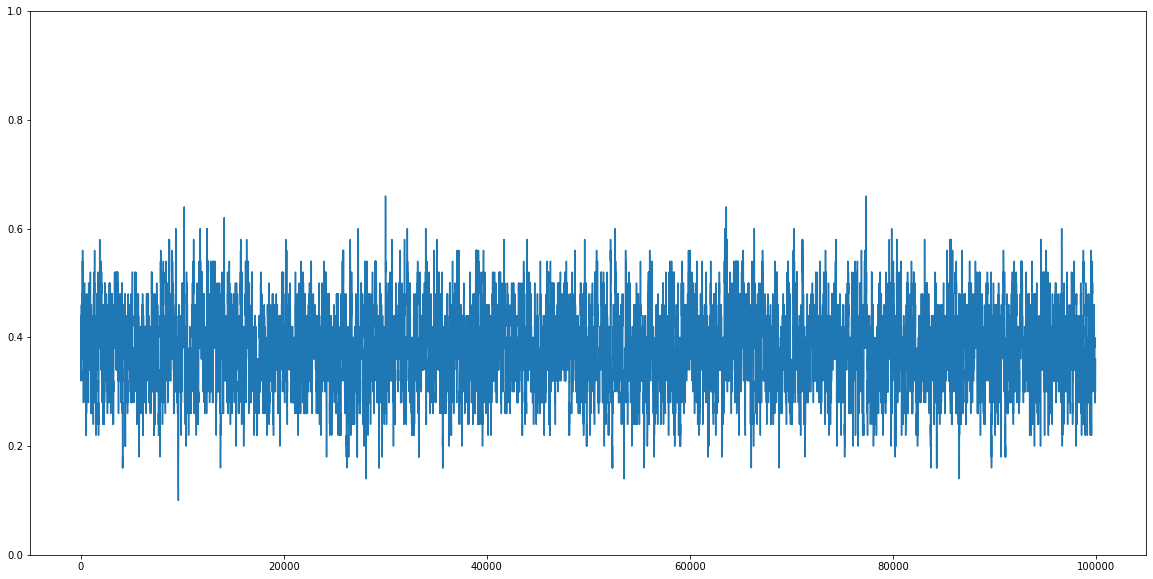

In [44]:
# Analysis of the acceptance probability:

print("Acceptance probability: ", sum(accept_reject)/len(accept_reject))

# Plot moving average of the acceptance probability (should stabilise as iteration increase)

def moving_average(l, width=50):
    """
    Compute the moving average of list l
    
    Keyword arguments:
    l -- float list, list of which we want to compute the moving average
    width -- int, window size of the moving average
    
    Returns:
    list of moving averages
    """
    return np.convolve(l, np.ones(width), 'valid') / width


movingAverage = moving_average([int(e) for e in accept_reject])

plt.figure(figsize=(20,10))
plt.ylim(0,1)
plt.plot(movingAverage)

### Likelihood

In [62]:
true_likelihood

-5.094636543930744e-05

Text(0.5, 1.0, 'Evolution of the likelihood')

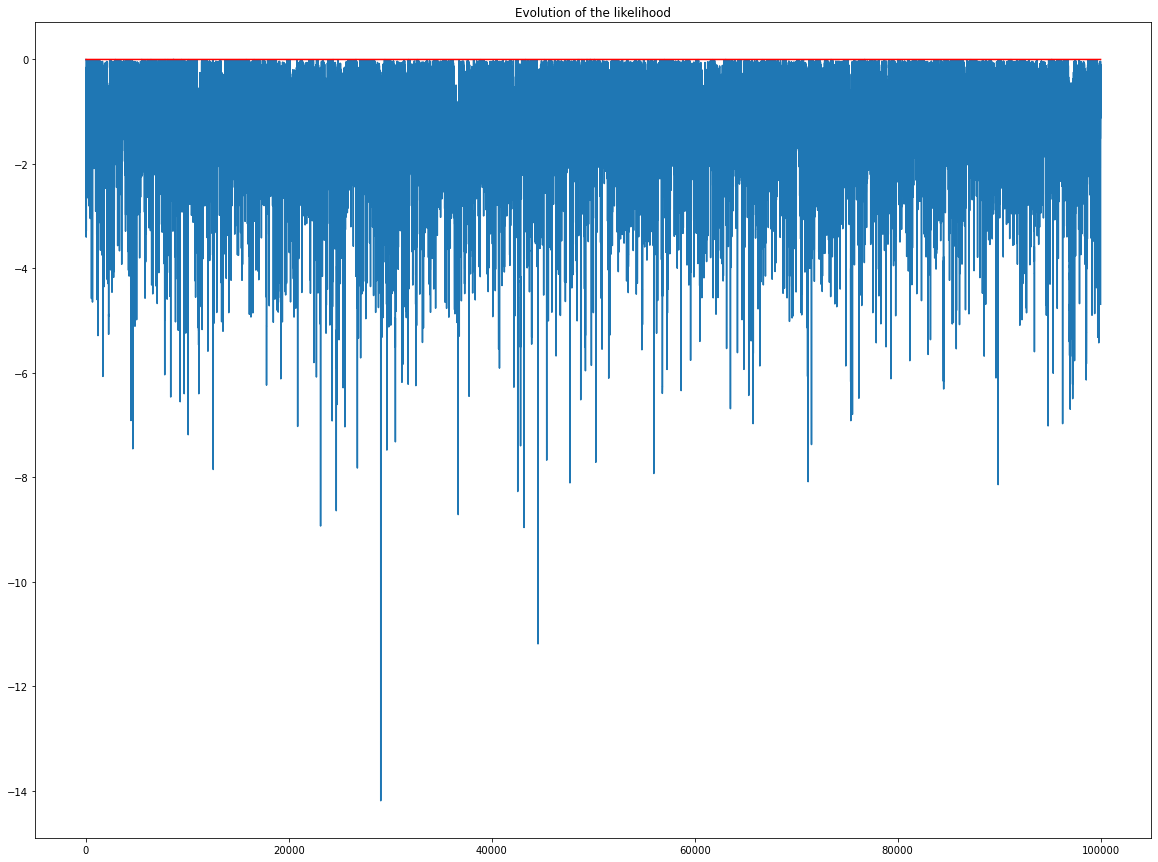

In [33]:
# Plot the evolution of the likelihood
plt.figure(figsize=(20,15))
plt.plot(likelihoods)

# Plot the true likelihood for reference
true_likelihood = compute_loglikelihood(u_values_true, observations)
plt.plot([true_likelihood]*n_iter, color = 'red')

plt.title("Evolution of the likelihood")

### Chain values

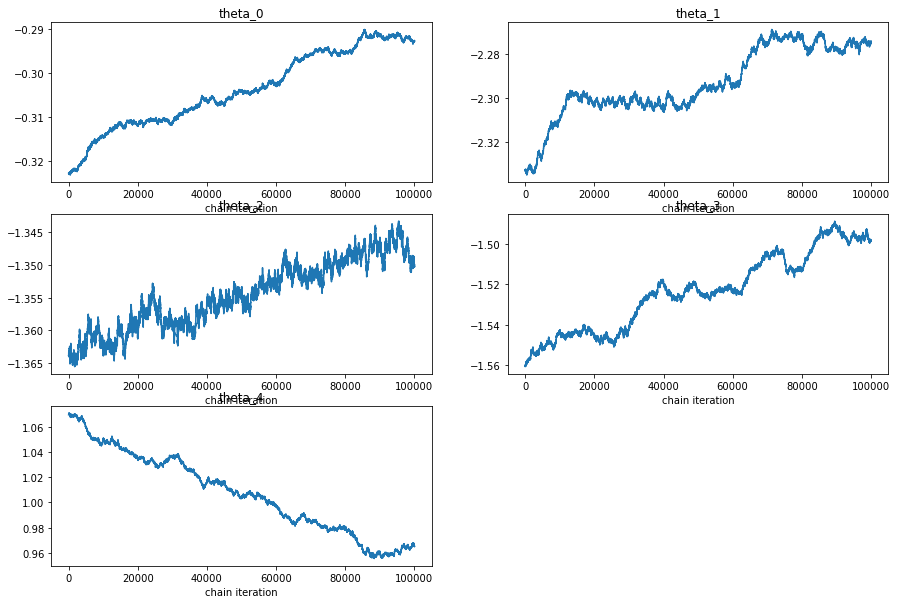

In [45]:
# Plot the chain so we can visually assess if converges

fig = plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.title('theta_0')
plt.xlabel('chain iteration')
plt.plot([theta[0] for theta in chain])
#plt.ylim(-10,10)

plt.subplot(3, 2, 2)
plt.title('theta_1')
plt.plot([theta[1] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 3)
plt.title('theta_2')
plt.plot([theta[2] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 4)
plt.title('theta_3')
plt.plot([theta[3] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.subplot(3, 2, 5)
plt.title('theta_4')
plt.plot([theta[4] for theta in chain])
plt.xlabel('chain iteration')
#plt.ylim(-10,10)

plt.show()

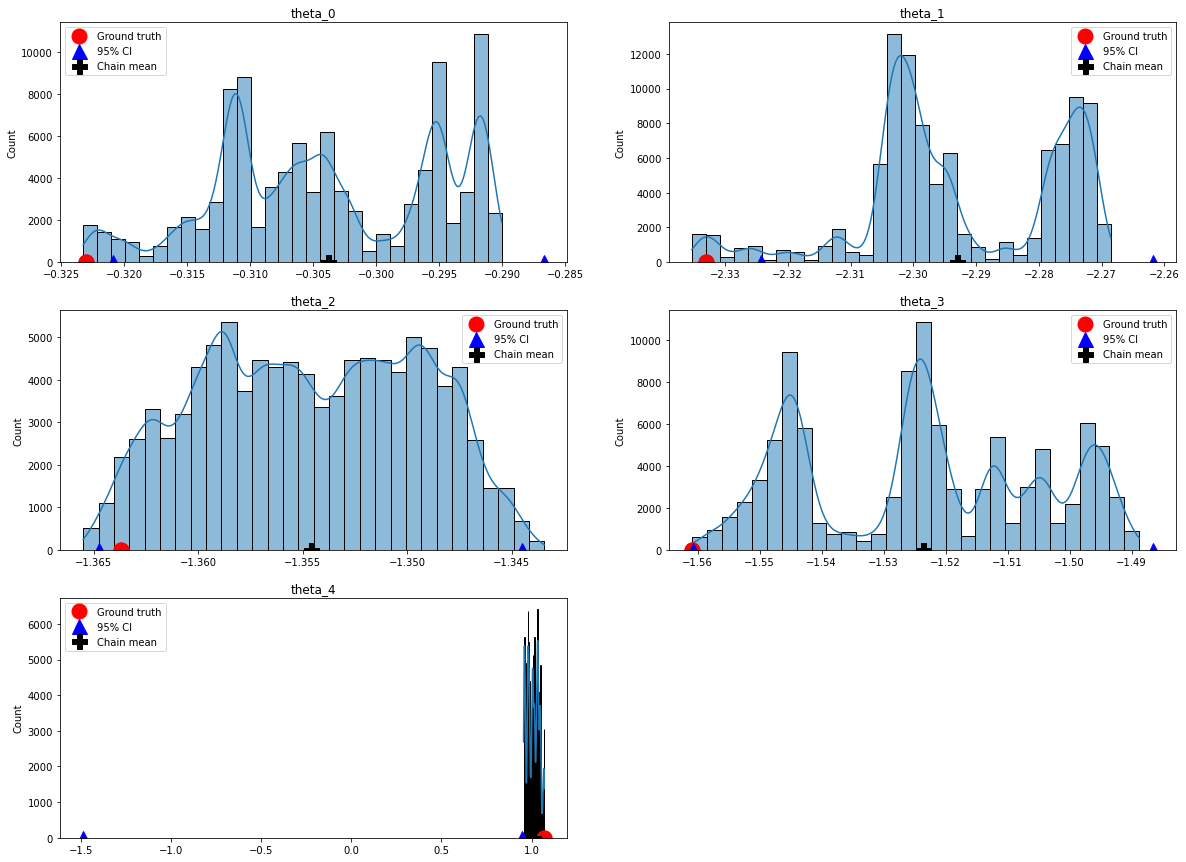

In [46]:
#  Plot histogram of chain, with mean + 95% confidence interval
import seaborn as sns
import scipy.stats as st

burnin = 10000
burnin=0

# Compute stats
confidence_intervals=[]
means = []
for i in range(K):
    
    # Define sample data
    data = [theta[i] for theta in chain][burnin:]
    means.append(np.mean(data))
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    confidence_intervals.append(confidence_interval)


#---------------------------------Plot histograms----------------------------------------
fig = plt.figure(figsize=(20,15))

plt.subplot(3, 2, 1)
plt.title('theta_0')
sns.histplot([theta[0] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[0], theta_0[0]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[0][0], confidence_intervals[0][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[0], means[0]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 2)
plt.title('theta_1')
sns.histplot([theta[1] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[1], theta_0[1]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[1][0], confidence_intervals[1][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[1], means[1]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 3)
plt.title('theta_2')
sns.histplot([theta[2] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[2], theta_0[2]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[2][0], confidence_intervals[2][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[2], means[2]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.subplot(3, 2, 4)
plt.title('theta_3')
sns.histplot([theta[3] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[3], theta_0[3]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[3][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[3], means[3]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()

plt.subplot(3, 2, 5)
plt.title('theta_4')
sns.histplot([theta[4] for theta in chain][burnin:], kde = True, bins = 30)
plt.plot([theta_0[4], theta_0[4]],[0,0], 'ro', markersize=15, label = "Ground truth")
plt.plot([confidence_intervals[4][0], confidence_intervals[3][1]],[0,0], 'b^', markersize=15, label = "95% CI")
plt.plot([means[4], means[4]],[0,0], 'kP', markersize=15, label = "Chain mean")
plt.legend()


plt.show()

In [47]:
# Retrieving some stats - mean and confidence interval for every theta

import scipy.stats as st

# Run the loop
for i in range(K):
    
    # Define sample data
    data = [theta[i] for theta in chain][burnin:]
  
    # Create 95% confidence interval
    confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))
    
    print(f"True value of the coefficient: {theta_0[i]}")
    print(f"Confidence interval: {confidence_interval}")
    print(f"Within confidence interval? {confidence_interval[0] <= theta_0[i] and confidence_interval[1] >= theta_0[i]}\n")

True value of the coefficient: -0.32299714796000645
Confidence interval: (-0.3209163058107687, -0.2866587164953086)
Within confidence interval? False

True value of the coefficient: -2.3330636333545702
Confidence interval: (-2.3242141101801104, -2.261814457106168)
Within confidence interval? False

True value of the coefficient: -1.36370042018264
Confidence interval: (-1.3647225687639435, -1.3444856583011577)
Within confidence interval? True

True value of the coefficient: -1.5609160456110878
Confidence interval: (-1.5607347751543452, -1.4865434891994167)
Within confidence interval? False

True value of the coefficient: 1.0694364281593631
Confidence interval: (0.9449615218101409, 1.0697417630792943)
Within confidence interval? True



In [54]:
# Auxiliary function to determine whether the chain sample fits in the 95% confidence interval

def within_confidence_interval(sample, chain):
    """
    Determines whether the sample sits within the confidence interval - to exclude extreme betas in reconstructions
    
    Keyword arguments:
    sample -- K-dim list, values of coefficients, drawn from the chain
    chain -- the whole chain
    
    Returns:
    boolean - whether all K components of the chain sample are within the 95% confidence interval
    """
    
    # Run the loop over dimensions of the parameter
    for k in range(K):
    
        data = [theta[k] for theta in chain]
        
        # Create 95% confidence interval
        confidence_interval = st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),scale=np.std(data))

        within_interval = confidence_interval[0] <= sample[k] and confidence_interval[1] >= sample[k]
        
        if not within_interval:
            return False
    
    return True

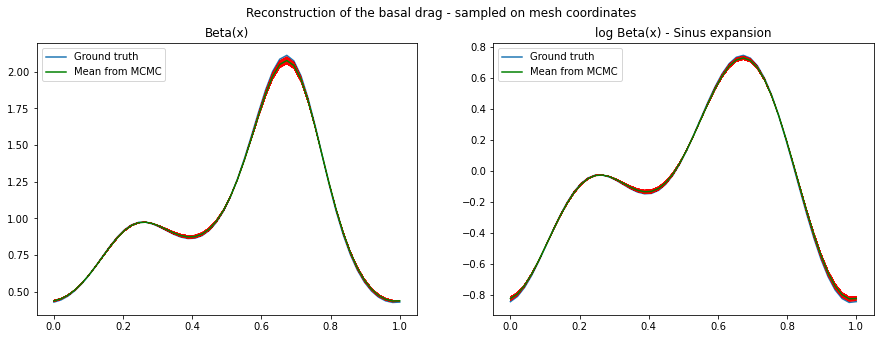

In [55]:
# Comparing true and simulated beta function. We plot the sinus expansion and the final beta function

import random

#-------------Start plotting with the true function-----------------------

# Build the true function
beta_0 = build_beta(theta_0)
interval = [(x,0) for x in np.linspace(0,1,size_msh)]


%matplotlib inline

plt.figure(figsize=(15,5))
plt.suptitle("Reconstruction of the basal drag - sampled on mesh coordinates")

plt.subplot(1,2,1)
plt.title("Beta(x)")
plt.plot([x[0] for x in interval], [beta_0(x) for x in interval], label = "Ground truth")

plt.subplot(1,2,2)
plt.title("log Beta(x) - Sinus expansion")
plt.plot([x[0] for x in interval], [np.log(beta_0(x)) for x in interval], label = "Ground truth")


#-------------Add reconstruction from samples drawn from the chain---------------------------------

n_draws = 1000
all_betas = [0 for x in interval] # table to keep track of betas and compute mean at the end
all_log_betas = [0 for x in interval] # table to keep track of log betas and compute mean at the end
drawn = 0

while drawn < n_draws:

    draw = random.choice(chain)
    
    if within_confidence_interval(draw, chain[burnin:]):

        beta = build_beta(draw)
        beta_values = [beta(x) for x in interval]
        log_beta_values = [np.log(bv) for bv in beta_values]
        
        plt.subplot(1,2,1)
        plt.plot([x[0] for x in interval], beta_values, linewidth = 0.05, color='r')
        
        plt.subplot(1,2,2)
        plt.plot([x[0] for x in interval],log_beta_values, linewidth = 0.05, color='r')
        
        
        all_betas = [sum(x) for x in zip(all_betas, beta_values)] # update the list of all drawn betas
        all_log_betas = [sum(x) for x in zip(all_log_betas, log_beta_values)] # update the list of all drawn log betas
        drawn+=1 # update the count
        
        

# Add the empirical average to the plots

plt.subplot(121)
all_betas = [b/drawn for b in all_betas]
plt.plot([x[0] for x in interval], all_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.subplot(122)
all_log_betas = [b/drawn for b in all_log_betas]
plt.plot([x[0] for x in interval], all_log_betas, color='g', label = "Mean from MCMC")
plt.legend()

plt.show()

### Joint densities

        theta_0   theta_1   theta_2   theta_3   theta_4
0     -0.260595  0.459516  0.814133 -0.096867  1.335249
1     -0.218195  0.411084  0.713261 -0.119059  1.309881
2     -0.218195  0.411084  0.713261 -0.119059  1.309881
3     -0.279714  0.418072  0.658331  0.152392  1.327744
4     -0.279714  0.418072  0.658331  0.152392  1.327744
...         ...       ...       ...       ...       ...
49995 -0.175679 -0.577337  1.136956 -0.218802 -0.243442
49996 -0.169042 -0.373819  1.050024 -0.244775 -0.289442
49997 -0.169042 -0.373819  1.050024 -0.244775 -0.289442
49998 -0.169042 -0.373819  1.050024 -0.244775 -0.289442
49999 -0.169042 -0.373819  1.050024 -0.244775 -0.289442

[50000 rows x 5 columns]


<IPython.core.display.Javascript object>


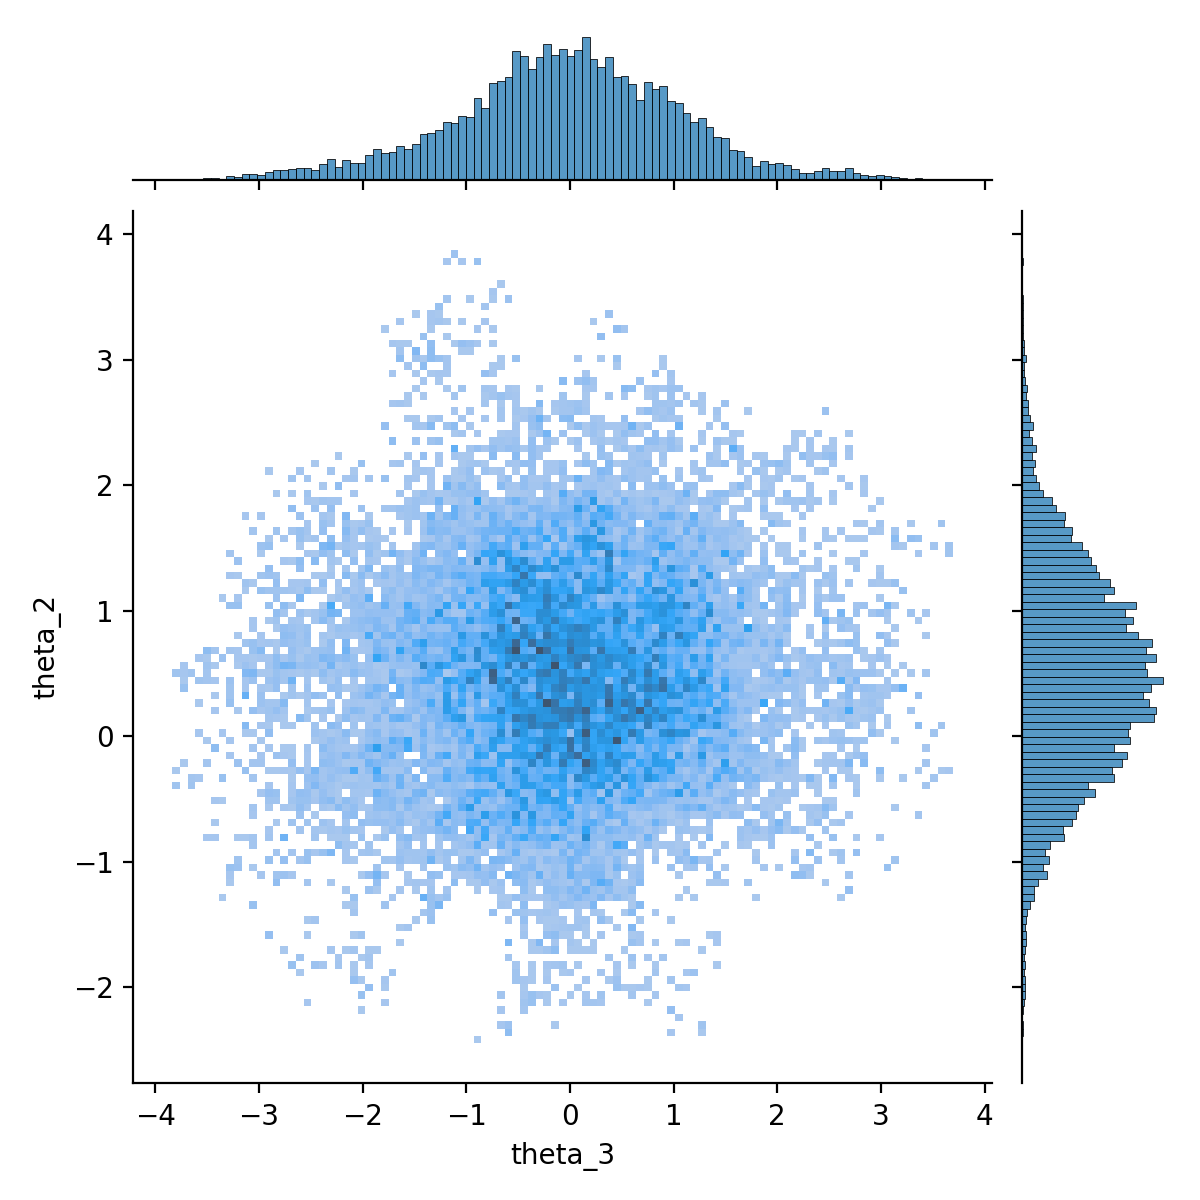

In [56]:
# Scatterplots

import pandas as pd
import seaborn as sns

data = np.array(chain)
df= pd.DataFrame(chain, columns = [f"theta_{k}" for k in range(K)], dtype=float)
print(df)


sns.jointplot(data=df, x='theta_3', y='theta_2', kind="hist")

<IPython.core.display.Javascript object>


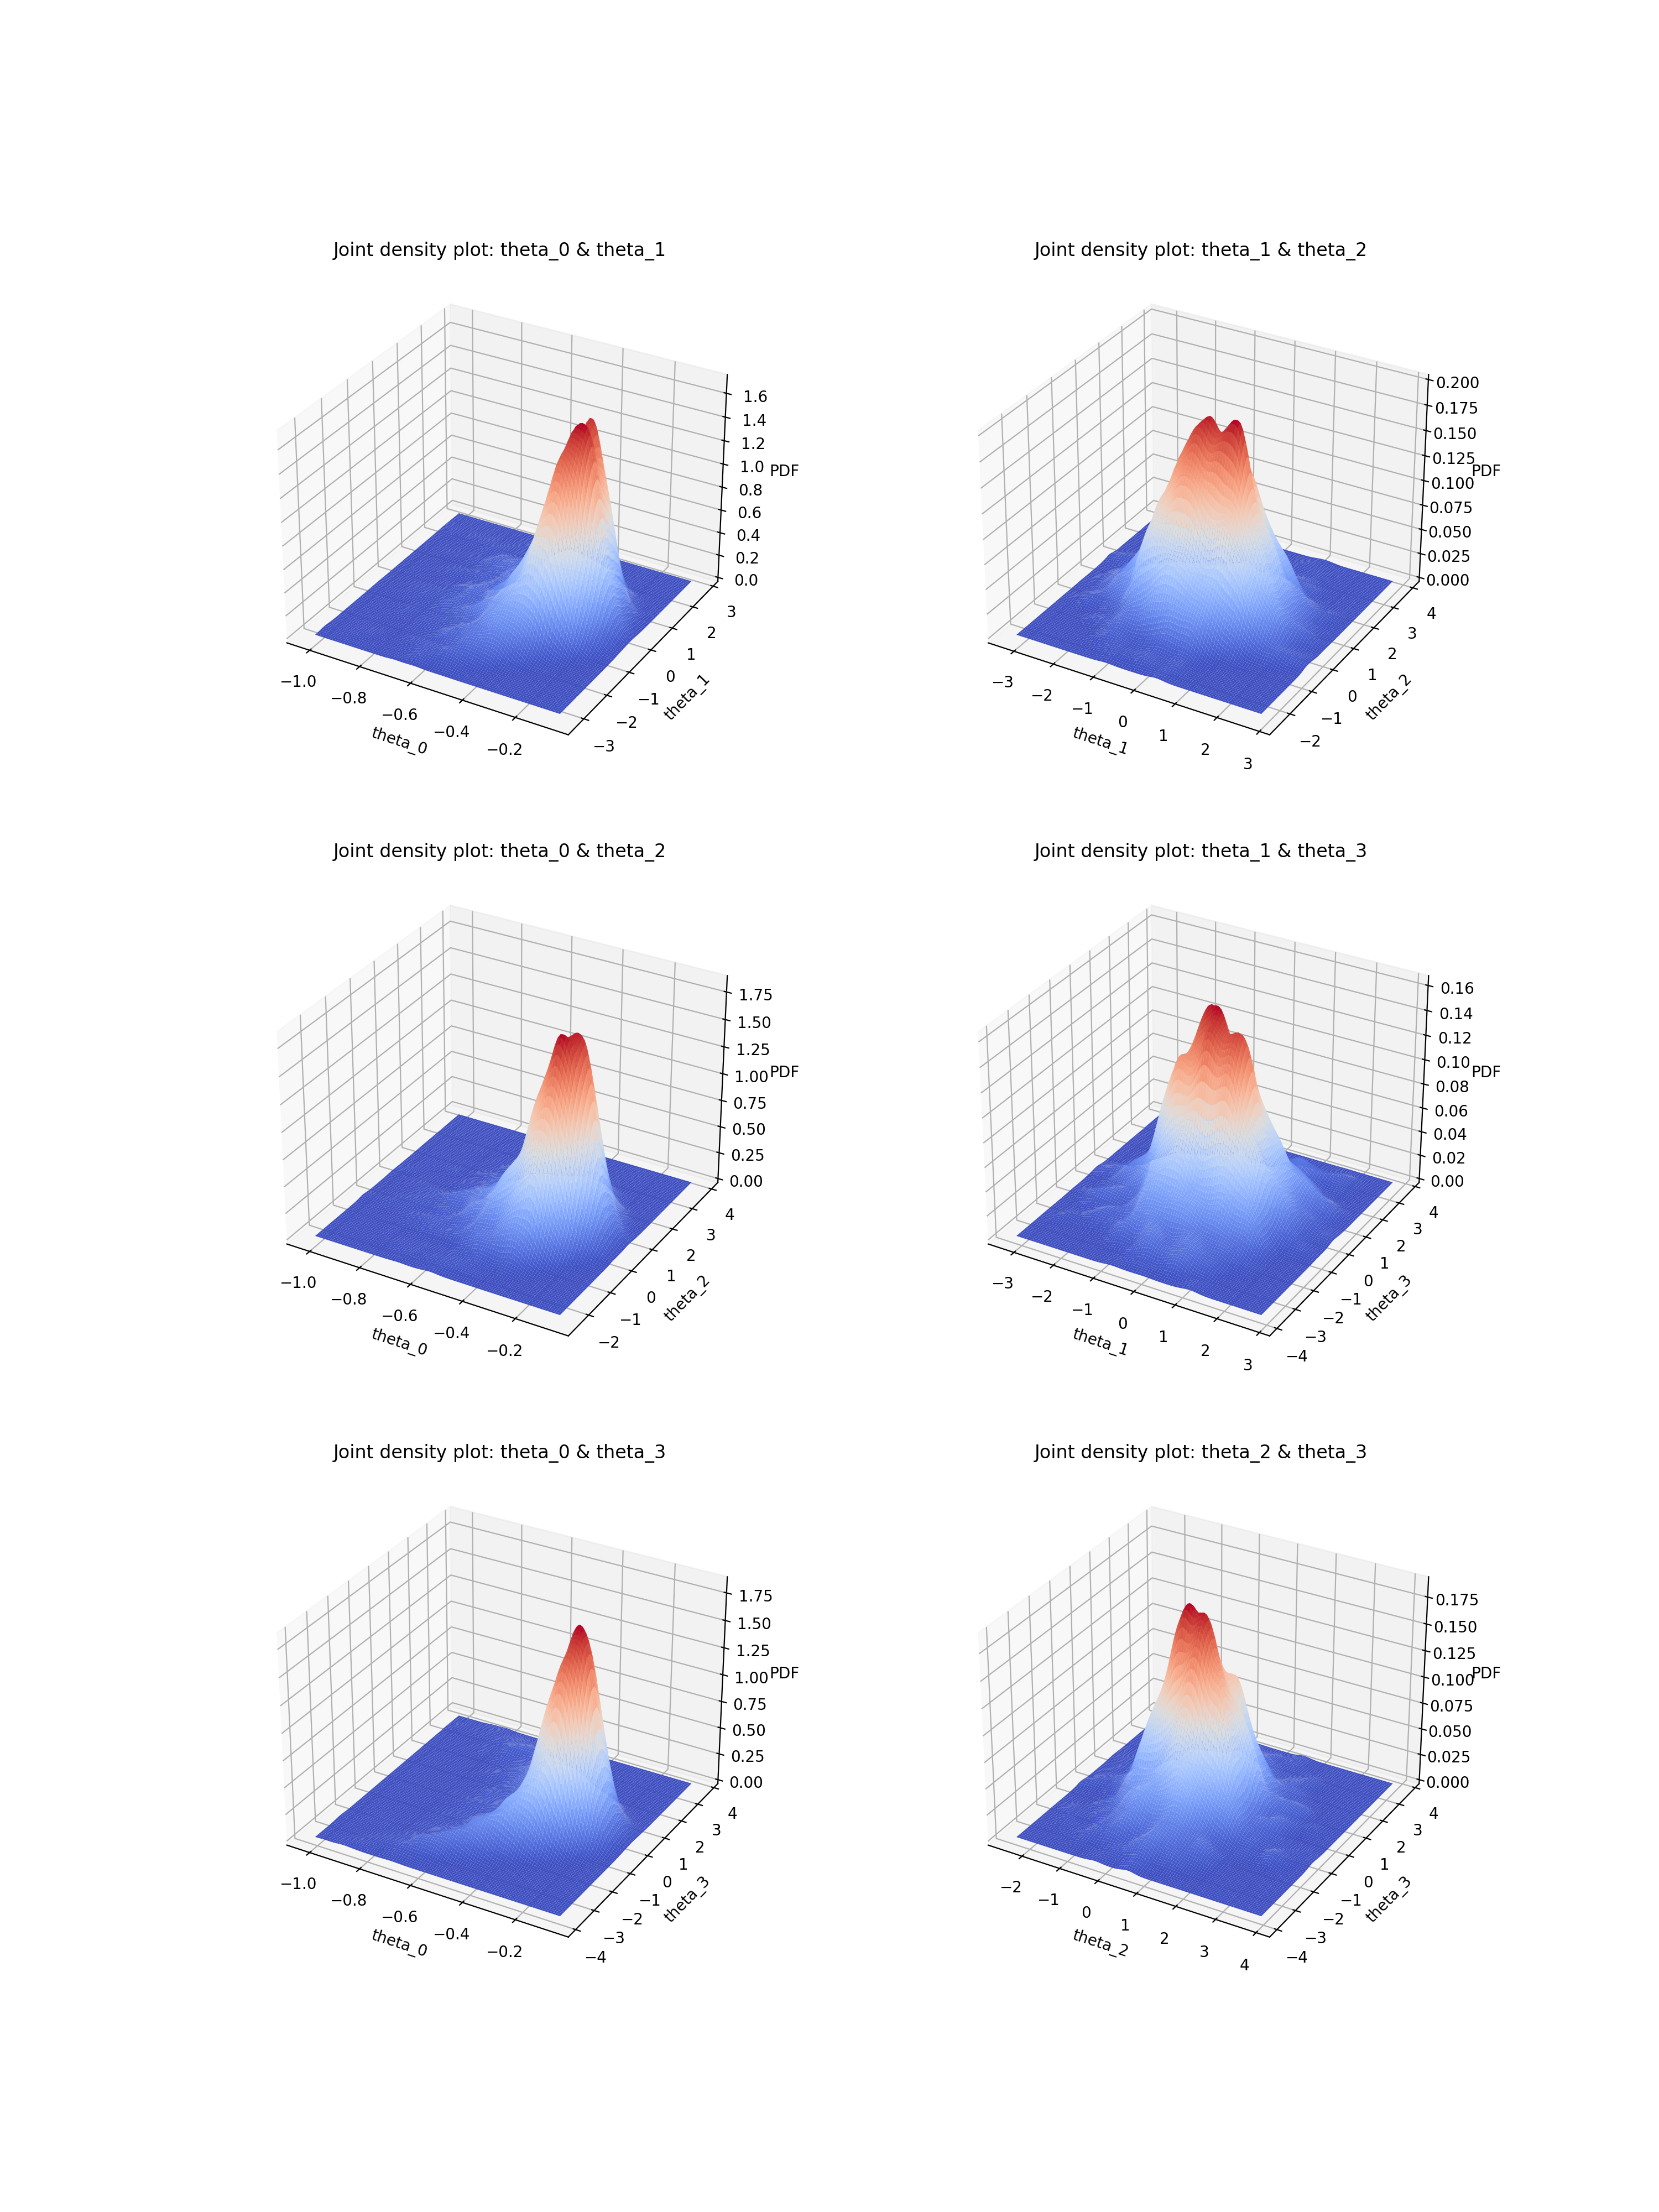

(3, 2)


In [57]:
# Displaying densities in 3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

%matplotlib notebook

fig, axs = plt.subplots(3, 2, figsize=(15, 20), subplot_kw={'projection': '3d'})
print(np.shape(axs))

# Loop over the different parameter combination

combinations = [('theta_0','theta_1'), ('theta_0','theta_2'), ('theta_0','theta_3'),
               ('theta_1','theta_2'), ('theta_1','theta_3'), ('theta_2','theta_3')]

row,col = 0, 0

for idx1,idx2 in combinations:
    x = np.array(df[idx1])
    y = np.array(df[idx2])
    ax = axs[row%3, col//3]
                
    # Create meshgrid
    xmin, xmax =np.min(x),np.max(x)
    ymin, ymax = np.min(y),np.max(y)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    # Create values
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel(idx1)
    ax.set_ylabel(idx2)
    ax.set_zlabel('PDF')
    ax.set_title(f'Joint density plot: {idx1} & {idx2}')
    #fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

    #ax.view_init(60, 35)
    
    # Update the row/col index
    row = row+1
    col = col+1
    
plt.show()

### Analyse surface velocity errors

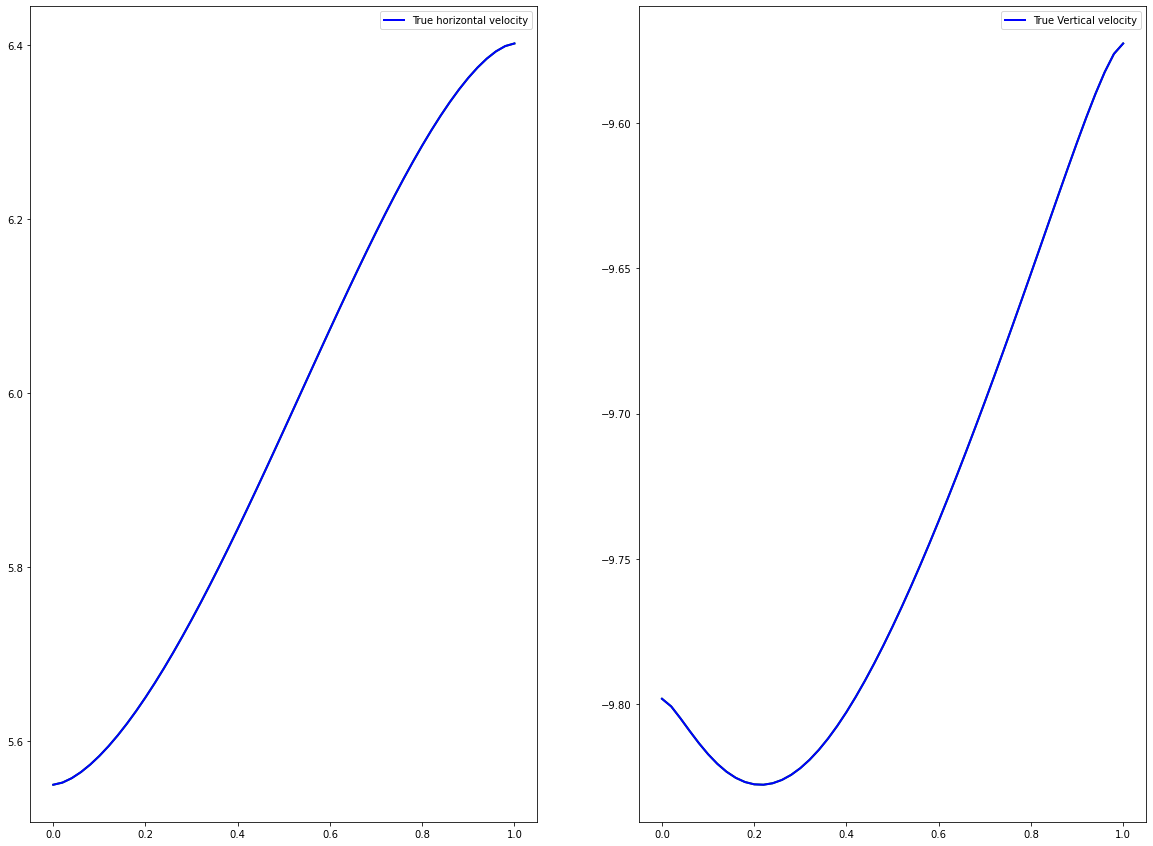

In [21]:
interval = [(k/size_msh, 0) for k in range(size_msh+1)]

fig = plt.figure(figsize=(20,15))

# Plot draws from the histograms on top
n_draws = 500

velocities_x = []
velocities_y = []

for d in range(n_draws):

    draw = random.choice(chain[burnin:])
    surface_coords,u_values = forward_map(draw)

    velocity_x = [u_values[i][0] for i in range(len(surface_coordinates))]
    velocity_y = [u_values[i][1] for i in range(len(surface_coordinates))]
    x_value = [interval[i][0] for i in range(len(surface_coordinates))]

    velocities_x.append(velocity_x)
    velocities_y.append(velocity_y)


    plt.subplot(121)  
    plt.plot(x_value, velocity_x, linewidth = 0.05, color='r')

    plt.subplot(122)    
    plt.plot(x_value, velocity_y,  linewidth = 0.05, color='r')


#Plot the average
avg_velocity_x = [np.mean([velocity_x[i] for velocity_x in velocities_x]) for i in range(len(surface_coordinates))]
avg_velocity_y = [np.mean([velocity_y[i] for velocity_y in velocities_y]) for i in range(len(surface_coordinates))]

plt.subplot(121)  
plt.plot(x_value, avg_velocity_x, linewidth = 2, color='g')

plt.subplot(122)    
plt.plot(x_value, avg_velocity_y, linewidth = 2, color='g')



# Plot the true function
surface_coordinates, u_values = forward_map(theta_0)
velocity_x = [u_values[i][0] for i in range(len(surface_coordinates))]
velocity_y = [u_values[i][1] for i in range(len(surface_coordinates))]
x_value = [interval[i][0] for i in range(len(surface_coordinates))]

plt.subplot(121)
plt.plot(x_value, velocity_x, "b", linewidth=2, label="True horizontal velocity")
plt.legend()
#plt.ylim(-10,10)

plt.subplot(122)
plt.plot(x_value, velocity_y, "b", linewidth = 2, label="True Vertical velocity")
plt.legend()
#plt.ylim(-10,10)


plt.show()


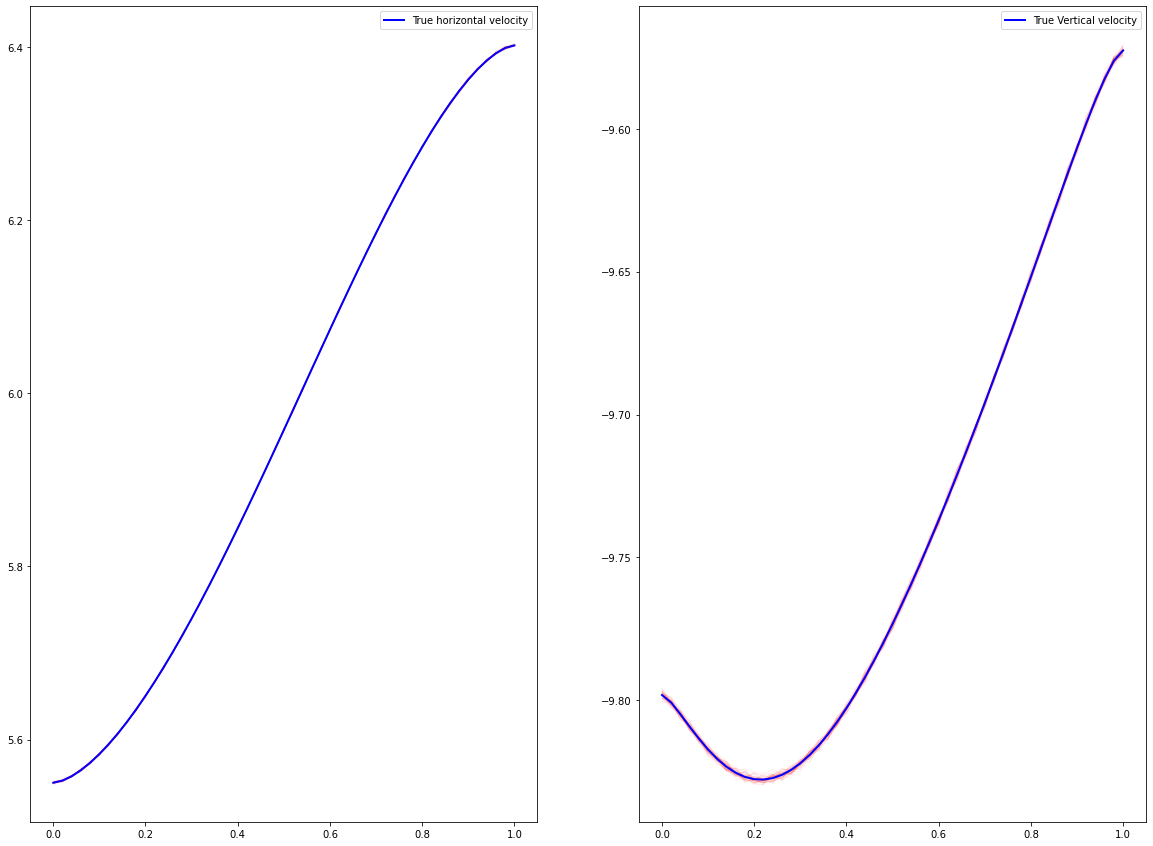

In [22]:
## Comparing with synthetic data

n_curves = 50

fig = plt.figure(figsize=(20,15))


for d in range(n_curves):
    draw = random.choice(np.arange(N))

    observation = observations[draw]
    velocity_x, velocity_y = [observation[i][0] for i in range(len(surface_coordinates))], [observation[i][1] for i in range(len(surface_coordinates))]

    plt.subplot(121)
    plt.plot(x_value, velocity_x, "r", linewidth=0.05)

    plt.subplot(122)
    plt.plot(x_value, velocity_y, "r", linewidth = 0.05)

     
    
# Plot true
velocity_x, velocity_y = [u_values_true[i][0] for i in range(len(surface_coordinates))], [u_values_true[i][1] for i in range(len(surface_coordinates))]

plt.subplot(121)
plt.plot(x_value, velocity_x, "b", linewidth=2, label="True horizontal velocity")
plt.legend()

plt.subplot(122)
plt.plot(x_value, velocity_y, "b", linewidth = 2, label="True Vertical velocity")
plt.legend()

plt.show()



## Make loops to test hyperparameters?

In [ ]:
def run_mcmc_trials(gamma, scale_coefficients, scale_noise):
    
    #---------------------------GENERATE FAKE DATA-----------------------------------------------------
    
    # Generating "fake" data / Generate K coefficients following prior assumptions
    theta_0 = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)

    #print(f"Values of the true coefficients set to {theta_0}")
    
    # We repeat N experiments of measurements with the true coefficients and noise

    # Retrieve the true values according to the model with true coefficients
    surface_coordinates, u_values = forward_map(theta_0)

    # Simulate noisy observations
    N= 100
    observations = []

    for n_obs in range(N):
      observation = u_values.copy()
      added_noise = np.random.normal(loc=0.0, scale=scale_noise, size=np.shape(observation)) # add gaussian noise at every evaluation
      observation+=added_noise

      observations.append(observation)

    
    #--------------------------------------RUN THE MARKOV CHAIN----------------------------------------

    # Parameters of the MCMC
    n_iter = 10000 # number of iterations of the chain
    gamma = gamma


    # INITIALISATION

    theta = np.random.normal(loc=0.0, scale=scale_coefficients, size=K)

    # Compute the model and likelihood of this proposal
    surface_coords,model_values = forward_map(theta)
    current_loglikelihood = compute_loglikelihood(model_values, observations)

    # Useful tables to store values
    chain = [theta] # store the values of the chain
    accept_reject = [True] # boolean table we use to track whether the proposal was accepted/rejected
    likelihoods = [current_loglikelihood] # store values of likelihoods


    #--------------------ITERATE-----------------------------------------------------------------------

    for iter in range(n_iter):

      # Get the proposal for new value
      proposal = compute_proposal_pcn(theta, gamma)
      #print('Proposal: ', proposal)

      # Compute the model and likelihood of this proposal
      surface_coords, model_values = forward_map(proposal)
      proposal_loglikelihood = compute_loglikelihood(model_values, observations)

      # Metropolis step
      accept = metropolis_step(current_loglikelihood, proposal_loglikelihood, accept_reject)

      if accept:
        #print('accepted')
        accept_reject.append(True)
        theta = proposal.copy()
        current_loglikelihood = proposal_loglikelihood

      else:
        #print("rejected")
        accept_reject.append(False)

      chain.append(theta)
      likelihoods.append(current_loglikelihood)
        
    
    dict_ = {}
    dict_['gamma']=gamma
    dict_['scale_coefficients']=scale_coefficients
    dict_['scale_noise']=scale_noise
    dict_['accept_reject']=accept_reject
    dict_['acceptance_probability']= sum(accept_reject)/len(accept_reject)
    dict_['chain']=chain
    dict_['likelihoods']=likelihoods
    
    return dict_



In [ ]:
import pandas as pd

gammas = [0.001, 0.003, 0.01, 0.03, 0.1,0.3]
scales_coeff = [0.001, 0.003, 0.01, 0.03, 0.1,0.3,1,3,10,30,100]
scales_noise =[0.001, 0.003, 0.01, 0.03, 0.1,0.3,1,3,10,30,100]

df = pd.DataFrame()

for gamma in gammas:
    for scale_coefficients in scales_coeff:
        for scale_noise in scales_noise:
            
            print(f"Running with coefficients: gamma {gamma}, scale_coefficients {scale_coefficients}, scale_noise {scale_noise}.")
            dict_ = run_mcmc_trials(gamma, scale_coefficients, scale_noise)
            
            new_run = pd.DataFrame.from_dict(dict_)
            
            df = pd.concat([df, new_run])
            df.to_csv("output.csv", sep=';')  

In [ ]:
df['chain'].tolist())

In [ ]:
df.to_csv("output.csv", sep=';')  